# Introduction
The project below investigates 2019 Trends in International Math and Science Study (TIMSS) Data for 8th graders.

_Source: [2019 TIMSS Database](https://timss2019.org/international-database/)_

<div id='top'></div>

# Table of Contents
* [Business Understanding](#business_understanding)
* [Data Understanding](#data_understanding)
* [Data Preparation](#data_preparation)
* [Data Modeling](#data_modeling)
* [Evaluate Results](#evaluate_results)
* [Deploy Model](#deploy_model)

<div id='business_understanding'></div>

# Business Understanding

### Questions of Interest
1. How does a student's enviroment at home, in the classroom, and at school affect academic understanding?
2. Are there specific teacher behaviors that lead to improved understanding in specific disciplines?
3. What can students and teachers do to improve student academic understanding?

The project will cover a variety of analyses regarding vast data collected. The project will include:
* prediction of student score based on student attitudes and demographics, school characteristics
* prediction of student scores based on teacher attitudes and practices
* recommendation engine for additional study problems for a given student (or group of students from a school or country)
* recommendation engine for areas of investment or professional development for a given teacher (or group of teachers from a school or country)

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import re
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.metrics import confusion_matrix
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [2]:
# import the country codes into a dataframe
country_codes = pd.read_csv('data/country_codes.csv').dropna()
# rename the columns to be consistent with TIMSS information
country_codes.rename(columns = {'ID':'IDCNTRY'}, inplace=True)
# convert IDCNTRY to integers
country_codes['IDCNTRY'] = country_codes['IDCNTRY'].astype(int)
# demonstrate country code information
country_codes

Country  IDCNTRY
0                   Australia       36
1                     Bahrain       48
2                       Chile      152
3              Chinese Taipei      158
4                      Cyprus      196
5                       Egypt      818
6                     England      926
7                     Finland      246
8                      France      250
9                     Georgia      268
10              Hong Kong SAR      344
11                    Hungary      348
12      Iran, Islamic Rep. of      364
13                    Ireland      372
14                     Israel      376
15                      Italy      380
16                      Japan      392
17                     Jordan      400
18                 Kazakhstan      398
19             Korea, Rep. of      410
20                     Kuwait      414
21                    Lebanon      422
22                  Lithuania      440
23                   Malaysia      458
24                    Morocco      504
25                New Zealand      554
26                     Norway      578
27                       Oman      512
28                   Portugal      620
29                      Qatar      634
30                    Romania      642
31         Russian Federation      643
32               Saudi Arabia      682
33                  Singapore      702
34               South Africa      710
35                     Sweden      752
36                     Turkey      792
37       United Arab Emirates      784
38              United States      840
39            Ontario, Canada     9132
40             Quebec, Canada     9133
41  Moscow City, Russian Fed.   643001
42             Abu Dhabi, UAE     7842
43                 Dubai, UAE     7841

<div id='data_understanding'></div>

[Return to Top](#top)

# Data Understanding

### Load Data
Import the 2019 TIMSS Data into six separate dataframes

In [3]:
# gather the metadata (column names) for the student assessment data
meta = pyreadstat.read_sav('T19_G8_SPSS Data/bsaausm7.sav', metadataonly=True)
# select a subset of the columns for analysis
stud_ach_cols = meta[0].columns[:1265]

In [4]:
# initialize variables for reading in the TIMSS data
school = 0
stud_ach = 0
student = 0
stud_teach = 0
math_teach = 0
sci_teach = 0

# loop through each SPSS file
for file in glob.glob('T19_G8_SPSS Data/*.sav'):
    # print the file name to monitor progress
    print(file)
    # if file name contains "bcg" then it is a file with school level information
    if re.search('bcg',file) != None:
        # identify the subset of columns necessary for school level analysis
        school_cols = ['IDCNTRY','IDSCHOOL','IDPOP','IDGRADER','IDGRADE','ITLANG_C','LCID_C','BCBGDAS','BCBGEAS','BCBGMRS','BCBGSRS','BCDGDAS','BCDGEAS','BCDGMRS','BCDGSRS','BCDGSBC','BCDGTIHY']
        try:
            # append the new file onto the existing school level data (if exists)
            school = school.append(pd.read_spss(file, usecols=school_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the school level data
            school = pd.read_spss(file, usecols=school_cols)
    # if file name contains "bsa" then it is a file with student achievement level information
    elif re.search('bsa',file) != None:
        try:
            # append the new file onto the existing student achievement level data (if exists)
            stud_ach = stud_ach.append(pd.read_spss(file, usecols=stud_ach_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student achievement level data
            stud_ach = pd.read_spss(file, usecols=stud_ach_cols)
    # if file name contains "bsg" then it is a file with student level information
    elif re.search('bsg',file) != None:
        # identify the subset of columns necessary for student level analysis
        student_cols = ['IDCNTRY','IDBOOK','IDSCHOOL','IDCLASS','IDSTUD','BSBG01','BSBG03','BSBG04','BSBG05A','BSBG05B','BSBG05C','BSBG05D','BSBG05E','BSBG05F','BSBG05G','BSBG05H','BSBG05I','BSBG06A','BSBG06B','BSBG07','BSBG08A','BSBG08B','BSBG09A','BSBG09B','BSBG10','BSBG11A','BSBG11B','BSBG12A','BSBG12B','BSBG12C','BSBG12D','BSBG12E','BSBG12F','IDPOP','IDGRADE','ITLANG_SQ','LCID_SQ','ITLANG_SA','LCID_SA','ITSEX','BSDAGE','BSBGHER','BSDGHER','BSBGSSB','BSDGSSB','BSBGSB','BSDGSB','BSBGSLM','BSDGSLM','BSBGICM','BSDGICM','BSBGDML','BSDGDML','BSBGSCM','BSDGSCM','BSBGSVM','BSDGSVM','BSBGSLS','BSDGSLS','BSBGICS','BSDGICS','BSBGSCS','BSDGSCS','BSBGSVS','BSDGSVS','BSBGSLB','BSDGSLB','BSBGICB','BSDGICB','BSBGSCB','BSDGSCB','BSBGSLE','BSDGSLE','BSBGICE','BSDGICE','BSBGSCE','BSDGSCE','BSBGSLC','BSDGSLC','BSBGICC','BSDGICC','BSBGSCC','BSDGSCC','BSBGSLP','BSDGSLP','BSBGICP','BSDGICP','BSBGSCP','BSDGSCP','BSBGSEC','BSDGSEC', 'BSDG05S','BSDGEDUP']
        try:
            # append the new file onto the existing student level data (if exists)
            student = student.append(pd.read_spss(file, usecols=student_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student level data
            student = pd.read_spss(file, usecols=student_cols)
    # if file name contains "bst" then it is a file with student-teacher level information
    elif re.search('bst',file) != None:
        try:
            # identify the subset of columns necessary for student-teacher level analysis
            stud_teach_cols = ['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDTEALIN', 'IDTEACH','IDLINK', 'IDPOP', 'IDGRADE', 'IDSUBJ', 'ITCOURSE', 'NMTEACH','NSTEACH']
            # identify the subset of columns necessary for student-teacher level analysis
            scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']
            # select appropriate scores for student-teacher level analysis
            for item in scores:
                stud_teach_cols = stud_teach_cols + [col for col in stud_teach.columns if item in col]
            # append the new file onto the existing student-teacher level data (if exists)
            stud_teach = stud_teach.append(pd.read_spss(file, usecols=stud_teach_cols), ignore_index=True, sort=False)
        except:
            # read in the first file to create the student-teacher level data
            stud_teach = pd.read_spss(file)
            # identify the subset of columns necessary for student-teacher level analysis
            stud_teach_cols = ['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDTEALIN', 'IDTEACH','IDLINK', 'IDPOP', 'IDGRADE', 'IDSUBJ', 'ITCOURSE', 'NMTEACH','NSTEACH']
            # identify the subset of columns necessary for student-teacher level analysis
            scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']
            # select appropriate scores for student-teacher level analysis
            for item in scores:
                stud_teach_cols = stud_teach_cols + [col for col in stud_teach.columns if item in col]
            # select the appropriate columns from the available data
            stud_teach = stud_teach.loc[:,stud_teach_cols]
    # if file name contains "btm" then it is a file with math teacher level information
    elif re.search('btm',file) != None:
        try:
            # append the new file onto the existing math teacher level data (if exists)
            math_teach = math_teach.append(pd.read_spss(file), ignore_index=True, sort=False)
        except:
            # read in the first file to create the math teacher level data
            math_teach = pd.read_spss(file)
    # if file name contains "bts" then it is a file with science teacher level information
    elif re.search('bts',file) != None:
        try:
            # append the new file onto the existing science teacher level data (if exists)
            sci_teach = sci_teach.append(pd.read_spss(file), ignore_index=True, sort=False)
        except:
            # read in the first file to create the science teacher level data
            sci_teach = pd.read_spss(file)

T19_G8_SPSS Data\bcgausm7.sav
T19_G8_SPSS Data\bcgchlm7.sav
T19_G8_SPSS Data\bcgengm7.sav
T19_G8_SPSS Data\bcgisrm7.sav
T19_G8_SPSS Data\bcgitam7.sav
T19_G8_SPSS Data\bcgjpnm7.sav
T19_G8_SPSS Data\bcglbnm7.sav
T19_G8_SPSS Data\bcgprtm7.sav
T19_G8_SPSS Data\bcgusam7.sav
T19_G8_SPSS Data\bcgzafm7.sav
T19_G8_SPSS Data\bsaausm7.sav
T19_G8_SPSS Data\bsachlm7.sav
T19_G8_SPSS Data\bsaengm7.sav
T19_G8_SPSS Data\bsaisrm7.sav
T19_G8_SPSS Data\bsaitam7.sav
T19_G8_SPSS Data\bsajpnm7.sav
T19_G8_SPSS Data\bsalbnm7.sav
T19_G8_SPSS Data\bsaprtm7.sav
T19_G8_SPSS Data\bsausam7.sav
T19_G8_SPSS Data\bsazafm7.sav
T19_G8_SPSS Data\bsgausm7.sav
T19_G8_SPSS Data\bsgchlm7.sav
T19_G8_SPSS Data\bsgengm7.sav
T19_G8_SPSS Data\bsgisrm7.sav
T19_G8_SPSS Data\bsgitam7.sav
T19_G8_SPSS Data\bsgjpnm7.sav
T19_G8_SPSS Data\bsglbnm7.sav
T19_G8_SPSS Data\bsgprtm7.sav
T19_G8_SPSS Data\bsgusam7.sav
T19_G8_SPSS Data\bsgzafm7.sav
T19_G8_SPSS Data\bsrausm7.sav
T19_G8_SPSS Data\bsrchlm7.sav
T19_G8_SPSS Data\bsrengm7.sav
T19_G8_SPS

In [5]:
# column prefixes to drop from math teacher data
math_teach_drop_cols = ['BTBM18','BTBM22','VERSION','SCOPE']
# find all columns that contain the column prefixes
for drop_head in math_teach_drop_cols:
    drop_cols = [col for col in math_teach.columns if drop_head in col]
# drop all matching columns
math_teach.drop(columns=drop_cols,inplace=True)

In [6]:
# column prefixes to drop from science teacher data
sci_teach_drop_cols = ['BTBS17','BTBS21','VERSION','SCOPE']
# find all columns that contain the column prefixes
for drop_head in sci_teach_drop_cols:
    drop_cols = [col for col in sci_teach.columns if drop_head in col]
# drop all matching columns
sci_teach.drop(columns=drop_cols,inplace=True)

In [7]:
# identify the file containing all of the code interpretations
file_name = 'T19_G8_Codebooks/T19_G8_Codebook.xlsx'
# store all codes into respectively named _codes dataframes
school_codes = pd.read_excel(file_name, sheet_name='BCGM7').set_index('Variable').iloc[:,:1]
stud_ach_codes = pd.read_excel(file_name, sheet_name='BSAM7').set_index('Variable').iloc[:,:1]
student_codes = pd.read_excel(file_name, sheet_name='BSGM7').set_index('Variable').iloc[:,:1]
stud_teach_codes = pd.read_excel(file_name, sheet_name='BSTM7').set_index('Variable').iloc[:,:1]
math_teach_codes = pd.read_excel(file_name, sheet_name='BTMM7').set_index('Variable').iloc[:,:1]
sci_teach_codes = pd.read_excel(file_name, sheet_name='BTSM7').set_index('Variable').iloc[:,:1]

In [8]:
# confirm codes were correctly stored
stud_teach_codes.head()

Label
Variable                               
IDCNTRY   Country ID - Numeric ISO Code
IDBOOK             Student Test Booklet
IDSCHOOL                      School ID
IDCLASS                        Class ID
IDSTUD                       Student ID

### Preprocessing Data
Preprocess the data to remove non-relevant information and variables

In [9]:
def binary_scores(answer): 
    '''
    converts each assessment item response into a binary number
    
    INPUT:
    answer - (str) the answer to the assessment item
                CORRECT RESPONSE, INCORRECT RESPONSE or a multiple choice response (* denotes correct answer)
          
    OUTPUT:
    a binary score for where:
            1 - correct response
            0 - incorrect response
    '''
    # keep NaN responses as NaN
    try: 
        float(answer)
        return np.nan
    except:
        # if response is correct, return 1
        if '*' in answer or ('CORRECT' in answer and 'INCORRECT' not in answer):
            return 1
        # otherwise, if the response is incorrect, return 0
        elif '*' not in answer or ('INCORRECT' in answer):
            return 0
        # in any other situation, return NaN
        else:
            return np.nan

In [10]:
def nanor(t):
    '''
    identifies if any correct answers are in the list
    
    INPUT:
    t - (list) an array of binary assessment responses
          
    OUTPUT:
    a binary score for where:
            1 - correct response found
            0 - no correct responses found
            NaN - no responses found
    '''
    # remove nan responses from the list
    t = list(filter(lambda x: str(x) != 'nan', t))
    # if no valid responses found, return NaN
    if len(t) == 0:
        return np.nan
    # otherwise, return 1 for any correct responses, 0 for no correct responses
    else:
        return int(any(t))
    
def nanand(t):
    '''
    identifies if all answers in the list are correct
    
    INPUT:
    t - (list) an array of binary assessment responses
          
    OUTPUT:
    a binary score for where:
            1 - all correct responses found
            0 - not all correct responses found
            NaN - no responses found
    '''
    # remove nan responses from the list
    t = list(filter(lambda x: str(x) != 'nan', t))
    # if no valid responses found, return NaN
    if len(t) == 0:
        return np.nan
    # otherwise, return 1 for all correct responses, 0 for not all correct responses
    else:
        return int(all(t))

In [11]:
# combine results from paper and electronic assessments to avoid redundant and ambiguous assessment comparisons

# create a list of all assessment columns from paper assessments (marked with a P) and that have not already been reduced to a single column
paper_cols_all = [col1 for col1 in list(stud_ach.columns) if (col1[1] == 'P' and col1[-4:] != '_val')]

# go through each columns
for col1 in paper_cols_all:
    # find all paper assessment columns that match the current column
    paper_cols = [str(col2) for col2 in list(stud_ach.columns) if (col1[:7] in col2 and col2[-4:] != '_val')]
    # find all electronic assessment columns that match the current column
    elec_cols = [col3 for col3 in list(stud_ach.columns) if (col1[2:7] in col3 and col1[0] == col3[0] and col3[1] == 'E')]
    # print the current columns being combined to monitor progress
    print(col1, paper_cols + elec_cols)
    # go through each of the matching paper or electronic assessment columns
    for col in paper_cols+elec_cols:
        # convert all answers to binary correct/incorrect values
        stud_ach[col] = stud_ach[col].apply(binary_scores)
    # if there are columns to be combined
    if len(paper_cols) > 0:
        # only count it as correct with all assessments were answered correctly (TIMSS assessment criteria)
        # store the result in the first of the matching columns
        stud_ach[paper_cols[0]] = stud_ach.loc[:,paper_cols].apply(nanand, axis=1)
        stud_ach[elec_cols[0]] = stud_ach.loc[:,elec_cols].apply(nanand, axis=1)
        # take the final results and combine the paper and electronic results into one column (marked with _val)
        stud_ach[col1[:7]+'_val'] = stud_ach.loc[:,[paper_cols[0],elec_cols[0]]].apply(nanor, axis=1)
        # drop previous paper and electronic assessment data to simplify the data set
        stud_ach.drop(columns=paper_cols+elec_cols, inplace=True)

MP52024 ['MP52024', 'ME52024']
MP52058A ['MP52058A', 'MP52058B', 'ME52058A', 'ME52058B']
MP52058B []
MP52125 ['MP52125', 'ME52125']
MP52229 ['MP52229', 'ME52229']
MP52063 ['MP52063', 'ME52063']
MP52072 ['MP52072', 'ME52072']
MP52146A ['MP52146A', 'MP52146B', 'ME52146A', 'ME52146B']
MP52146B []
MP52092 ['MP52092', 'ME52092']
MP52046 ['MP52046', 'ME52046']
MP52083 ['MP52083', 'ME52083']
MP52082 ['MP52082', 'ME52082']
MP52161 ['MP52161', 'ME52161']
MP52418A ['MP52418A', 'MP52418B', 'ME52418A', 'ME52418B']
MP52418B []
MP72007A ['MP72007A', 'MP72007B', 'MP72007C', 'MP72007D', 'MP72007E', 'MP72007', 'ME72007A', 'ME72007B', 'ME72007C', 'ME72007D', 'ME72007E', 'ME72007']
MP72007B []
MP72007C []
MP72007D []
MP72007E []
MP72007 []
MP72025 ['MP72025', 'ME72025']
MP72017 ['MP72017', 'ME72017']
MP72190 ['MP72190', 'ME72190']
MP72068 ['MP72068', 'ME72068']
MP72076 ['MP72076', 'ME72076']
MP72056 ['MP72056', 'ME72056']
MP72098 ['MP72098', 'ME72098']
MP72103 ['MP72103', 'ME72103']
MP72121 ['MP72121', '

In [12]:
# create a list of all math and science assessments
scores = ['MMAT','SSCI','MALG','MAPP','MDAT','MGEO','MKNO','MNUM','MREA','SAPP','SBIO','SCHE','SEAR','SKNO','SPHY','SREA']

# go through each math and science score category
for item in scores:
    # find all assessments of that category (TIMSS offers 5 estimate of each category per student)
    sub_col = [col for col in stud_ach.columns if item in col]
    # print the columns to show progress
    print(sub_col)
    # find the average assessment of the category from all estimates
    stud_ach[item.lower()+'_avg'] = stud_ach.loc[:,sub_col].mean(axis=1)
    stud_teach[item.lower()+'_avg'] = stud_teach.loc[:,sub_col].mean(axis=1)
    # find the standard deviation of the estimates for that category
    stud_ach[item.lower()+'_sd'] = stud_ach.loc[:,sub_col].std(axis=1)
    # drop the previous five estimates to simplify to the average value
    stud_ach.drop(sub_col, axis = 1, inplace=True)
    stud_teach.drop(sub_col, axis = 1, inplace=True)

['BSMMAT01', 'BSMMAT02', 'BSMMAT03', 'BSMMAT04', 'BSMMAT05']
['BSSSCI01', 'BSSSCI02', 'BSSSCI03', 'BSSSCI04', 'BSSSCI05']
['BSMALG01', 'BSMALG02', 'BSMALG03', 'BSMALG04', 'BSMALG05']
['BSMAPP01', 'BSMAPP02', 'BSMAPP03', 'BSMAPP04', 'BSMAPP05']
['BSMDAT01', 'BSMDAT02', 'BSMDAT03', 'BSMDAT04', 'BSMDAT05']
['BSMGEO01', 'BSMGEO02', 'BSMGEO03', 'BSMGEO04', 'BSMGEO05']
['BSMKNO01', 'BSMKNO02', 'BSMKNO03', 'BSMKNO04', 'BSMKNO05']
['BSMNUM01', 'BSMNUM02', 'BSMNUM03', 'BSMNUM04', 'BSMNUM05']
['BSMREA01', 'BSMREA02', 'BSMREA03', 'BSMREA04', 'BSMREA05']
['BSSAPP01', 'BSSAPP02', 'BSSAPP03', 'BSSAPP04', 'BSSAPP05']
['BSSBIO01', 'BSSBIO02', 'BSSBIO03', 'BSSBIO04', 'BSSBIO05']
['BSSCHE01', 'BSSCHE02', 'BSSCHE03', 'BSSCHE04', 'BSSCHE05']
['BSSEAR01', 'BSSEAR02', 'BSSEAR03', 'BSSEAR04', 'BSSEAR05']
['BSSKNO01', 'BSSKNO02', 'BSSKNO03', 'BSSKNO04', 'BSSKNO05']
['BSSPHY01', 'BSSPHY02', 'BSSPHY03', 'BSSPHY04', 'BSSPHY05']
['BSSREA01', 'BSSREA02', 'BSSREA03', 'BSSREA04', 'BSSREA05']


In [13]:
# drop all weight and jackknife columns that are not relevant to the analysis
stud_ach.drop(columns=[col for col in stud_ach.columns if 'WGT' in col or 'JK' in col], inplace=True)

In [14]:
# store each dataframe into its own CSV file in the data folder
school.to_csv('data/school.csv', index = False)
stud_ach.to_csv('data/stud_ach.csv', index = False)
student.to_csv('data/student.csv', index = False)
stud_teach.to_csv('data/stud_teach.csv', index = False)
math_teach.to_csv('data/math_teach.csv', index = False)
sci_teach.to_csv('data/sci_teach.csv', index = False)

In [15]:
# read each dataframe from its respective CSV file
school = pd.read_csv('data/school.csv')
stud_ach = pd.read_csv('data/stud_ach.csv')
student = pd.read_csv('data/student.csv')
stud_teach = pd.read_csv('data/stud_teach.csv')
math_teach = pd.read_csv('data/math_teach.csv')
sci_teach = pd.read_csv('data/sci_teach.csv')

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (13,14,15,16,66,68,70,72,74,76,78,80,82,84,86,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Explore Data
Explore the structure and values of the data

In [16]:
# explore the school dataframe
school.head()

IDCNTRY  IDSCHOOL  IDPOP     IDGRADER  IDGRADE ITLANG_C  \
0     36.0    5001.0  Pop 2  Upper Grade  Grade 8  English   
1     36.0    5002.0  Pop 2  Upper Grade  Grade 8  English   
2     36.0    5003.0  Pop 2  Upper Grade  Grade 8  English   
3     36.0    5004.0  Pop 2  Upper Grade  Grade 8  English   
4     36.0    5005.0  Pop 2  Upper Grade  Grade 8  English   

                LCID_C   BCBGDAS   BCBGEAS   BCBGMRS   BCBGSRS  \
0  English (Australia)  10.80136   9.26475  11.26511  11.42529   
1  English (Australia)  12.80218  12.55044  14.25596  14.57241   
2  English (Australia)   9.25300  10.46161   9.52239   9.57915   
3  English (Australia)  12.13532  12.86324  11.53380  11.70901   
4  English (Australia)  12.80218   9.26475  11.26511  11.42529   

               BCDGDAS          BCDGEAS       BCDGMRS       BCDGSRS  \
0  Hardly Any Problems  Medium Emphasis  Not Affected  Not Affected   
1  Hardly Any Problems    High Emphasis  Not Affected  Not Affected   
2       Minor Problems    High Emphasis      Affected      Affected   
3  Hardly Any Problems    High Emphasis  Not Affected  Not Affected   
4  Hardly Any Problems  Medium Emphasis  Not Affected  Not Affected   

                                        BCDGSBC    BCDGTIHY  
0                                           NaN  1000.00000  
1                                 More Affluent   919.41667  
2  Neither More Affluent nor More Disadvantaged  1000.00000  
3                                 More Affluent  1045.00000  
4  Neither More Affluent nor More Disadvantaged   910.00000

In [17]:
# inspect all TIMSS participating countries
school['IDCNTRY'].astype(int).unique()

array([ 36, 152, 926, 376, 380, 392, 422, 620, 840, 710])

In [18]:
# list all participating countries (excluding benchmarking countries - codes >= 1000)
country_codes.set_index('IDCNTRY').loc[list(filter(lambda x: x<1000,list(school['IDCNTRY'].astype(int).unique()))),'Country'].tolist()

['Australia',
 'Chile',
 'England',
 'Israel',
 'Italy',
 'Japan',
 'Lebanon',
 'Portugal',
 'United States',
 'South Africa']

In [19]:
# make a list to drop all columns that are empty or only contain one unqiue value
school_drop_new = list(school.columns[school.isna().all()])+list(school.columns[school.nunique()==1])

In [20]:
# display summary information for school dataframe
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IDCNTRY   2193 non-null   float64
 1   IDSCHOOL  2193 non-null   float64
 2   IDPOP     2193 non-null   object 
 3   IDGRADER  2193 non-null   object 
 4   IDGRADE   2193 non-null   object 
 5   ITLANG_C  2106 non-null   object 
 6   LCID_C    2106 non-null   object 
 7   BCBGDAS   2065 non-null   float64
 8   BCBGEAS   2066 non-null   float64
 9   BCBGMRS   2069 non-null   float64
 10  BCBGSRS   2069 non-null   float64
 11  BCDGDAS   2065 non-null   object 
 12  BCDGEAS   2066 non-null   object 
 13  BCDGMRS   2069 non-null   object 
 14  BCDGSRS   2069 non-null   object 
 15  BCDGSBC   1927 non-null   object 
 16  BCDGTIHY  1801 non-null   float64
dtypes: float64(7), object(10)
memory usage: 291.4+ KB


In [21]:
# display descriptive statistics for school dataframe
school.describe()

IDCNTRY     IDSCHOOL      BCBGDAS      BCBGEAS      BCBGMRS  \
count  2193.000000  2193.000000  2065.000000  2066.000000  2069.000000   
mean    509.093479  5145.761058     9.907540     9.734066    10.226107   
std     278.309769   114.459589     1.923376     2.104335     1.682356   
min      36.000000  5001.000000     4.100070     4.303710     4.234860   
25%     376.000000  5061.000000     8.596330     8.371650     9.214090   
50%     422.000000  5122.000000     9.796060     9.560540     9.964350   
75%     710.000000  5195.000000    11.194210    11.062740    11.037080   
max     926.000000  5520.000000    14.028580    16.362220    14.255960   

           BCBGSRS     BCDGTIHY  
count  2069.000000  1801.000000  
mean     10.314801  1098.086480  
std       1.801841   199.263026  
min       4.076240   533.333330  
25%       9.253520   981.750000  
50%      10.047270  1060.833330  
75%      11.184250  1194.000000  
max      14.572410  2500.000000

In [22]:
# display context/label information for the school variables
school_codes.loc[school.columns,:]

Label
IDCNTRY                    Country ID - Numeric ISO Code
IDSCHOOL                                       School ID
IDPOP                                      Population ID
IDGRADER                           Standardized Grade ID
IDGRADE                                         Grade ID
ITLANG_C                Language of School Questionnaire
LCID_C                 Locale ID of School Questionnaire
BCBGDAS            School Discipline Problems-Prncpl/SCL
BCBGEAS           School Emph on Acad Success-Prncpl/SCL
BCBGMRS         Instr Aff by Mat Res Shortage-Prncpl/SCL
BCBGSRS         Instr Aff by Sci Res Shortage-Prncpl/SCL
BCDGDAS            School Discipline Problems-Prncpl/IDX
BCDGEAS           School Emph on Acad Success-Prncpl/IDX
BCDGMRS         Instr Aff by Mat Res Shortage-Prncpl/IDX
BCDGSRS         Instr Aff by Sci Res Shortage-Prncpl/IDX
BCDGSBC   School Composition by Socioeconomic Background
BCDGTIHY              Total Instructional Hours per Year

In [23]:
# examine the columns containing "BC" more closely for better understanding
school.sample(5).loc[:,[col for col in school.columns if "BC" in col]]

BCBGDAS   BCBGEAS   BCBGMRS   BCBGSRS                      BCDGDAS  \
352    9.51279   8.06046   8.79491   8.92582               Minor Problems   
1189   9.79606   6.71109  10.66003  10.78505               Minor Problems   
2011   7.53896   9.85898   9.23846   9.28054  Moderate to Severe Problems   
75    10.10482  11.95038  12.29366  12.50979               Minor Problems   
1761   9.01493  11.35999   8.90286   9.14554               Minor Problems   

              BCDGEAS       BCDGMRS       BCDGSRS  \
352   Medium Emphasis      Affected      Affected   
1189  Medium Emphasis      Affected      Affected   
2011    High Emphasis      Affected      Affected   
75      High Emphasis  Not Affected  Not Affected   
1761    High Emphasis      Affected      Affected   

                                           BCDGSBC    BCDGTIHY  
352                             More Disadvantaged  1080.00000  
1189  Neither More Affluent nor More Disadvantaged   942.91667  
2011                            More Disadvantaged         NaN  
75                                   More Affluent  1098.00000  
1761                            More Disadvantaged  1340.00000

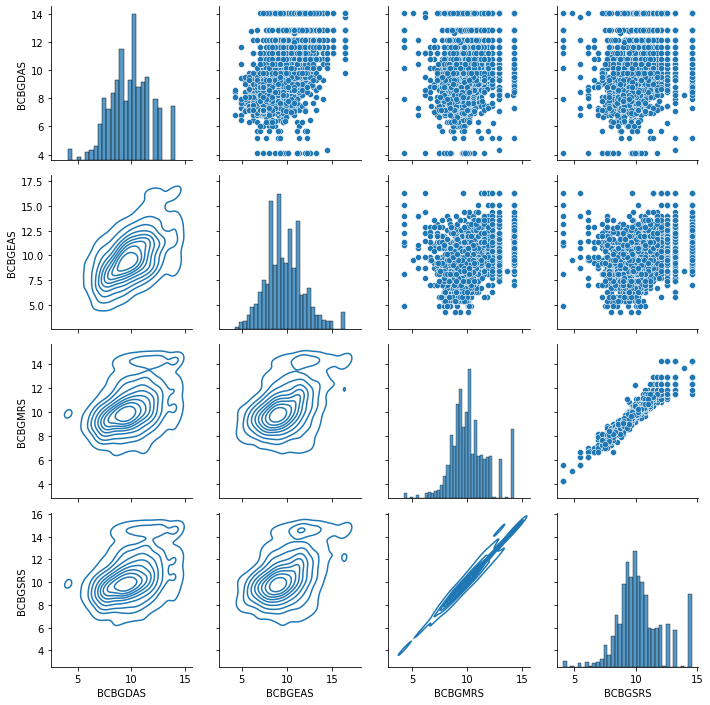

In [24]:
# plot the relationships between discipline, academics, and shortages
g = sns.PairGrid(school.loc[:,[col for col in school.columns if 'BCBG' in col]])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower maps show concentration of relational information
g.map_lower(sns.kdeplot)
# examine distribution of scores along the diagonal
g.map_diag(sns.histplot)

**Initial Observations about `school` dataset:**
* School discipline problems and focus on academic success do not seem correlated with each other or resource shortages
* Math and science resource shortages are strongly correlated; schools seem to be investing or struggling in both math and science equally
* There are many schools with hardly any struggles with discipline or resources, while most other schools are spread equally across the spectrum

**`school` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL to integers
* Convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals
* rename all columns to be more descriptive
* merge with student performance by school

In [25]:
# investigate student assessment (stud_ach) dataframe
stud_ach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BNRGCAL1  \
0     36.0  Booklet 01    5001.0  500101.0  50010101.0      Yes   
1     36.0  Booklet 02    5001.0  500101.0  50010102.0      Yes   
2     36.0  Booklet 04    5001.0  500101.0  50010104.0      Yes   
3     36.0  Booklet 05    5001.0  500101.0  50010105.0      Yes   
4     36.0  Booklet 07    5001.0  500101.0  50010107.0      Yes   

                                    BNRGCAL2  IDPOP     IDGRADER  IDGRADE  \
0   very little (for fewer than 5 questions)  Pop 2  Upper Grade  Grade 8   
1                                 not at all  Pop 2  Upper Grade  Grade 8   
2   very little (for fewer than 5 questions)  Pop 2  Upper Grade  Grade 8   
3   very little (for fewer than 5 questions)  Pop 2  Upper Grade  Grade 8   
4  somewhat (for between 5 and 10 questions)  Pop 2  Upper Grade  Grade 8   

  ITLANG_SA              LCID_SA   ITSEX  BSDAGE             ITADMINI  \
0   English  English (Australia)  Female   13.50  Teacher from School   
1   English  English (Australia)    Male   14.33  Teacher from School   
2   English  English (Australia)    Male   13.83  Teacher from School   
3   English  English (Australia)  Female   14.08  Teacher from School   
4   English  English (Australia)  Female   13.83  Teacher from School   

                                            ILRELIAB  MP52024_val  \
0  Students Booklet not used for Reliability Scoring          1.0   
1  Students Booklet was used for Reliability Scoring          NaN   
2  Students Booklet not used for Reliability Scoring          NaN   
3  Students Booklet not used for Reliability Scoring          NaN   
4  Students Booklet was used for Reliability Scoring          NaN   

   MP52058_val  MP52125_val  MP52229_val  MP52063_val  MP52072_val  \
0          1.0          0.0          NaN          0.0          0.0   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52146_val  MP52092_val  MP52046_val  MP52083_val  MP52082_val  \
0          0.0          0.0          1.0          0.0          1.0   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP52161_val  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
0          1.0          0.0          0.0          1.0          NaN   
1          NaN          NaN          0.0          1.0          1.0   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72190_val  MP72068_val  MP72076_val  MP72056_val  MP72098_val  \
0          0.0          1.0          0.0          1.0          NaN   
1          1.0          1.0          1.0          0.0          1.0   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72103_val  MP72121_val  MP72180_val  MP72198_val  MP72227_val  \
0          1.0          1.0          0.0          NaN          0.0   
1          1.0          1.0          1.0          1.0          1.0   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   MP72170_val  MP72209_val  MP62005_val  MP62139_val  MP62164_val  \
0          1.0          NaN          NaN          NaN          NaN   
1          1.0          1.0          0

In [26]:
# create a list to drop all null columns and any columns that online contain one unique entry
stud_ach_drop_new = list(stud_ach.columns[stud_ach.isna().all()])+list(stud_ach.columns[stud_ach.nunique()==1])

In [27]:
# display descriptive statisticis for quantitative columns in the dataframe
stud_ach.describe()

IDCNTRY      IDSCHOOL        IDCLASS        IDSTUD        BSDAGE  \
count  65970.000000  65970.000000   65970.000000  6.597000e+04  65661.000000   
mean     527.106988   5159.402122  515943.702046  5.159439e+07     14.554154   
std      280.052543    125.347847   12534.606705  1.253463e+06      1.012007   
min       36.000000   5001.000000  500101.000000  5.001010e+07      9.250000   
25%      376.000000   5064.000000  506401.000000  5.064012e+07     13.920000   
50%      620.000000   5130.000000  513001.000000  5.130012e+07     14.330000   
75%      710.000000   5216.000000  521602.000000  5.216021e+07     14.920000   
max      926.000000   5520.000000  552004.000000  5.520043e+07     19.000000   

       MP52024_val  MP52058_val  MP52125_val  MP52229_val  MP52063_val  \
count  9121.000000  8957.000000  9223.000000  8710.000000  9143.000000   
mean      0.442166     0.227532     0.419820     0.432032     0.380291   
std       0.496671     0.419262     0.493556     0.495387     0.485485   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP52072_val  MP52146_val  MP52092_val  MP52046_val  MP52083_val  \
count  9240.000000  8873.000000  9091.000000  9063.000000  8860.000000   
mean      0.553139     0.170292     0.259377     0.299790     0.324605   
std       0.497195     0.375910     0.438317     0.458191     0.468253   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP52082_val  MP52161_val  MP52418_val  MP72007_val  MP72025_val  \
count  9153.000000  9022.000000  9025.000000  9210.000000  9093.000000   
mean      0.484650     0.601862     0.216731     0.134636     0.435170   
std       0.499792     0.489541     0.412041     0.341353     0.495807   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     1.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     0.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP72017_val  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
count  7871.000000  8710.000000  9165.000000  9103.000000  8248.000000   
mean      0.183077     0.526521     0.569231     0.406459     0.358875   
std       0.386754     0.499325     0.495211     0.491199     0.479699   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     1.000000     1.000000     0.000000     0.000000   
75%       0.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       MP72098_val  MP72103_val  MP72121_val  MP72180_val  MP72198_val  \
count  8262.000000  8968.000000  8755.000000  8939.000000  8198.000000   
mean      0.217260     0.450714     0.508852     0.399038     0.329837   
std       0.412406     0.497593     0.499950     0.489728     0.470182   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     1.000000     0.000000     0.000000   
75%       0.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000

In [28]:
# display the datatype for all columsn that are not averages or standard deviations of scores
stud_ach.loc[:,[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col]].dtypes

IDCNTRY      float64
IDBOOK        object
IDSCHOOL     float64
IDCLASS      float64
IDSTUD       float64
BNRGCAL1      object
BNRGCAL2      object
IDPOP         object
IDGRADER      object
IDGRADE       object
ITLANG_SA     object
LCID_SA       object
ITSEX         object
BSDAGE       float64
ITADMINI      object
ILRELIAB      object
dtype: object

In [29]:
# display the label information for every code that is not an assessment item
stud_ach_codes.loc[[col for col in stud_ach.columns if '_val' not in col and '_avg' not in col and '_sd' not in col],:]

Label
Variable                                                  
IDCNTRY                      Country ID - Numeric ISO Code
IDBOOK                                Student Test Booklet
IDSCHOOL                                         School ID
IDCLASS                                           Class ID
IDSTUD                                          Student ID
BNRGCAL1               CALCULATOR SURVEY\USE OF CALCULATOR
BNRGCAL2   CALCULATOR SURVEY\FREQUENCY OF USING CALCULATOR
IDPOP                                        Population ID
IDGRADER                             Standardized Grade ID
IDGRADE                                           Grade ID
ITLANG_SA             Language of Student Achievement Test
LCID_SA              Locale ID of Student Achievement Test
ITSEX                                      Sex of Students
BSDAGE                                        Students Age
ITADMINI                       Test Administrator Position
ILRELIAB                         Reliability Coding Status

In [30]:
# add additional nonrelevant information to be dropped
stud_ach_drop_new = stud_ach_drop_new+['BNRGCAL1','BNRGCAL2','ITADMINI','ILRELIAB']
stud_ach_drop_new

['MP62342_val',
 'MP72038_val',
 'MP62048_val',
 'SP62272_val',
 'SP52221_val',
 'SP72133_val',
 'SP72048_val',
 'SP62036_val',
 'SP72906_val',
 'SP72329_val',
 'SP62266_val',
 'IDPOP',
 'IDGRADER',
 'BNRGCAL1',
 'BNRGCAL2',
 'ITADMINI',
 'ILRELIAB']

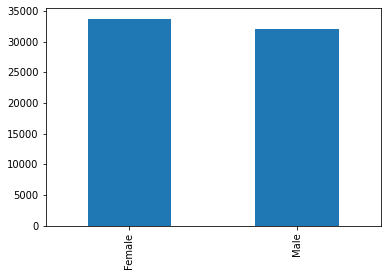

In [31]:
# graph the different counts of gender in the dataset
stud_ach['ITSEX'].value_counts().plot(kind='bar');

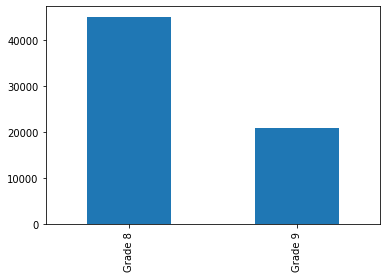

In [32]:
# graph the different counts of 8th graders vs. 9th graders
stud_ach['IDGRADE'].value_counts().plot(kind='bar');

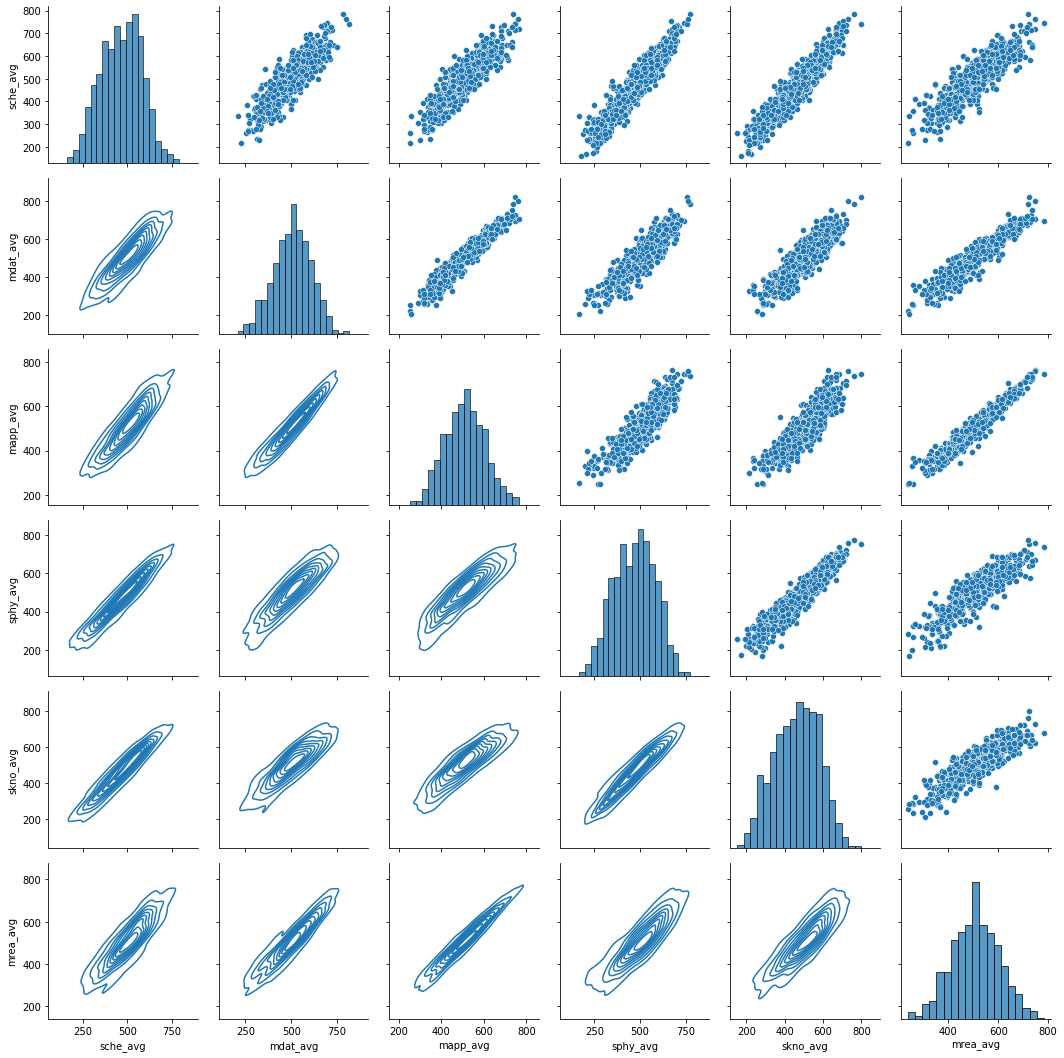

In [33]:
# plot distributions and relationships for a random sample of 1000 students and scores in 6 random categories
g = sns.PairGrid(stud_ach.sample(1000).loc[:,random.sample([col for col in stud_ach.columns if '_avg' in col],6)])
# upper graphs show possible correlations
g.map_upper(sns.scatterplot)
# lower graphs show concentration of the correlation data
g.map_lower(sns.kdeplot)
# the diagonal graphs show the distribution of the scores in the 6 categories
g.map_diag(sns.histplot)

**Initial Observations about `stud_ach` dataset:**
* All mathematical understanding is closely related (strong correlation)
* All science understanding is closely related (strong correlation)
* The relationship between science and math has more variance - is this due to subject differences or the difference in teaching?

**`stud_ach` Data Preparation**
* drop unnecessary (or null) columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK, IDGRADE to integer
* rename all columns to be more descriptive

In [34]:
# explore the basic info for teh student dataframe
student.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01         BSBG03  \
0     36.0  Booklet 01    5001.0  500101.0  50010101.0   Girl         Always   
1     36.0  Booklet 02    5001.0  500101.0  50010102.0    Boy  Almost always   
2     36.0  Booklet 04    5001.0  500101.0  50010104.0    Boy         Always   
3     36.0  Booklet 05    5001.0  500101.0  50010105.0   Girl         Always   
4     36.0  Booklet 07    5001.0  500101.0  50010107.0   Girl         Always   

                                              BSBG04 BSBG05A BSBG05B BSBG05C  \
0             Enough to fill one shelf (11–25 books)     Yes     Yes     Yes   
1                      None or very few (0–10 books)     Yes     Yes     Yes   
2         Enough to fill one bookcase (26–100 books)     Yes     Yes     Yes   
3  Enough to fill three or more bookcases (more t...     Yes     Yes     Yes   
4       Enough to fill two bookcases (101–200 books)     Yes     Yes     Yes   

  BSBG05D BSBG05E BSBG05F BSBG05G BSBG05H BSBG05I  \
0     Yes     Yes     NaN     NaN     NaN     NaN   
1     Yes     Yes     NaN     NaN     NaN     NaN   
2     Yes     Yes     NaN     NaN     NaN     NaN   
3     Yes     Yes     NaN     NaN     NaN     NaN   
4     Yes     Yes     NaN     NaN     NaN     NaN   

                                          BSBG06A  \
0  <Bachelor’s or equivalent level—ISCED Level 6>   
1                                    I don’t know   
2                                    I don’t know   
3                                    I don’t know   
4                                    I don’t know   

                                             BSBG06B  \
0  <Post-secondary, non-tertiary education—ISCED ...   
1                                       I don’t know   
2                                       I don’t know   
3                                       I don’t know   
4                                                NaN   

                                              BSBG07 BSBG08A BSBG08B BSBG09A  \
0  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
1   Finish <Upper secondary education—ISCED Level 3>     Yes      No     Yes   
2  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
3  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     Yes     Yes   
4  Finish <Bachelor’s or equivalent level—ISCED L...     Yes     NaN     Yes   

  BSBG09B                 BSBG10           BSBG11A           BSBG11B BSBG12A  \
0     NaN  Never or almost never         Sometimes             Never     Yes   
1     NaN  Never or almost never         Sometimes             Never     Yes   
2     NaN  Never or almost never  Almost every day  Almost every day     Yes   
3     NaN  Never or almost never  Almost every day         Sometimes     Yes   
4     NaN  Never or almost never         Sometimes             Never     Yes   

  BSBG12B BSBG12C BSBG12D BSBG12E BSBG12F  IDPOP  IDGRADE ITLANG_SQ  \
0     Yes     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English   
1     Yes      No      No     Yes      No  Pop 2  Grade 8   English   
2     Yes     Yes     Yes      No     Yes  Pop 2  Grade 8   English   
3     Yes     Yes     Yes      No      No  Pop 2  Grade 8   English   
4     Yes     Yes     Yes     Yes     Yes  Pop 2  Grade 8   English   

               LCID_SQ ITLANG_SA              LCID_SA   ITSEX  BSDAGE  \
0  English (Australia)   English  English (Australia)  Female   13.50   
1  English (Australia)   English  English (Australia)    Male   14.33   
2  English (Australia)   English  English (Australia)    Male   13.83   
3  English (Australia)   English  English (Australia)  Female   14.08   
4  English (Australia)   English  English (Australia)  Female   13.83   

    BSBGHER         BSDGHER   BSBGSSB                           BSDGSSB  \
0  10.84499  Some Resources   8.46096    Some Sense of School Belonging   
1   8.99877  Some Resources   8.08091    Some Sense of School Belonging   
2  11.19079  

In [35]:
# create a list to drop all empty or unnecessary columns (containing only one value)
student_drop_new = list(student.columns[student.isna().all()])+list(student.columns[student.nunique()==1])

In [36]:
# display the basic quality information for the student dataframe
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65970 entries, 0 to 65969
Data columns (total 93 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IDCNTRY    65970 non-null  float64
 1   IDBOOK     65970 non-null  object 
 2   IDSCHOOL   65970 non-null  float64
 3   IDCLASS    65970 non-null  float64
 4   IDSTUD     65970 non-null  float64
 5   BSBG01     65327 non-null  object 
 6   BSBG03     65023 non-null  object 
 7   BSBG04     64863 non-null  object 
 8   BSBG05A    64830 non-null  object 
 9   BSBG05B    64736 non-null  object 
 10  BSBG05C    61095 non-null  object 
 11  BSBG05D    64504 non-null  object 
 12  BSBG05E    64796 non-null  object 
 13  BSBG05F    52099 non-null  object 
 14  BSBG05G    46386 non-null  object 
 15  BSBG05H    39136 non-null  object 
 16  BSBG05I    35913 non-null  object 
 17  BSBG06A    63212 non-null  object 
 18  BSBG06B    62916 non-null  object 
 19  BSBG07     63645 non-null  object 
 20  BSBG08

In [37]:
# display descriptive statistics of the quantitative information of the student dataframe
student.describe()

IDCNTRY      IDSCHOOL        IDCLASS        IDSTUD        BSDAGE  \
count  65970.000000  65970.000000   65970.000000  6.597000e+04  65661.000000   
mean     527.106988   5159.402122  515943.702046  5.159439e+07     14.554154   
std      280.052543    125.347847   12534.606705  1.253463e+06      1.012007   
min       36.000000   5001.000000  500101.000000  5.001010e+07      9.250000   
25%      376.000000   5064.000000  506401.000000  5.064012e+07     13.920000   
50%      620.000000   5130.000000  513001.000000  5.130012e+07     14.330000   
75%      710.000000   5216.000000  521602.000000  5.216021e+07     14.920000   
max      926.000000   5520.000000  552004.000000  5.520043e+07     19.000000   

            BSBGHER       BSBGSSB        BSBGSB       BSBGSLM       BSBGICM  \
count  63926.000000  64648.000000  60941.000000  64679.000000  64541.000000   
mean      10.122270      9.797088      9.480006      9.937666     10.016225   
std        1.713038      1.918135      1.928911      1.900121      1.982165   
min        4.552080      3.924400      1.953440      5.094840      3.695680   
25%        9.036130      8.460960      8.093670      8.761390      8.518960   
50%       10.238350      9.408010      9.285930      9.866380      9.926750   
75%       11.190790     10.709560     10.418030     11.148590     11.651150   
max       13.515430     13.271990     12.937340     13.848490     13.018850   

            BSBGDML       BSBGSCM       BSBGSVM       BSBGSLS       BSBGICS  \
count  64412.000000  64330.000000  64167.000000  56219.000000  56053.000000   
mean       9.654635      9.855672     10.046370      9.853294      9.865855   
std        2.016351      2.065821      1.995111      1.957952      1.970738   
min        5.566330      3.277930      3.036820      3.846500      4.022730   
25%        8.444350      8.761680      8.578290      8.493940      8.528200   
50%        9.711010      9.672300      9.980680      9.572190      9.890780   
75%       10.674990     10.849510     11.301900     11.064140     11.431060   
max       14.673710     15.851880     13.482930     13.517780     12.633860   

            BSBGSCS       BSBGSVS      BSBGSLB      BSBGICB      BSBGSCB  \
count  55923.000000  63551.000000  7860.000000  7802.000000  7789.000000   
mean       9.846483      9.946323    10.323129    10.241666    10.035638   
std        1.901966      1.904309     2.022723     2.030418     2.031045   
min        3.249920      4.283400     3.770330     3.805730     3.049750   
25%        8.873810      8.612800     8.868440     8.805370     8.768360   
50%        9.615810      9.669500    10.095240    10.378180     9.628410   
75%       10.701970     11.354160    11.404230    11.547870    10.979050   
max       14.841820     12.936700    13.864760    12.776070    14.925630   

           BSBGSLE      BSBGICE      BSBGSCE      BSBGSLC      BSBGICC  \
count  3330.000000  3325.000000  3325.000000  7869.000000  7832.000000   
mean     10.712933    10.246788    10.058352    10.359569    10.282164   
std       1.947171     1.811098     1.842337     1.938823     2.008786   
min       4.020150     4.198000     3.210940     4.381810     4.449820   
25%       9.382580     8.945040     8.807510     9.178520     9.026240   
50%      10.363410    10.510120     9.665740    10.056960    10.527730   
75%      12.112890    11.608490    11.013050    11.494970    12.636810   
max      14.057380    12.753610    14.910220    13.776840    12.636810   

           BSBGSCC      BSBGSLP      BSBGICP      BSBGSCP       BSBGSEC  
count  7819.000000  7834.000000  7800.000000  7771.000000  26549.000000  
mean     10.259290    10.399357    10.302456    10.300245     10.261077  
std       2.005416     1.940148     1.989773     2.019097      1.844268  
min       3.896350     4.500520     4.575930     3.904790      3.210100  
25%       9.274000     9.145480     8.774900     9.166940      8.991280  
50%       9.767540    10.223820    10.591630     9.912420     10.168600

In [38]:
# display the contextual information for each column
student_codes.loc[student.columns,:]

Label
IDCNTRY                        Country ID - Numeric ISO Code
IDBOOK                                  Student Test Booklet
IDSCHOOL                                           School ID
IDCLASS                                             Class ID
IDSTUD                                            Student ID
BSBG01                                    GEN\SEX OF STUDENT
BSBG03                GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
BSBG04                      GEN\AMOUNT OF BOOKS IN YOUR HOME
BSBG05A                     GEN\HOME POSSESS\COMPUTER TABLET
BSBG05B                          GEN\HOME POSSESS\STUDY DESK
BSBG05C                            GEN\HOME POSSESS\OWN ROOM
BSBG05D                 GEN\HOME POSSESS\INTERNET CONNECTION
BSBG05E                    GEN\HOME POSSESS\OWN MOBILE PHONE
BSBG05F                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05G                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05H                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG05I                  GEN\HOME POSSESS\<COUNTRY SPECIFIC>
BSBG06A        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
BSBG06B        GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN B>
BSBG07                GEN\HOW FAR IN EDU DO YOU EXPECT TO GO
BSBG08A            GEN\<PARENT/GUARDIAN A> BORN IN <COUNTRY>
BSBG08B            GEN\<PARENT/GUARDIAN B> BORN IN <COUNTRY>
BSBG09A                                GEN\BORN IN <COUNTRY>
BSBG09B            GEN\BORN IN <COUNTRY>\AGE CAME TO COUNTRY
BSBG10                GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
BSBG11A                                  GEN\HOW OFTEN\TIRED
BSBG11B                                 GEN\HOW OFTEN\HUNGRY
BSBG12A                    GEN\INTERNET USE\ACCESS TEXTBOOKS
BSBG12B                  GEN\INTERNET USE\ACCESS ASSIGNMENTS
BSBG12C         GEN\INTERNET USE\COLLABORATE WITH CLASSMATES
BSBG12D            GEN\INTERNET USE\COMMUNICATE WITH TEACHER
BSBG12E     GEN\INTERNET USE\FIND INFO TO AID IN MATH OR SCI
BSBG12F               GEN\INTERNET USE\ACCESS LEARNING GAMES
IDPOP                                          Population ID
IDGRADE                                             Grade ID
ITLANG_SQ          Language of Student Context Questionnaire
LCID_SQ           Locale ID of Student Context Questionnaire
ITLANG_SA               Language of Student Achievement Test
LCID_SA                Locale ID of Student Achievement Test
ITSEX                                        Sex of Students
BSDAGE                                          Students Age
BSBGHER                       Home Educational Resources/SCL
BSDGHER                       Home Educational Resources/IDX
BSBGSSB               Students Sense of School Belonging/SCL
BSDGSSB               Students Sense of School Belonging/IDX
BSBGSB                                  Student Bullying/SCL
BSDGSB                                  Student Bullying/IDX
BSBGSLM       Students Like Learning Mathematics Lessons/SCL
BSDGSLM       Students Like Learning Mathematics Lessons/IDX
BSBGICM     Instructional Clarity in Mathematics Lessons/SCL
BSDGICM     Instructional Clarity in Mathematics Lessons/IDX
BSBGDML          Disorderly Behavior during Math Lessons/SCL
BSDGDML          Disorderly Behavior during Math Lessons/IDX
BSBGSCM                 Student Confident in Mathematics/SCL
BSDGSCM                 Student Confident in Mathematics/IDX
BSBGSVM                       Students Value Mathematics/SCL
BSDGSVM                       Students Value Mathematics/IDX
BSBGSLS                   Students Like Learning Science/SCL
BSDGSLS                   Students Like Learning Science/IDX
BSBGICS         Instructional Clarity in Science Lessons/SCL
BSDGICS         Instructional Clarity in Science Lessons/IDX
BSBGSCS                     Student Confident in Science/SCL
BSDGSCS                     Student Confident in Science/IDX
BSBGSVS                           Students Value Science/SCL
BSDGSVS                           Students Value Science/IDX
BSBGSLB                   Stu

In [39]:
# investigate the unique entries on some of the qualitative data
student['BSDGSB'].unique()

array(['About Monthly', 'Never or Almost Never', nan, 'About Weekly'],
      dtype=object)

In [40]:
# investigate some of the data that appears to have two different languages
student.query('ITLANG_SQ != ITLANG_SA and ITLANG_SQ == ITLANG_SQ')

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD BSBG01  \
17478    376.0  Booklet 13    5041.0  504105.0  50410514.0   Girl   
28517    422.0  Booklet 08    5008.0  500801.0  50080101.0   Girl   
28521    422.0  Booklet 06    5008.0  500801.0  50080113.0    Boy   
28735    422.0  Booklet 07    5018.0  501801.0  50180102.0    Boy   
29102    422.0  Booklet 10    5032.0  503201.0  50320102.0    Boy   
29343    422.0  Booklet 06    5041.0  504101.0  50410106.0   Girl   
29692    422.0  Booklet 03    5054.0  505403.0  50540315.0    Boy   
29797    422.0  Booklet 01    5058.0  505801.0  50580115.0    Boy   
30715    422.0  Booklet 06    5103.0  510302.0  51030215.0   Girl   
30941    422.0  Booklet 07    5114.0  511401.0  51140104.0   Girl   
30976    422.0  Booklet 14    5115.0  511503.0  51150315.0    Boy   
31926    422.0  Booklet 03    5157.0  515701.0  51570102.0    Boy   
31934    422.0  Booklet 01    5157.0  515701.0  51570114.0    Boy   
31948    422.0  Booklet 09    5158.0  515803.0  51580308.0   Girl   
32054    422.0  Booklet 13    5163.0  516302.0  51630201.0   Girl   
32055    422.0  Booklet 14    5163.0  516302.0  51630202.0   Girl   
32063    422.0  Booklet 09    5163.0  516302.0  51630211.0   Girl   
32064    422.0  Booklet 10    5163.0  516302.0  51630212.0   Girl   
32068    422.0  Booklet 14    5163.0  516302.0  51630216.0   Girl   
32072    422.0  Booklet 04    5163.0  516302.0  51630220.0   Girl   
32074    422.0  Booklet 06    5163.0  516302.0  51630222.0   Girl   
32076    422.0  Booklet 08    5163.0  516302.0  51630224.0   Girl   
32078    422.0  Booklet 10    5163.0  516302.0  51630226.0   Girl   
32079    422.0  Booklet 11    5163.0  516302.0  51630227.0   Girl   
32145    422.0  Booklet 10    5166.0  516605.0  51660508.0   Girl   
32161    422.0  Booklet 12    5166.0  516605.0  51660524.0    Boy   
32385    422.0  Booklet 14    5175.0  517504.0  51750424.0   Girl   
32969    422.0  Booklet 10    5201.0  520101.0  52010104.0   Girl   
32970    422.0  Booklet 11    5201.0  520101.0  52010105.0    Boy   
51725    710.0  Booklet 10    5170.0  517003.0  51700317.0    Boy   

              BSBG03                                             BSBG04  \
17478      Sometimes             Enough to fill one shelf (11–25 books)   
28517      Sometimes                      None or very few (0–10 books)   
28521          Never                      None or very few (0–10 books)   
28735      Sometimes                      None or very few (0–10 books)   
29102  Almost always             Enough to fill one shelf (11–25 books)   
29343      Sometimes             Enough to fill one shelf (11–25 books)   
29692          Never                      None or very few (0–10 books)   
29797      Sometimes                      None or very few (0–10 books)   
30715      Sometimes         Enough to fill one bookcase (26–100 books)   
30941          Never                      None or very few (0–10 books)   
30976      Sometimes         Enough to fill one bookcase (26–100 books)   
31926      Sometimes       Enough to fill two bookcases (101–200 books)   
31934          Never             Enough to fill one shelf (11–25 books)   
31948      Sometimes                      None or very few (0–10 books)   
32054          Never                      None or very few (0–10 books)   
32055          Never                      None or very few (0–10 books)   
32063          Never                      None or very few (0–10 books)   
32064          Never                      None or very few (0–10 books)   
32068          Never                      None or very few (0–10 books)   
32072      Sometimes                      None or very few (0–10 books)   
32074      Sometimes                      None or very few (0–10 books)   
32076          Never                      None or very few (0–10 books)   
32078      Sometimes                      None or very few (0–10 books)   
32079      Sometimes                      None or very few (0–10 bo

In [41]:
# add additional nonrelevant data to be dropped from the dataframe
student_drop_new = student_drop_new + ['BSBG01','LCID_SQ','LCID_SA']

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


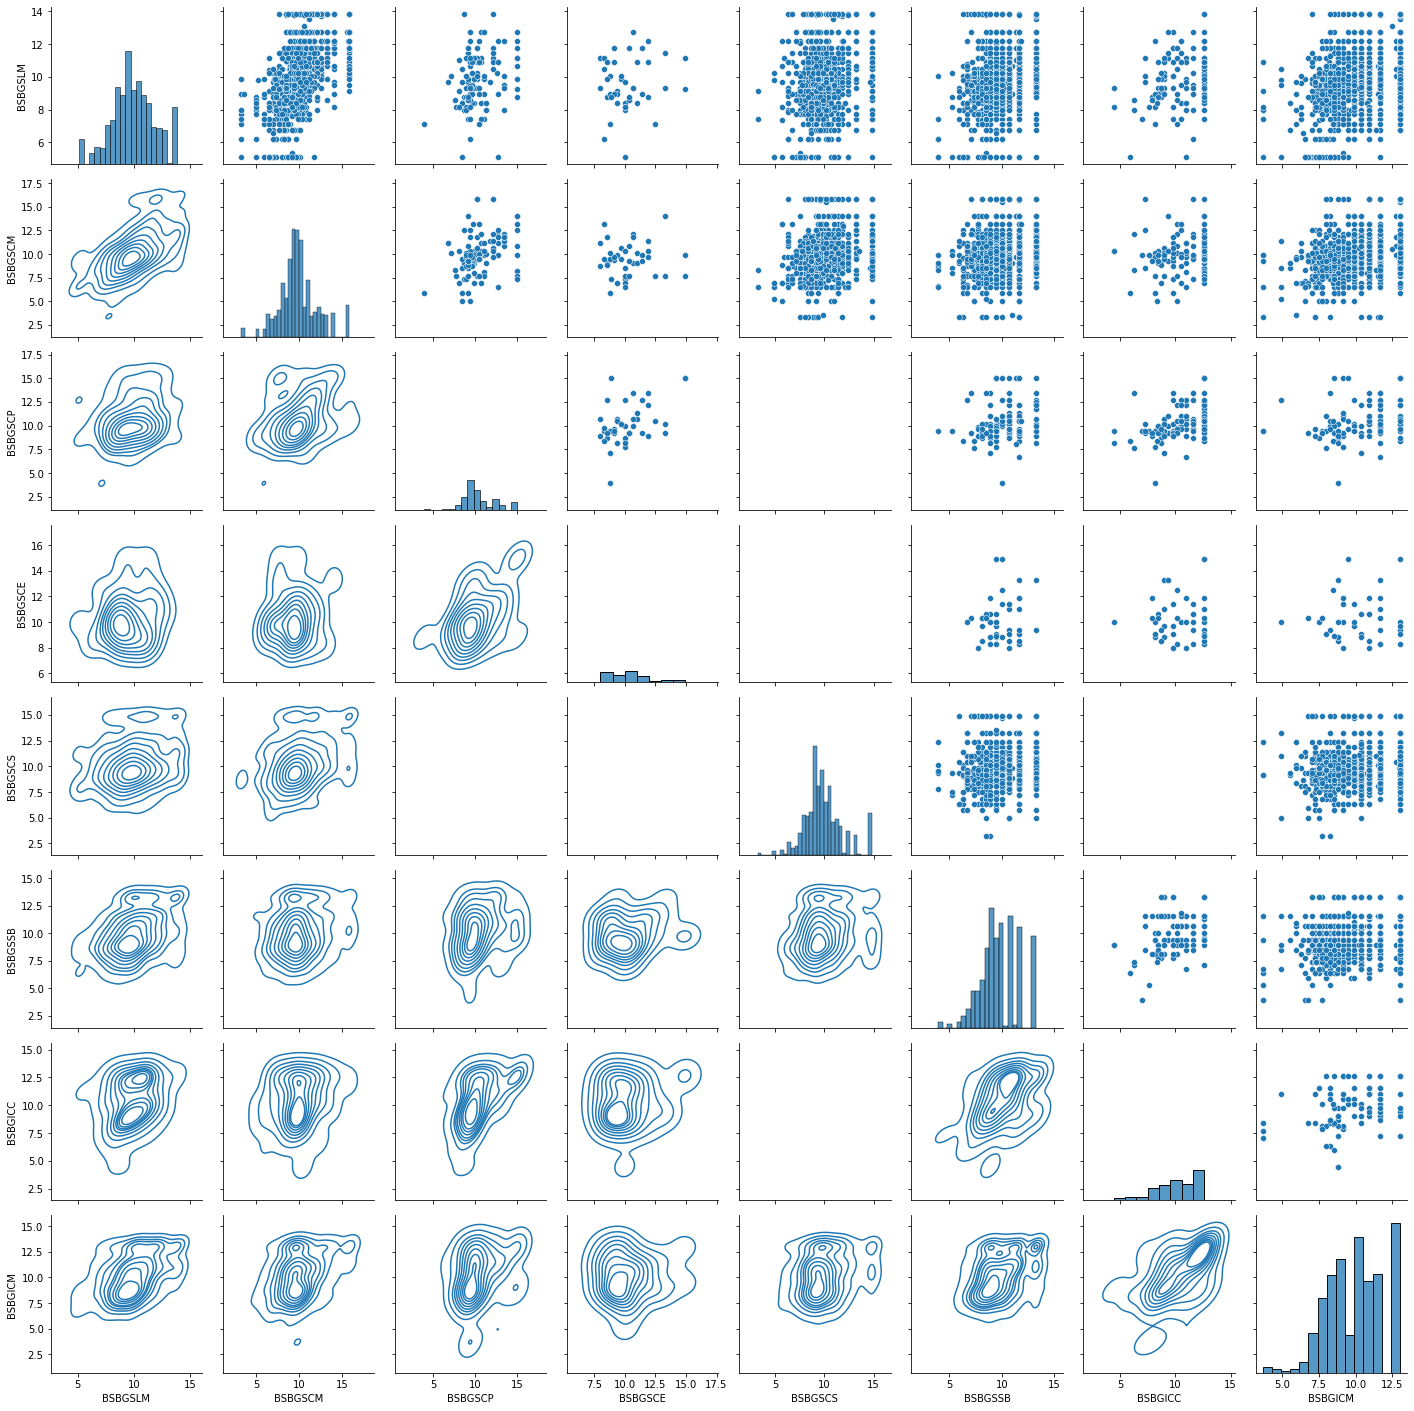

In [42]:
# visualize the relationships between a selection of the available scores for student demographics (1000 randomly sampled students, 8 random sampled variables)
g = sns.PairGrid(student.sample(1000).loc[:,random.sample([col for col in student.columns if 'BSBG' in col and student[col].dtype == 'float64'],8)])
# upper graphs will show correlation
g.map_upper(sns.scatterplot)
# lower graphs will show data concentration
g.map_lower(sns.kdeplot)
# diagonal graphs will show the distribution of each variable
g.map_diag(sns.histplot)

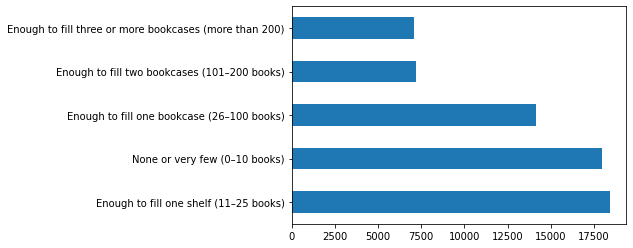

In [43]:
# visualize the number of books at home for each student
student['BSBG04'].value_counts().plot(kind='barh');

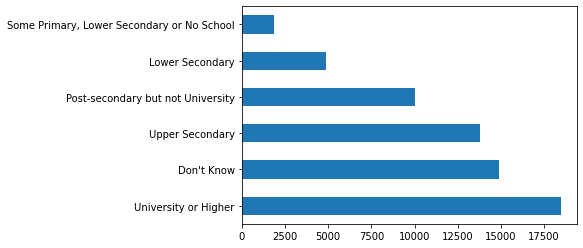

In [44]:
# visualize the highest level of education achieved by the parents of the student
student['BSDGEDUP'].value_counts().plot(kind='barh');

**Initial Observations about `student` dataset:**
* Apparent correlation between instructional clarity across all science classes (possible link to instructional quality at the school level)
* Wide variance in the number of books in the home
* Wide variance in highest parental education, but university is most common

**`student` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK, IDGRADE to integers
* convert to integer and combine BSBG05* columns to home_possession column
* convert to integer and combine BSBG09* columns to age_immigration column
* convert to integer and combine BSBG12* columns to internet_access column
* convert BSBG03, BSBG04, BSBG10, BSBG11*, BSDG* columns to ordered categoricals
* trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)
* convert BSBG08* to boolean
* rename all columns to be more descriptive
* merge with student performance

In [45]:
# explore basic structure of stud_teach dataset
stud_teach.head()

IDCNTRY      IDBOOK  IDSCHOOL   IDCLASS      IDSTUD    IDTEALIN   IDTEACH  \
0     36.0  Booklet 01    5001.0  500101.0  50010101.0  50010101.0  500101.0   
1     36.0  Booklet 01    5001.0  500101.0  50010101.0  50010202.0  500102.0   
2     36.0  Booklet 02    5001.0  500101.0  50010102.0  50010202.0  500102.0   
3     36.0  Booklet 02    5001.0  500101.0  50010102.0  50010101.0  500101.0   
4     36.0  Booklet 04    5001.0  500101.0  50010104.0  50010101.0  500101.0   

   IDLINK  IDPOP  IDGRADE       IDSUBJ            ITCOURSE  NMTEACH  NSTEACH  \
0     1.0  Pop 2  Grade 8  Mathematics         Mathematics      1.0      1.0   
1     2.0  Pop 2  Grade 8      Science  Integrated science      1.0      1.0   
2     2.0  Pop 2  Grade 8      Science  Integrated science      1.0      1.0   
3     1.0  Pop 2  Grade 8  Mathematics         Mathematics      1.0      1.0   
4     1.0  Pop 2  Grade 8  Mathematics         Mathematics      1.0      1.0   

     mmat_avg    ssci_avg    malg_avg    mapp_avg    mdat_avg    mgeo_avg  \
0  521.775890  626.073722  492.435708  521.907622  533.820044  519.207508   
1  521.775890  626.073722  492.435708  521.907622  533.820044  519.207508   
2  632.502098  642.944544  600.155196  633.667702  676.211410  632.017586   
3  632.502098  642.944544  600.155196  633.667702  676.211410  632.017586   
4  574.655188  598.487760  556.771504  590.805462  576.951352  576.566214   

     mkno_avg    mnum_avg    mrea_avg    sapp_avg    sbio_avg    sche_avg  \
0  506.730000  523.239952  538.931210  631.463462  637.569672  596.303608   
1  506.730000  523.239952  538.931210  631.463462  637.569672  596.303608   
2  627.151892  657.800010  631.303296  683.522612  610.090716  582.720568   
3  627.151892  657.800010  631.303296  683.522612  610.090716  582.720568   
4  573.946676  572.707262  579.456716  627.294346  606.428020  607.501518   

     sear_avg    skno_avg    sphy_avg    srea_avg  
0  616.275214  616.598232  599.831082  588.988580  
1  616.275214  616.598232  599.831082  588.988580  
2  635.104204  654.275566  661.463838  633.074080  
3  635.104204  654.275566  661.463838  633.074080  
4  598.778342  592.518718  623.248506  610.629216

In [46]:
# create a list of columns to drop because they are null or have only one value
stud_teach_drop_new = list(stud_teach.columns[stud_teach.isna().all()])+list(stud_teach.columns[stud_teach.nunique()==1])

In [47]:
# also drop IDBOOK column
stud_teach_drop_new = stud_teach_drop_new + ['IDBOOK']

In [48]:
# investigate how many unique values each variable contains
stud_teach.nunique()

IDCNTRY        10
IDBOOK         14
IDSCHOOL      519
IDCLASS      1714
IDSTUD      48430
IDTEALIN     2632
IDTEACH      2123
IDLINK         21
IDPOP           1
IDGRADE         2
IDSUBJ          2
ITCOURSE        7
NMTEACH         4
NSTEACH         5
mmat_avg    65965
ssci_avg    65963
malg_avg    45135
mapp_avg    45139
mdat_avg    45139
mgeo_avg    45137
mkno_avg    45137
mnum_avg    45136
mrea_avg    45134
sapp_avg    65962
sbio_avg    65965
sche_avg    65959
sear_avg    65959
skno_avg    65958
sphy_avg    65963
srea_avg    65965
dtype: int64

In [49]:
# display summary information about stud_teach dataframe
stud_teach.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150551 entries, 0 to 150550
Data columns (total 30 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   IDCNTRY   150551 non-null  float64
 1   IDBOOK    150551 non-null  object 
 2   IDSCHOOL  150551 non-null  float64
 3   IDCLASS   150551 non-null  float64
 4   IDSTUD    150551 non-null  float64
 5   IDTEALIN  150551 non-null  float64
 6   IDTEACH   150551 non-null  float64
 7   IDLINK    150551 non-null  float64
 8   IDPOP     150551 non-null  object 
 9   IDGRADE   150551 non-null  object 
 10  IDSUBJ    150551 non-null  object 
 11  ITCOURSE  150551 non-null  object 
 12  NMTEACH   150551 non-null  float64
 13  NSTEACH   150551 non-null  float64
 14  mmat_avg  150551 non-null  float64
 15  ssci_avg  150551 non-null  float64
 16  malg_avg  108312 non-null  float64
 17  mapp_avg  108312 non-null  float64
 18  mdat_avg  108312 non-null  float64
 19  mgeo_avg  108312 non-null  float64
 20  mkno

In [50]:
# display summary statistics about the quantitative variables of stud_teach
stud_teach.describe()

IDCNTRY       IDSCHOOL        IDCLASS        IDSTUD  \
count  150551.000000  150551.000000  150551.000000  1.505510e+05   
mean      515.625854    5152.087034  515212.061720  5.152122e+07   
std       269.120470     121.660487   12165.952956  1.216598e+06   
min        36.000000    5001.000000  500101.000000  5.001010e+07   
25%       380.000000    5060.000000  506009.000000  5.060090e+07   
50%       620.000000    5124.000000  512402.000000  5.124022e+07   
75%       710.000000    5202.000000  520203.000000  5.202033e+07   
max       926.000000    5520.000000  552004.000000  5.520043e+07   

           IDTEALIN        IDTEACH         IDLINK        NMTEACH  \
count  1.505510e+05  150551.000000  150551.000000  150551.000000   
mean   5.152109e+07  515210.836095       2.239168       1.056911   
std    1.216583e+06   12165.836918       2.136876       0.278159   
min    5.001010e+07  500101.000000       1.000000       1.000000   
25%    5.060040e+07  506004.000000       1.000000       1.000000   
50%    5.124020e+07  512402.000000       2.000000       1.000000   
75%    5.202020e+07  520202.000000       3.000000       1.000000   
max    5.520030e+07  552003.000000      53.000000       4.000000   

             NSTEACH       mmat_avg       ssci_avg       malg_avg  \
count  150551.000000  150551.000000  150551.000000  108312.000000   
mean        1.405411     474.769356     467.154750     505.353603   
std         0.738830     100.482081     114.195720      98.042091   
min         0.000000     199.971348     118.179850     170.463434   
25%         1.000000     396.397624     381.853182     433.717839   
50%         1.000000     467.256318     474.946004     500.732595   
75%         2.000000     546.962300     555.486234     572.182234   
max         4.000000     844.245024     811.383202     883.787158   

            mapp_avg       mdat_avg       mgeo_avg       mkno_avg  \
count  108312.000000  108312.000000  108312.000000  108312.000000   
mean      500.491335     495.686850     500.214551     505.606414   
std        99.206329     107.477546     100.488201      94.097778   
min       162.346672     103.868646     121.671972     163.224438   
25%       427.719146     419.120631     426.496406     436.651590   
50%       499.344010     499.129374     497.477414     501.509040   
75%       571.582786     574.062714     572.170334     571.094313   
max       874.593228     850.120382     869.864216     864.777696   

            mnum_avg       mrea_avg       sapp_avg       sbio_avg  \
count  108312.000000  108312.000000  150551.000000  150551.000000   
mean      502.958524     500.232144     469.352189     464.586484   
std        95.099856     100.258489     115.512692     123.388704   
min       162.403816     144.273560      86.910532      61.197396   
25%       432.125506     429.474215     384.684216     374.908263   
50%       499.448832     499.967779     475.067590     476.142760   
75%       570.275472     570.569429     557.725396     560.074564   
max       883.122124     873.466996     814.836836     823.839286   

            sche_avg       sear_avg       skno_avg       sphy_avg  \
count  150551.000000  150551.000000  150551.000000  150551.000000   
mean      465.761502     463.290167     463.455471     466.447805   
std       113.079106     125.875965     115.639539     113.487321   
min        71.579936      14.672014      94.610900      80.839378   
25%       382.319362     371.228696     376.698076     384.414269   
50%       470.391470     473.362432     470.962954     470.128572   
75%       550.902394     561.177570     552.581605     552.033271   
max       840.819638     883.370896     804.026152     813.372414   

            srea_avg  
count  150551.000000  
mean      462.311297  
std       123.147102  
min        58.978432  
25%       374.246046  
50%       474.763088  
75%       558.226536  
max       820.829710

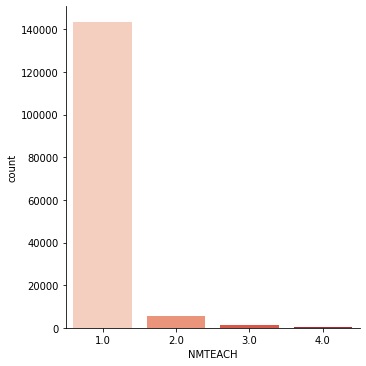

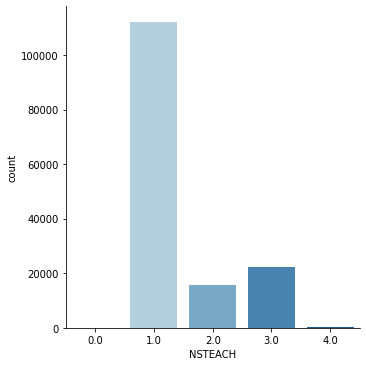

In [51]:
# plot the frequency of number of math and science teachers per individual student
sns.catplot(x='NMTEACH', kind='count', palette='Reds', data=stud_teach);
sns.catplot(x='NSTEACH', kind='count', palette='Blues', data=stud_teach);

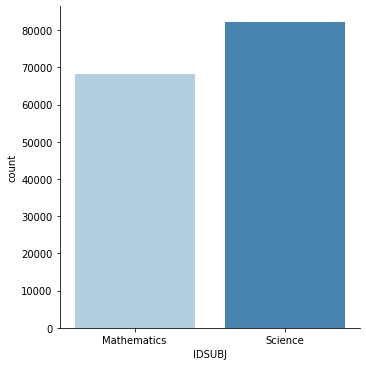

In [52]:
# plot the count of math and science teachers in the dataset
sns.catplot(x="IDSUBJ", kind="count", palette="Blues", data=stud_teach);

**Initial Observations about `stud_teach` dataset:**
* students are morel likey to have multiple science teachers than multiple math teachers
* there are more science teachers in the study than math teachers

**`stud_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers
* trim and convert IDGRADE to integers

In [53]:
# explore basic structure of the math_teach dataframe
math_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK     ITCOURSE  BTBG01  \
0     36.0    5001.0  50010101.0  500101.0     1.0  Mathematics    16.0   
1     36.0    5001.0  50010303.0  500103.0     3.0  Mathematics    13.0   
2     36.0    5002.0  50020101.0  500201.0     1.0  Mathematics    22.0   
3     36.0    5003.0  50030101.0  500301.0     1.0  Mathematics     3.0   
4     36.0    5003.0  50030202.0  500302.0     2.0  Mathematics     1.0   

   BTBG02    BTBG03                                          BTBG04 BTBG05A  \
0    Male     50–59  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   
1    Male     40–49  <Bachelor’s or equivalent level—ISCED Level 6>      No   
2    Male     40–49    <Master’s or equivalent level—ISCED Level 7>     Yes   
3    Male     30–39  <Bachelor’s or equivalent level—ISCED Level 6>     Yes   
4  Female  Under 25    <Master’s or equivalent level—ISCED Level 7>      No   

  BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I    BTBG06A  \
0      No      No      No      No     Yes     Yes     Yes     Yes       High   
1      No      No      No      No     Yes     Yes     Yes      No       High   
2      No     Yes     Yes      No      No      No      No      No       High   
3     Yes      No     Yes      No     Yes     Yes      No      No       High   
4      No      No      No      No     Yes      No      No     Yes  Very high   

     BTBG06B    BTBG06C BTBG06D    BTBG06E    BTBG06F    BTBG06G    BTBG06H  \
0       High       High    High  Very high  Very high  Very high  Very high   
1       High       High  Medium        Low        Low     Medium     Medium   
2       High       High  Medium     Medium       High       High       High   
3       High  Very high    High     Medium     Medium       High       High   
4  Very high        Low  Medium     Medium     Medium        Low        Low   

  BTBG06I    BTBG06J    BTBG06K BTBG06L         BTBG07A      BTBG07B  \
0    High  Very high  Very high  Medium     Agree a lot  Agree a lot   
1  Medium       High     Medium    High     Agree a lot  Agree a lot   
2    High       High     Medium  Medium     Agree a lot  Agree a lot   
3  Medium     Medium       High    High  Agree a little  Agree a lot   
4  Medium     Medium     Medium  Medium  Agree a little  Agree a lot   

          BTBG07C            BTBG07D            BTBG07E            BTBG07F  \
0     Agree a lot     Agree a little  Disagree a little     Agree a little   
1  Agree a little  Disagree a little     Agree a little  Disagree a little   
2     Agree a lot     Agree a little        Agree a lot        Agree a lot   
3  Agree a little     Agree a little     Agree a little  Disagree a little   
4     Agree a lot  Disagree a little     Agree a little     Agree a little   

       BTBG07G            BTBG07H     BTBG08A     BTBG08B     BTBG08C  \
0  Agree a lot        Agree a lot  Very often       Often  Very often   
1  Agree a lot  Disagree a little       Often       Often   Sometimes   
2  Agree a lot        Agree a lot  Very often  Very often  Very often   
3  Agree a lot     Agree a little       Often  Very often  Very often   
4  Agree a lot        Agree a lot  Very often  Very often  Very often   

      BTBG08D     BTBG08E            BTBG09A         BTBG09B  \
0       Often  Very often        Agree a lot     Agree a lot   
1   Sometimes       Often        Agree a lot     Agree a lot   
2  Very often  Very often        Agree a lot  Agree a little   
3  Very often  Very often     Agree a little  Agree a little   
4  Very often  Very often  Disagree a little     Agree a lot   

             BTBG09C         BTBG09D         BTBG09E            BTBG09F  \
0  Disagree a little     Agree a lot  Agree a little     Agree a little   
1     Agree a little  Agree a little     Agree a lot     Disagree a lot   
2     Agree a little  Agree a little  Agree a little  Disagree a little   
3     Agree a little     Agree a lot     Agree a lot  Disagree a little   
4     Agree a little

In [54]:
# create list of math_teach columns to drop (null or single unique value)
math_teach_drop_new = list(math_teach.columns[math_teach.isna().all()])+list(math_teach.columns[math_teach.nunique()==1])

In [55]:
# add a redundant language column to be dropped
math_teach_drop_new = math_teach_drop_new + ['LCID_T']

In [56]:
# display the summary statistics for the quantitative values
math_teach.describe()

IDCNTRY     IDSCHOOL      IDTEALIN        IDTEACH       IDLINK  \
count  3101.000000  3101.000000  3.101000e+03    3101.000000  3101.000000   
mean    497.365366  5136.464044  5.136480e+07  513647.986456     1.637859   
std     281.558611   107.782770  1.077816e+06   10778.157091     1.702021   
min      36.000000  5001.000000  5.001010e+07  500101.000000     1.000000   
25%     376.000000  5057.000000  5.057010e+07  505701.000000     1.000000   
50%     422.000000  5115.000000  5.115010e+07  511501.000000     1.000000   
75%     710.000000  5185.000000  5.185010e+07  518501.000000     2.000000   
max     926.000000  5520.000000  5.520010e+07  552001.000000    51.000000   

            BTBG01       BTBG10       BTBG11      BTBM14      BTBGEAS  \
count  2915.000000  2827.000000  2756.000000  2748.00000  2924.000000   
mean     15.177358    28.269544     4.527576   241.76492     9.876199   
std      10.390477    12.625682     9.973739    76.56078     2.143395   
min       0.000000     1.000000     0.000000     0.00000     0.873410   
25%       6.000000    21.000000     0.000000   200.00000     8.546510   
50%      13.000000    27.000000     0.000000   240.00000     9.749340   
75%      23.000000    33.000000     4.000000   270.00000    11.250980   
max      48.000000   118.000000   105.000000   675.00000    17.780680   

           BTBGLSN      BTBGSOS      BTBGTJS      BTDMNUM      BTDMALG  \
count  2873.000000  2915.000000  2918.000000  2877.000000  2877.000000   
mean      9.661055     9.833788     9.868418    97.926081    71.094395   
std       2.139279     2.220793     1.816070     8.654297    24.366708   
min       3.623690     4.426320     5.281180     0.000000     0.000000   
25%       8.156030     8.396310     8.482860   100.000000    57.142860   
50%       9.619100     9.611530    10.258740   100.000000    71.428570   
75%      10.698650    11.149320    11.745590   100.000000    85.714290   
max      15.295110    13.870350    11.745590   100.000000   100.000000   

           BTDMGEO      BTDMDAT  VERSION  
count  2881.000000  2871.000000   3101.0  
mean     78.767789    61.324742      4.0  
std      21.839129    35.559955      0.0  
min       0.000000     0.000000      4.0  
25%      66.666670    33.333330      4.0  
50%      83.333330    66.666670      4.0  
75%     100.000000   100.000000      4.0  
max     100.000000   100.000000      4.0

In [57]:
# display contextual information for a subset of the math_teach columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG' not in col],:]

Label
Variable                                                   
IDCNTRY                       Country ID - Numeric ISO Code
IDSCHOOL                                          School ID
IDTEALIN                                Teacher ID and Link
IDTEACH                                          Teacher ID
IDLINK                                  Teacher Link Number
ITCOURSE                         Subject Code in instrument
BTBM14                   MATH\TIME SPENT MATH INSTR MINUTES
BTBM15A               MATH\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBM15B              MATH\ASK STUDENTS\EXPLAIN HOW TO SOLVE
BTBM15C                    MATH\ASK STUDENTS\MEMORIZE RULES
BTBM15D               MATH\ASK STUDENTS\PRACTICE PROCEDURES
BTBM15E                MATH\ASK STUDENTS\APPLY WHAT LEARNED
BTBM15F               MATH\ASK STUDENTS\WORK IN WHOLE CLASS
BTBM15G              MATH\ASK STUDENTS\MIXED ABILITY GROUPS
BTBM15H               MATH\ASK STUDENTS\SAME ABILITY GROUPS
BTBM16                    MATH\PERMITTED TO USE CALCULATORS
BTBM17A       MATH\COMPUTER TABLET AVAILABILITY DURING MATH
BTBM17BA    MATH\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBM17BB        MATH\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBM17BC       MATH\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBM17CA       MATH\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBM17CB    MATH\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBM17CC   MATH\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBM17CD     MATH\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBM18AA                        MATH\TOPIC\NUMBER\COMPUTING
BTBM18AB             MATH\TOPIC\NUMBER\CONCEPT OF FRACTIONS
BTBM18AC         MATH\TOPIC\NUMBER\SOLVING PROB PROPORTIONS
BTBM18BA                     MATH\TOPIC\ALGEBRA\SIMPLIFYING
BTBM18BB                MATH\TOPIC\ALGEBRA\LINEAR EQUATIONS
BTBM18BC             MATH\TOPIC\ALGEBRA\LINEAR INEQUALITIES
BTBM18BD           MATH\TOPIC\ALGEBRA\SIMULTANEOUS EQUATION
BTBM18BE                       MATH\TOPIC\ALGEBRA\FUNCTIONS
BTBM18BF             MATH\TOPIC\ALGEBRA\PROPERTIES OF FUNCS
BTBM18BG                         MATH\TOPIC\ALGEBRA\NUMERIC
BTBM18CA           MATH\TOPIC\GEOMETRY\GEOMETRIC PROPERTIES
BTBM18CB        MATH\TOPIC\GEOMETRY\SOLVING PROB PERIMETERS
BTBM18CC       MATH\TOPIC\GEOMETRY\SOLVING PROB PYTHAGOREAN
BTBM18CD                    MATH\TOPIC\GEOMETRY\TRANSLATION
BTBM18CE              MATH\TOPIC\GEOMETRY\CONGRUENT FIGURES
BTBM18CF        MATH\TOPIC\GEOMETRY\THREE-DIMENSIONAL SHAPE
BTBM18DA      MATH\TOPIC\DATA\READING AND INTERPRETING DATA
BTBM18DB             MATH\TOPIC\DATA\IDENTIFYING PROCEDURES
BTBM18DC   MATH\TOPIC\DATA\ORGANIZING AND REPRESENTING DATA
BTBM18DD  MATH\TOPIC\DATA\CALCULATING AND INTERPRETING S...
BTBM18DE          MATH\TOPIC\DATA\PROBABILITY SIMPLE EVENTS
BTBM18DF        MATH\TOPIC\DATA\PROBABILITY COMPOUND EVENTS
BTBM19A               MATH\HOW OFTEN MATH HOMEWORK ASSIGNED
BTBM19B                         MATH\TIME SPENT ON HOMEWORK
BTBM19CA                  MATH\HOMEWORK\CORRECT ASSIGNMENTS
BTBM19CB                 MATH\HOMEWORK\CORRECT OWN HOMEWORK
BTBM19CC                     MATH\HOMEWORK\DISCUSS HOMEWORK
BTBM19CD                 MATH\HOMEWORK\MONITOR COMPLETENESS
BTBM19CE                       MATH\HOMEWORK\USE FOR GRADES
BTBM20A       MATH\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBM20B          MATH\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBM20C        MATH\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBM20D             MATH\IMPORTANCE STRATEGIES\LONGER TESTS
BTBM20E       MATH\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBM21                    MATH\TESTS ON COMPUTER OR TABLETS
BTBM22AA            MATH\PROF DEVELOPMENT PAST\MATH CONTENT
BTBM22BA          MATH\PROF DEVELOPMENT FUTURE\MATH CONTENT
BTBM22AB           MATH\PROF DEVELOPMENT PAST\MATH PEDAGOGY
BTBM22BB         MATH\PROF DEVELOPMENT FUTURE\MATH PEDAGOGY
BTBM22AC         MATH\PROF DEVELOPMENT PAST\MATH CURRICULUM
BTBM22BC       MATH\PROF DEVELOPMENT FUTURE\MATH CURRICULUM
BTBM22AD  MATH\PROF DEVELOPMENT PA

In [58]:
# investigate datatypes in the dataframe
math_teach.dtypes

IDCNTRY     float64
IDSCHOOL    float64
IDTEALIN    float64
IDTEACH     float64
IDLINK      float64
             ...   
BTDMNUM     float64
BTDMALG     float64
BTDMGEO     float64
BTDMDAT     float64
VERSION     float64
Length: 157, dtype: object

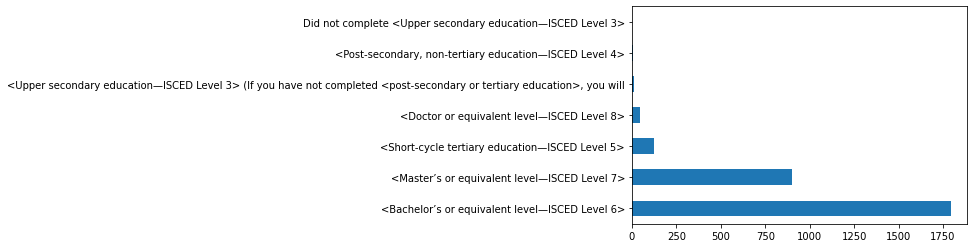

In [59]:
# graph frequency of educational achievement by the teachers in the dataframe
math_teach['BTBG04'].value_counts().plot(kind='barh');

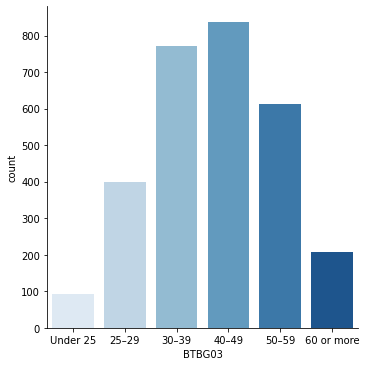

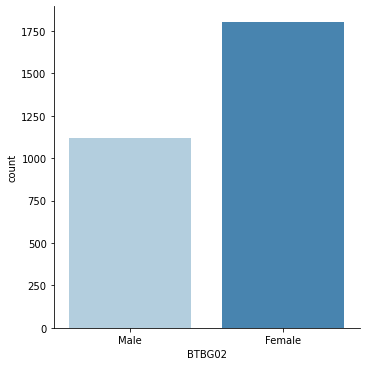

In [60]:
# create an ordinal categorical variable for the age of the teacher
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# impute the age as the ordinal type created above
math_teach['BTBG03'] = math_teach['BTBG03'].astype(cat_type)

# graph the age distribution of math teachers in the data
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=math_teach);
# graph the gender distribution of math teachers in the data
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=math_teach);

**Initial Observations about `math_teach` dataset:**
* Approximately Normal distribution of teacher ages
* Teach education is highly concentrated in the Bachelor's and Master's level
* Significantly more female teacher than males

**`math_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* trim and convert BTBG04 to ordered categoricals (ISCED level)
* convert to integer and combine BTBG05* columns to study_stem_edu column
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* convert to integer scale BTBG09* columns for comparing teaching environments
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices
* drop BTBG13* columns because already summarized in BTBGLSN
* convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices
* convert to integer scale BTBM17* columns for tracking effectiveness of computer access
* drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT
* convert to integer scale BTBM19* columns for tracking effectiveness of homework practices
* convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices
* drop BTBM22* columns because alreadys summarized in BTBM23
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

In [61]:
# explore basic structure of science teacher data
sci_teach.head()

IDCNTRY  IDSCHOOL    IDTEALIN   IDTEACH  IDLINK            ITCOURSE  \
0     36.0    5001.0  50010202.0  500102.0     2.0  Integrated science   
1     36.0    5001.0  50010304.0  500103.0     4.0  Integrated science   
2     36.0    5002.0  50020202.0  500202.0     2.0  Integrated science   
3     36.0    5002.0  50020303.0  500203.0     3.0  Integrated science   
4     36.0    5002.0  50020404.0  500204.0     4.0  Integrated science   

   BTBG01  BTBG02 BTBG03                                          BTBG04  \
0    16.0  Female  30–39  <Bachelor’s or equivalent level—ISCED Level 6>   
1    13.0    Male  40–49  <Bachelor’s or equivalent level—ISCED Level 6>   
2     4.0  Female  25–29    <Master’s or equivalent level—ISCED Level 7>   
3    15.0    Male  40–49    <Master’s or equivalent level—ISCED Level 7>   
4    14.0    Male  40–49  <Bachelor’s or equivalent level—ISCED Level 6>   

  BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G BTBG05H BTBG05I  \
0      No      No      No      No      No     Yes     Yes     Yes      No   
1      No      No      No      No      No     Yes     Yes     Yes      No   
2     Yes     Yes      No      No      No     Yes     Yes     Yes      No   
3      No     Yes      No     Yes      No      No     Yes     Yes     Yes   
4     Yes      No     Yes      No      No     Yes      No      No      No   

     BTBG06A    BTBG06B    BTBG06C BTBG06D BTBG06E BTBG06F    BTBG06G BTBG06H  \
0       High       High       High    High     Low  Medium     Medium  Medium   
1       High     Medium       High    High     Low     Low     Medium  Medium   
2       High       High       High    High  Medium     Low     Medium     Low   
3  Very high  Very high  Very high    High  Medium    High  Very high  Medium   
4     Medium  Very high       High  Medium    High  Medium  Very high  Medium   

  BTBG06I BTBG06J    BTBG06K    BTBG06L         BTBG07A      BTBG07B  \
0  Medium  Medium     Medium     Medium  Agree a little  Agree a lot   
1     Low  Medium        Low        Low  Agree a little  Agree a lot   
2     Low  Medium       High     Medium     Agree a lot  Agree a lot   
3    High  Medium       High  Very high     Agree a lot  Agree a lot   
4    High  Medium  Very high       High     Agree a lot  Agree a lot   

             BTBG07C            BTBG07D            BTBG07E            BTBG07F  \
0     Agree a little     Agree a little     Agree a little     Agree a little   
1  Disagree a little     Agree a little  Disagree a little     Disagree a lot   
2     Agree a little  Disagree a little  Disagree a little  Disagree a little   
3        Agree a lot     Agree a little        Agree a lot        Agree a lot   
4        Agree a lot     Agree a little     Agree a little  Disagree a little   

             BTBG07G            BTBG07H     BTBG08A     BTBG08B     BTBG08C  \
0     Agree a little     Agree a little   Sometimes   Sometimes       Often   
1  Disagree a little  Disagree a little       Often       Often       Often   
2     Agree a little     Agree a little   Sometimes   Sometimes       Often   
3        Agree a lot  Disagree a little  Very often       Often       Often   
4     Agree a little  Disagree a little  Very often  Very often  Very often   

      BTBG08D     BTBG08E         BTBG09A            BTBG09B  \
0   Sometimes       Often  Agree a little  Disagree a little   
1   Sometimes       Often     Agree a lot        Agree a lot   
2       Often       Often     Agree a lot        Agree a lot   
3       Often       Often     Agree a lot        Agree a lot   
4  Very often  Very often     Agree a lot  Disagree a little   

             BTBG09C         BTBG09D         BTBG09E            BTBG09F  \
0     Agree a little  Agree a little     Agree a lot  Disagree a little   
1  Disagree a little  Agree a little  Agree a little     Disagree a lot   
2        Agree a lot     Agree a lot     Agree a lot        Agree a lot   
3        Agree a lot     Agree a lot     Agree a lot        Agree a lot

In [62]:
# create a list of columns to drop (null or single unique value)
sci_teach_drop_new = list(sci_teach.columns[sci_teach.isna().all()])+list(sci_teach.columns[sci_teach.nunique()==1])

In [63]:
# add redundant languge column to be dropped
sci_teach_drop_new = sci_teach_drop_new + ['LCID_T']

In [64]:
# display contextual information for some of the data
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG' not in col],:].iloc[5:,:]

Label
Variable                                                   
ITCOURSE                         Subject Code in instrument
BTBS14                     SCI\TIME SPENT SCI INSTR MINUTES
BTBS15A                SCI\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBS15B                  SCI\ASK STUDENTS\OBSERVE PHENOMENA
BTBS15C             SCI\ASK STUDENTS\DEMONSTRATE EXPERIMENT
BTBS15D                   SCI\ASK STUDENTS\PLAN EXPERIMENTS
BTBS15E                SCI\ASK STUDENTS\CONDUCT EXPERIMENTS
BTBS15F                       SCI\ASK STUDENTS\PRESENT DATA
BTBS15G                     SCI\ASK STUDENTS\INTERPRET DATA
BTBS15H            SCI\ASK STUDENTS\USE EVIDENCE TO SUPPORT
BTBS15I                     SCI\ASK STUDENTS\READ TEXTBOOKS
BTBS15J                     SCI\ASK STUDENTS\MEMORIZE FACTS
BTBS15K                       SCI\ASK STUDENTS\USE FORMULAS
BTBS15L                      SCI\ASK STUDENTS\DO FIELD WORK
BTBS15M               SCI\ASK STUDENTS\MIXED ABILITY GROUPS
BTBS15N                SCI\ASK STUDENTS\SAME ABILITY GROUPS
BTBS16A         SCI\COMPUTER TABLET AVAILABILITY DURING SCI
BTBS16BA     SCI\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBS16BB         SCI\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBS16BC        SCI\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBS16CA        SCI\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBS16CB     SCI\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBS16CC    SCI\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBS16CD      SCI\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS
BTBS17AA         SCI\TOPIC\BIO\DIFFERENCES TAXONOMIC GROUPS
BTBS17AB                         SCI\TOPIC\BIO\MAJOR ORGANS
BTBS17AC             SCI\TOPIC\BIO\CELLS AND THEIR FUNCTION
BTBS17AD                         SCI\TOPIC\BIO\REPRODUCTION
BTBS17AE                    SCI\TOPIC\BIO\ROLE OF VARIATION
BTBS17AF        SCI\TOPIC\BIO\INTERDEPENDENCE OF POPULATION
BTBS17AG                         SCI\TOPIC\BIO\HUMAN HEALTH
BTBS17BA               SCI\TOPIC\CHEM\PARTICULATE STRUCTURE
BTBS17BB                      SCI\TOPIC\CHEM\PERIODIC TABLE
BTBS17BC            SCI\TOPIC\CHEM\PHY CHEM PROPERTY MATTER
BTBS17BD              SCI\TOPIC\CHEM\MIXTURES AND SOLUTIONS
BTBS17BE                     SCI\TOPIC\CHEM\ACIDS AND BASES
BTBS17BF                  SCI\TOPIC\CHEM\CHEMICAL REACTIONS
BTBS17BG                   SCI\TOPIC\CHEM\MATTER AND ENERGY
BTBS17BH                   SCI\TOPIC\CHEM\ROLE OF ELECTRONS
BTBS17CA                      SCI\TOPIC\PHY\PHYSICAL STATES
BTBS17CB                SCI\TOPIC\PHY\ENERGY TRANSFORMATION
BTBS17CC            SCI\TOPIC\PHY\BASIC PROPERTIES OF LIGHT
BTBS17CD            SCI\TOPIC\PHY\BASIC PROPERTIES OF SOUND
BTBS17CE                    SCI\TOPIC\PHY\ELECTRIC CIRCUITS
BTBS17CF                   SCI\TOPIC\PHY\PROPERTIES MAGNETS
BTBS17CG                    SCI\TOPIC\PHY\MOTION AND FORCES
BTBS17DA                   SCI\TOPIC\EARTH\EARTHS STRUCTURE
BTBS17DB                   SCI\TOPIC\EARTH\EARTHS PROCESSES
BTBS17DC                   SCI\TOPIC\EARTH\EARTHS RESOURCES
BTBS17DD              SCI\TOPIC\EARTH\EARTH IN SOLAR SYSTEM
BTBS18A                 SCI\HOW OFTEN SCI HOMEWORK ASSIGNED
BTBS18B                          SCI\TIME SPENT ON HOMEWORK
BTBS18CA                   SCI\HOMEWORK\CORRECT ASSIGNMENTS
BTBS18CB                  SCI\HOMEWORK\CORRECT OWN HOMEWORK
BTBS18CC                      SCI\HOMEWORK\DISCUSS HOMEWORK
BTBS18CD                  SCI\HOMEWORK\MONITOR COMPLETENESS
BTBS18CE                        SCI\HOMEWORK\USE FOR GRADES
BTBS19A        SCI\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBS19B           SCI\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBS19C         SCI\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBS19D              SCI\IMPORTANCE STRATEGIES\LONGER TESTS
BTBS19E        SCI\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS
BTBS20                     SCI\TESTS ON COMPUTER OR TABLETS
BTBS21AA          SCI\PROF DEVELOPMENT PAST\SCIENCE CONTENT
BTBS21BA        SCI\PROF DEVELOPMENT FUTURE\SCIENCE CONTENT
BTBS21AB         SCI\PROF DEVELOPM

In [65]:
# display descriptive statistics for quantitative variables in the dataset
sci_teach.describe()

IDCNTRY     IDSCHOOL      IDTEALIN        IDTEACH       IDLINK  \
count  3786.000000  3786.000000  3.786000e+03    3786.000000  3786.000000   
mean    449.294770  5132.137876  5.132172e+07  513217.117274     3.578711   
std     287.239794   100.998581  1.009958e+06   10099.584866     3.559090   
min      36.000000  5001.000000  5.001020e+07  500102.000000     1.000000   
25%     152.000000  5057.000000  5.057040e+07  505704.000000     2.000000   
50%     422.000000  5114.000000  5.114045e+07  511404.500000     3.000000   
75%     710.000000  5180.000000  5.180020e+07  518002.000000     4.000000   
max     926.000000  5520.000000  5.520030e+07  552003.000000    53.000000   

            BTBG01       BTBG10       BTBG11       BTBS14      BTBGEAS  \
count  3483.000000  3357.000000  3301.000000  3240.000000  3493.000000   
mean     14.698823    28.879357     5.887913   177.408951     9.838886   
std      10.251393    12.626525    11.648599    71.032793     2.125604   
min       0.000000     1.000000     0.000000     1.000000     0.873410   
25%       6.000000    22.000000     0.000000   120.000000     8.546510   
50%      13.000000    27.000000     1.000000   180.000000     9.749340   
75%      22.000000    32.000000     6.000000   220.000000    11.250980   
max      48.000000   117.000000   100.000000   700.000000    17.780680   

           BTBGLSN      BTBGSOS      BTBGTJS      BTBSESI      BTDSBIO  \
count  3423.000000  3468.000000  3475.000000  3449.000000  2772.000000   
mean      9.689788     9.878636     9.770973     9.655335    73.037347   
std       1.986278     2.208541     1.873157     2.009217    22.908600   
min       3.623690     4.426320     5.281180     6.513090     0.000000   
25%       8.632380     8.396310     8.482860     8.038700    57.142860   
50%       9.619100     9.611530    10.258740     9.836960    71.428570   
75%      10.698650    11.149320    11.745590    10.968860   100.000000   
max      15.295110    13.870350    11.745590    16.032560   100.000000   

          BTDSCHE      BTDSPHY      BTDSEAR  VERSION  
count  2780.00000  2767.000000  2551.000000   3786.0  
mean     75.31432    63.242811    69.433555      4.0  
std      22.28970    26.502999    35.891909      0.0  
min       0.00000     0.000000     0.000000      4.0  
25%      62.50000    42.857140    50.000000      4.0  
50%      75.00000    57.142860    75.000000      4.0  
75%     100.00000    85.714290   100.000000      4.0  
max     100.00000   100.000000   100.000000      4.0

In [66]:
# display datatypes
sci_teach.dtypes

IDCNTRY     float64
IDSCHOOL    float64
IDTEALIN    float64
IDTEACH     float64
IDLINK      float64
             ...   
BTDSBIO     float64
BTDSCHE     float64
BTDSPHY     float64
BTDSEAR     float64
VERSION     float64
Length: 168, dtype: object

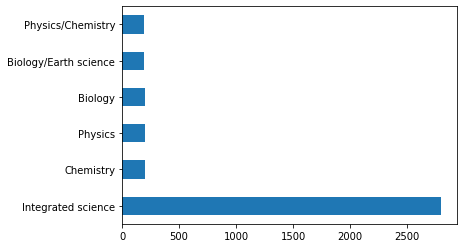

In [67]:
# graph the frequency of each science course taught
sci_teach['ITCOURSE'].value_counts().plot(kind='barh');

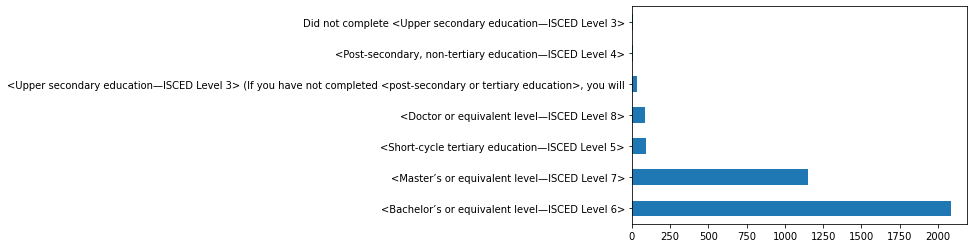

In [68]:
# visualize the frequency of educational achievement for science teachers
sci_teach['BTBG04'].value_counts().plot(kind='barh');

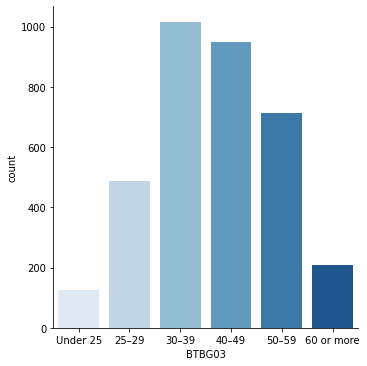

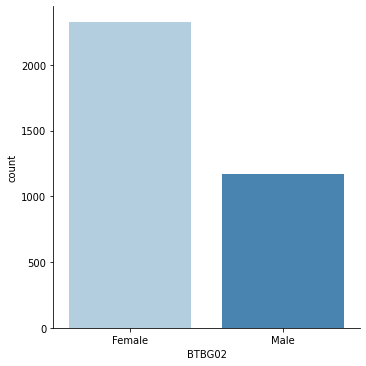

In [69]:
# create an ordinal categorical varialge for age groups
cat_type = CategoricalDtype(categories=['Under 25', '25–29', '30–39', '40–49', '50–59', '60 or more'], ordered=True)
# apply ordinal categorical to age data
sci_teach['BTBG03'] = sci_teach['BTBG03'].astype(cat_type)

# graph the age distribution for science teachers
sns.catplot(x='BTBG03', kind='count', palette='Blues', data=sci_teach);
# graph the gender distribution for science teachers
sns.catplot(x='BTBG02', kind='count', palette='Blues', data=sci_teach);

**Initial Observations about `sci_teach` dataset:**
* Approximately Normal distribution of teacher ages (slightly older than math teachers)
* Teach education is highly concentrated in the Bachelor's and Master's level (slightly more educated that math teachers)
* Significantly more female teacher than males (more significant difference than math teachers)
* Most schools offer Integrated Science as compared to specific disciplines

**`sci_teach` Data Preparation**
* drop unnecessary columns
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* trim and convert BTBG04 to ordered categoricals (ISCED level)
* convert to integer and combine BTBG05* columns to study_stem_edu column
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* convert to integer scale BTBG09* columns for comparing teaching environments
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices
* drop BTBG13* columns because already summarized in BTBGLSN
* convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices
* convert to integer scale BTBS16* columns for tracking effectiveness of computer access
* drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR
* convert to integer scale BTBS18* columns for tracking effectiveness of homework practices
* convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices
* drop BTBS21* columns because alreadys summarized in BTBM22
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

[Return to Top](#top)

<div id='data_preparation'></div>

# Data Preparation

Jump to:
1. [`stud_ach Preparation`](#prep1)
1. [`school Preparation`](#prep2)
1. [`student Preparation`](#prep3)
1. [`stud_teach Preparation`](#prep4)
1. [`math_teach Preparation`](#prep5)
1. [`sci_teach Preparation`](#prep6)

[Return to Top of Data Preparation](#data_preparation)

<div id='prep1'></div>

**`stud_ach` Data Preparation**
* ~~drop unnecessary (or null) columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers~~
* ~~trim and convert IDBOOK, IDGRADE to integer~~
* ~~rename all columns to be more descriptive~~

#### Define
* drop unnecessary (or null) columns

#### Code

In [70]:
# drop the null and single-value columns
stud_ach.drop(columns=stud_ach_drop_new, inplace=True)
# drop the redundant language column
stud_ach.drop(columns=['LCID_SA'], inplace=True)

#### Test

In [71]:
# check for no overlap between the dropped columns and the remaining columns
set(stud_ach_drop_new) & set(stud_ach.columns)

set()

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers

#### Code

In [72]:
# convert each of the columns into integer type
stud_ach['IDCNTRY'] = stud_ach['IDCNTRY'].astype(int)
stud_ach['IDSCHOOL'] = stud_ach['IDSCHOOL'].astype(int)
stud_ach['IDCLASS'] = stud_ach['IDCLASS'].astype(int)
stud_ach['IDSTUD'] = stud_ach['IDSTUD'].astype(int)

#### Test

In [73]:
# confirm change in datatype
stud_ach.dtypes[:10]

IDCNTRY          int32
IDBOOK          object
IDSCHOOL         int32
IDCLASS          int32
IDSTUD           int32
IDGRADE         object
ITLANG_SA       object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
dtype: object

#### Define
* trim and convert IDBOOK, IDGRADE to integer

#### Code

In [74]:
# take only the digits from the strings and convert to integer
stud_ach['IDBOOK'] = stud_ach['IDBOOK'].apply(lambda x: x[-2:]).astype(int)
stud_ach['IDGRADE'] = stud_ach['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [75]:
# confirm change in datatype 
stud_ach.dtypes[:10]

IDCNTRY          int32
IDBOOK           int32
IDSCHOOL         int32
IDCLASS          int32
IDSTUD           int32
IDGRADE          int32
ITLANG_SA       object
ITSEX           object
BSDAGE         float64
MP52024_val    float64
dtype: object

#### Define
* rename all columns to be more descriptive

#### Code

In [76]:
# create dictionary for renaming the columns
stud_ach_col_dict = {'ITLANG_SA':'language','IDGRADE':'grade','ITSEX':'sex','BSDAGE':'age','IDBOOK':'test_book'}
# rename the columns
stud_ach.rename(columns=stud_ach_col_dict, inplace=True)

#### Test

In [77]:
# check all columns that are not assessment item scores, category averages or standard deviations
[col for col in stud_ach.columns if '_avg' not in col and '_val' not in col and '_sd' not in col]

['IDCNTRY',
 'test_book',
 'IDSCHOOL',
 'IDCLASS',
 'IDSTUD',
 'grade',
 'language',
 'sex',
 'age']

[Return to Top of Data Preparation](#data_preparation)

<div id='prep2'></div>

**`school` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL to integers~~
* ~~trim and convert IDGRADE to integer~~
* ~~convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals~~
* ~~rename all columns to be more descriptive~~
* ~~merge with student performance by school~~

#### Define
* Drop repetitive columns from the dataset

#### Code

In [78]:
# drop the null or single-value columns
school.drop(columns=school_drop_new,inplace=True)
# drop the redundant language column
school.drop(columns=['LCID_C'], inplace=True)

#### Test

In [79]:
# verify dropped columns
set(school_drop_new) & set(school.columns)

set()

#### Define
* Convert IDCNTRY, IDSCHOOL to integers

#### Code

In [80]:
school['IDCNTRY'] = school['IDCNTRY'].astype(int)
school['IDSCHOOL'] = school['IDSCHOOL'].astype(int)

#### Test

In [81]:
# confirm change in datatype
school.dtypes[:5]

IDCNTRY       int32
IDSCHOOL      int32
IDGRADE      object
ITLANG_C     object
BCBGDAS     float64
dtype: object

#### Define
* Trim and convert IDGRADE to integer (8 or 9)

#### Code

In [82]:
# grab the digit from the string and convert it to integer
school['IDGRADE'] = school['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [83]:
# verify the unique values in IDGRADE
school['IDGRADE'].unique()

array([8, 9])

#### Define
* Convert BCDGDAS, BCDGEAS, BCDGMRS, BCDGSRS, BCDGSBC to ordered categoricals

#### Code

In [84]:
# create a list of all indices measuring school traits
school_indices = ['BCDGDAS', 'BCDGEAS', 'BCDGMRS', 'BCDGSRS', 'BCDGSBC']
# go through each of the indices
for col in school_indices:
    # print the contextual information for the index
    print(school_codes.loc[col,:])
    # print the unique values for the index
    print(school[col].unique())

Label    School Discipline Problems-Prncpl/IDX
Name: BCDGDAS, dtype: object
['Hardly Any Problems' 'Minor Problems' nan 'Moderate to Severe Problems']
Label    School Emph on Acad Success-Prncpl/IDX
Name: BCDGEAS, dtype: object
['Medium Emphasis' 'High Emphasis' 'Very High Emphasis' nan]
Label    Instr Aff by Mat Res Shortage-Prncpl/IDX
Name: BCDGMRS, dtype: object
['Not Affected' 'Affected' nan 'Affected A Lot']
Label    Instr Aff by Sci Res Shortage-Prncpl/IDX
Name: BCDGSRS, dtype: object
['Not Affected' 'Affected' nan 'Affected A Lot']
Label    School Composition by Socioeconomic Background
Name: BCDGSBC, dtype: object
[nan 'More Affluent' 'Neither More Affluent nor More Disadvantaged'
 'More Disadvantaged']


In [85]:
# create an ordinal categorical variable for discipline problems
disc_prob_type = CategoricalDtype(categories=['Hardly Any Problems','Minor Problems','Moderate to Severe Problems'], ordered=True)
# create new column with ordinal type
school['disc_prob'] = school['BCDGDAS'].astype(disc_prob_type)
# create an ordinal categorical variable for academic emphasis
acad_emph_type = CategoricalDtype(categories=['Medium Emphasis', 'High Emphasis', 'Very High Emphasis'], ordered=True)
# create new column with ordinal type
school['acad_emph'] = school['BCDGEAS'].astype(acad_emph_type)
# create an ordinal categorical variable for affect of shortages
shortage_affect_type = CategoricalDtype(categories=['Not Affected', 'Affected', 'Affected A Lot'], ordered=True)
# create new columns with ordinal type
school['math_shortage'] = school['BCDGMRS'].astype(shortage_affect_type)
school['sci_shortage'] = school['BCDGSRS'].astype(shortage_affect_type)
# create an ordinal categorical variable for socioeconomic background
school_socio_type = CategoricalDtype(categories=['More Disadvantaged', 'Neither More Affluent nor More Disadvantaged', 'More Affluent'], ordered=True)
# create new column with ordinal type
school['socio_background'] = school['BCDGSBC'].astype(school_socio_type)
# drop the previous columns, leaving the ordinal columns
school.drop(columns=school_indices, inplace=True)

#### Test

In [86]:
# confirm datatypes
school.dtypes

IDCNTRY                int32
IDSCHOOL               int32
IDGRADE                int32
ITLANG_C              object
BCBGDAS              float64
BCBGEAS              float64
BCBGMRS              float64
BCBGSRS              float64
BCDGTIHY             float64
disc_prob           category
acad_emph           category
math_shortage       category
sci_shortage        category
socio_background    category
dtype: object

#### Define
* rename all columns to be more descriptive

#### Code

In [87]:
# create a dictionary for renaming columns
school_col_dict = {'BCBGDAS':'disc_prob_score','BCBGEAS':'acad_emph_score','BCBGMRS':'math_shortage_score','BCBGSRS':'sci_shortage_score','BCDGTIHY':'acad_hours','ITLANG_C':'language','IDGRADE':'grade'}
# rename columns
school.rename(columns=school_col_dict,inplace=True)

#### Test

In [88]:
# confirm rename of columns
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background'],
      dtype='object')

#### Define
* merge with student performance by school

#### Code

In [89]:
# confirm student achievement data grouped by IDCNTRY and IDSCHOOL
stud_ach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]

mmat_avg    ssci_avg    malg_avg    mapp_avg    mdat_avg  \
IDCNTRY IDSCHOOL                                                               
36      5001      512.160420  528.909690  498.302685  521.510511  531.893457   
        5002      500.057398  525.348892  480.069888  501.129069  521.833812   
        5003      525.973490  533.678966  511.335672  529.865375  544.964311   
        5004      568.834716  582.543276  557.924186  572.206090  585.849087   
        5005      458.656151  478.569777  444.118141  460.885134  471.541118   
...                      ...         ...         ...         ...         ...   
926     5183      466.957372  476.967664  452.769782  468.937011  473.377250   
        5185      365.435784  371.044598  338.786517  370.456768  348.088408   
        5186      616.514895  618.214405  619.588005  625.891440  633.987500   
        5188      496.836016  515.692344  486.162437  497.704356  505.769562   
        5189      526.207270  536.803338  513.386954  520.617335  528.815793   

                    mgeo_avg    mkno_avg    mnum_avg    mrea_avg    sapp_avg  \
IDCNTRY IDSCHOOL                                                               
36      5001      510.723844  506.440412  516.348085  513.322954  536.406658   
        5002      495.260373  493.117152  505.968088  495.033254  533.047731   
        5003      519.626145  517.451107  531.761602  521.959500  538.120939   
        5004      566.528514  552.770096  580.028650  567.582195  587.872312   
        5005      452.514983  450.811446  456.019090  451.648922  481.027424   
...                      ...         ...         ...         ...         ...   
926     5183      468.292657  466.484542  473.139358  459.090532  475.552460   
        5185      350.552840  381.317040  375.374481  370.394465  357.076594   
        5186      617.478470  609.913583  613.485984  618.833868  620.193140   
        5188      496.101479  492.946888  501.964702  495.030819  519.030543   
        5189      518.125006  513.771460  525.154029  523.165579  537.108744   

                    sbio_avg    sche_avg    sear_avg    skno_avg    sphy_avg  \
IDCNTRY IDSCHOOL                                                               
36      5001      530.658886  514.227199  535.867503  507.441620  528.110842   
        5002      532.758198  512.284051  541.315108  514.368975  529.544135   
        5003      532.310956  526.377450  542.737756  525.064673  537.782550   
        5004      587.439474  577.372379  586.673154  575.790927  580.311813   
        5005      472.061751  452.380780  477.753128  461.967294  475.214976   
...                      ...         ...         ...         ...         ...   
926     5183      478.699837  471.569822  474.080005  475.910826  478.340698   
        5185      370.812283  338.711852  355.732031  359.443878  357.576048   
        5186      616.888514  624.245875  599.493436  621.085714  618.206429   
        5188      520.562055  506.914465  525.165300  526.623127  516.977343   
        5189      530.329469  537.346412  544.947730  537.834620  542.986514   

                    srea_avg  
IDCNTRY IDSCHOOL              
36      5001      532.552107  
        5002      534.525980  
        5003      537.392486  
        5004      590.738231  
        5005      495.105472  
...                      ...  
926     5183      474.215065  
        5185      356.191691  
        5186      610.239035  
        5188      520.289095  
        5189      539.928691  

[2193 rows x 16 columns]

In [90]:
# confirm school data indexed by IDCNTRY and IDSCHOOL
school.set_index(['IDCNTRY','IDSCHOOL'])

grade   language  disc_prob_score  acad_emph_score  \
IDCNTRY IDSCHOOL                                                       
36      5001          8    English         10.80136          9.26475   
        5002          8    English         12.80218         12.55044   
        5003          8    English          9.25300         10.46161   
        5004          8    English         12.13532         12.86324   
        5005          8    English         12.80218          9.26475   
...                 ...        ...              ...              ...   
710     5516          9    English         14.02858         16.36222   
        5517          9  Afrikaans          8.41206          8.67341   
        5518          9  Afrikaans          8.08398          7.39368   
        5519          9    English          7.93621         13.95351   
        5520          9  Afrikaans         14.02858         16.36222   

                  math_shortage_score  sci_shortage_score  acad_hours  \
IDCNTRY IDSCHOOL                                                        
36      5001                 11.26511            11.42529  1000.00000   
        5002                 14.25596            14.57241   919.41667   
        5003                  9.52239             9.57915  1000.00000   
        5004                 11.53380            11.70901  1045.00000   
        5005                 11.26511            11.42529   910.00000   
...                               ...                 ...         ...   
710     5516                 14.25596            14.57241  1013.25000   
        5517                 10.21426            10.17656  1100.00000   
        5518                  9.62794             9.57915  1061.33333   
        5519                  9.00816             9.46956  1160.83333   
        5520                 14.25596            14.57241  1200.00000   

                                    disc_prob           acad_emph  \
IDCNTRY IDSCHOOL                                                    
36      5001              Hardly Any Problems     Medium Emphasis   
        5002              Hardly Any Problems       High Emphasis   
        5003                   Minor Problems       High Emphasis   
        5004              Hardly Any Problems       High Emphasis   
        5005              Hardly Any Problems     Medium Emphasis   
...                                       ...                 ...   
710     5516              Hardly Any Problems  Very High Emphasis   
        5517                   Minor Problems     Medium Emphasis   
        5518                   Minor Problems     Medium Emphasis   
        5519      Moderate to Severe Problems  Very High Emphasis   
        5520              Hardly Any Problems  Very High Emphasis   

                 math_shortage  sci_shortage  \
IDCNTRY IDSCHOOL                               
36      5001      Not Affected  Not Affected   
        5002      Not Affected  Not Affected   
        5003          Affected      Affected   
        5004      Not Affected  Not Affected   
        5005      Not Affected  Not Affected   
...                        ...           ...   
710     5516      Not Affected  Not Affected   
        5517          Affected      Affected   
        5518          Affected      Affected   
        5519          Affected      Affected   
        5520      Not Affected  Not Affected   

                                              socio_background  
IDCNTRY IDSCHOOL                                                
36      5001                                               NaN  
        5002                                     More Affluent  
        5003      Neither More Affluent nor More Disadvantaged  
        5004                                     More Affluent  
        5005      Neither More Affluent nor More Disadvantaged  
...                                                        ...  
710     5516                                     More Affluent  
        5517           

In [91]:
# combine the student achievement data to the school dataframe
school = school.set_index(['IDCNTRY','IDSCHOOL']).join(stud_ach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [92]:
# confirm that school dataframe now has assessment columns
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg',
       'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg',
       'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

[Return to Top of Data Preparation](#data_preparation)

<div id='prep3'></div>

**`student` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers~~
* ~~trim and convert IDBOOK, IDGRADE to integers~~
* ~~convert to integer and combine BSBG05* columns to home_possession column~~
* ~~convert to string and combine BSBG09* columns to ordered categorical age_immigration column~~
* ~~convert to integer and combine BSBG12* columns to internet_access column~~
* ~~convert BSBG03, BSBG04, BSBG10, BSBG11*, BSDG* columns to ordered categoricals~~
* ~~trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)~~
* ~~convert BSBG08* to boolean~~
* ~~rename all columns to be more descriptive~~
* ~~merge with student performance~~

#### Define
* drop unnecessary columns

#### Code

In [93]:
student_drop_new = student_drop_new + ['LCID_SQ','ITLANG_SA','LCID_SA']
student.drop(columns=student_drop_new, inplace=True)

#### Test

In [94]:
# confirm columns dropped
set(student_drop_new) & set(student.columns)

set()

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD to integers
* trim and convert IDBOOK, IDGRADE to integers

#### Code

In [95]:
student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']] = student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']].astype(int)
# take the digits from IDBOOK and IDGRADE
student['IDBOOK'] = student['IDBOOK'].apply(lambda x: x[-2:]).astype(int)
student['IDGRADE'] = student['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [96]:
# confirm change in datatypes
student[['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD','IDBOOK','IDGRADE']].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDCLASS     int32
IDSTUD      int32
IDBOOK      int32
IDGRADE     int32
dtype: object

#### Define
* convert to integer and combine BSBG05* columns to home_possession column
* convert to integer and combine BSBG12* columns to internet_access column

#### Code

In [97]:
# dictionary for creating the new combined columns
conv_col = {'BSBG05':'home_possession','BSBG12':'internet_access'}
# go through each set of columns
for base_col in conv_col.keys():
    # gather the list of all columns matching the prefix
    all_cols = [col for col in student.columns if base_col in col]
    # go through each matching column
    for i, single_col in enumerate(all_cols):
        # if it is is the first column
        if i == 0:
            # create the new column with 1 for Yes, 0 for No, or NaN for null
            student[conv_col[base_col]] = student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
        # otherwise, add any subsequent values to the previous sum
        else:
            # add any subsequent values to the previous sum (1 for Yes, 0 for No, or NaN for null)
            student[conv_col[base_col]] = student[conv_col[base_col]] + student[single_col].apply(lambda x: np.nan if x!=x else int(x=='Yes')).astype(float)
    # drop all matching columns for the new combined columns
    student.drop(columns=all_cols, inplace=True)

#### Test

In [98]:
# confirm new columns
student.columns

Index(['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'BSBG03',
       'BSBG04', 'BSBG06A', 'BSBG06B', 'BSBG07', 'BSBG08A', 'BSBG08B',
       'BSBG09A', 'BSBG09B', 'BSBG10', 'BSBG11A', 'BSBG11B', 'IDGRADE',
       'ITLANG_SQ', 'ITSEX', 'BSDAGE', 'BSBGHER', 'BSDGHER', 'BSBGSSB',
       'BSDGSSB', 'BSBGSB', 'BSDGSB', 'BSBGSLM', 'BSDGSLM', 'BSBGICM',
       'BSDGICM', 'BSBGDML', 'BSDGDML', 'BSBGSCM', 'BSDGSCM', 'BSBGSVM',
       'BSDGSVM', 'BSBGSLS', 'BSDGSLS', 'BSBGICS', 'BSDGICS', 'BSBGSCS',
       'BSDGSCS', 'BSBGSVS', 'BSDGSVS', 'BSBGSLB', 'BSDGSLB', 'BSBGICB',
       'BSDGICB', 'BSBGSCB', 'BSDGSCB', 'BSBGSLE', 'BSDGSLE', 'BSBGICE',
       'BSDGICE', 'BSBGSCE', 'BSDGSCE', 'BSBGSLC', 'BSDGSLC', 'BSBGICC',
       'BSDGICC', 'BSBGSCC', 'BSDGSCC', 'BSBGSLP', 'BSDGSLP', 'BSBGICP',
       'BSDGICP', 'BSBGSCP', 'BSDGSCP', 'BSBGSEC', 'BSDGSEC', 'BSDG05S',
       'BSDGEDUP', 'home_possession', 'internet_access'],
      dtype='object')

In [99]:
# confirm datatypes
student[['home_possession','internet_access']].dtypes

home_possession    float64
internet_access    float64
dtype: object

#### Define
* convert to string and combine BSBG09* columns to ordered categorical age_immigration column

#### Code

In [100]:
# print the different values for each BSBG09 column
for col in [col for col in student.columns if 'BSBG09' in col]:
    print(student[col].unique())

['Yes' 'No' nan]
[nan 'Older than 10 years old' 'Younger than 5 years old'
 '5 to 10 years old']


In [101]:
def age_immigration_col(x):
    '''
    combines both immigration columns into a single values
    
    INPUT:
    x - (list with two values)   Yes/No for born in country
                                 Age range when immigrated in country
    
    OUTPUT:
    a value representing age range when immigrated ('Birth' for born in country)
    '''
    # if born in country, return 'Birth'
    if x[0] == 'Yes':
        return('Birth')
    # otherwise, return age range of immigration
    else:
        return(x[1])

In [102]:
# use the age_immigration_col function to combine the two immigration columns
student['age_immigration'] = student[['BSBG09A','BSBG09B']].apply(age_immigration_col, axis = 1)
# delete the previous immigration columns
student.drop(columns=['BSBG09A','BSBG09B'], inplace=True)

In [103]:
# create ordinal categorical type for immigration age
immigration_type = CategoricalDtype(categories=['Birth','Younger than 5 years old','5 to 10 years old', 'Older than 10 years old'], ordered=True)
student['age_immigration'] = student['age_immigration'].astype(immigration_type)

#### Test

In [104]:
# confirm change in datatype
student[[col for col in student.columns if 'BSBG09' in col or 'immigration' in col]].dtypes

age_immigration    category
dtype: object

#### Define
* convert BSBG03, BSBG04, BSBG10, BSBG11, BSDG columns to ordered categoricals

#### Code

In [105]:
# print the context label and unique values for each column matching the column prefixes
new_cat_cols = ['BSBG03', 'BSBG04', 'BSBG10', 'BSBG11', 'BSDG']
for col_root in new_cat_cols:
    for col in student.columns:
        if col_root in col:
            print(student[col].unique())
            print(student_codes.loc[col,:])

['Always' 'Almost always' 'Sometimes' nan 'Never']
Label    GEN\OFTEN SPEAK <LANG OF TEST> AT HOME
Name: BSBG03, dtype: object
['Enough to fill one shelf (11–25 books)' 'None or very few (0–10 books)'
 'Enough to fill one bookcase (26–100 books)'
 'Enough to fill three or more bookcases (more than 200)'
 'Enough to fill two bookcases (101–200 books)' nan]
Label    GEN\AMOUNT OF BOOKS IN YOUR HOME
Name: BSBG04, dtype: object
['Never or almost never' 'Once every two weeks' 'Once a month'
 'Once every two month' 'Once a week' nan]
Label    GEN\ABOUT HOW OFTEN ABSENT FROM SCHOOL
Name: BSBG10, dtype: object
['Sometimes' 'Almost every day' 'Every day' 'Never' nan]
Label    GEN\HOW OFTEN\TIRED
Name: BSBG11A, dtype: object
['Never' 'Almost every day' 'Sometimes' 'Every day' nan]
Label    GEN\HOW OFTEN\HUNGRY
Name: BSBG11B, dtype: object
['Some Resources' 'Many Resources' 'Few Resources' nan]
Label    Home Educational Resources/IDX
Name: BSDGHER, dtype: object
['Some Sense of School Belonging' 

In [106]:
# create a blank dictionary to store all of the changes to the columns summarized above
info = {}
# each entry in the dictionary contains the column prefix as the key, then a new name for the column, then the ordinal values of the categories
info['BSBG03'] = {'new_name':'acad_lang_home','ordered_cols':['Never','Sometimes','Almost always','Always']}
info['BSBG04'] = {'new_name':'books','ordered_cols':['None or very few (0–10 books)','Enough to fill one shelf (11–25 books)',
                                                     'Enough to fill one bookcase (26–100 books)','Enough to fill two bookcases (101–200 books)',
                                                     'Enough to fill three or more bookcases (more than 200)']}
info['BSBG10'] = {'new_name':'absent_freq','ordered_cols':['Never or almost never','Once every two month','Once a month','Once every two weeks','Once a week']}
info['BSBG11A'] = {'new_name':'tired_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSBG11B'] = {'new_name':'hungry_freq','ordered_cols':['Never','Sometimes','Almost every day','Every day']}
info['BSDGHER'] = {'new_name':'home_res','ordered_cols':['Few Resources','Some Resources','Many Resources']}
info['BSDGSSB'] = {'new_name':'belonging','ordered_cols':['Little Sense of School Belonging','Some Sense of School Belonging','High Sense of School Belonging']}
info['BSDGSB'] = {'new_name':'bullying','ordered_cols':['Never or Almost Never','About Monthly','About Weekly']}
info['BSDGSLM'] = {'new_name':'like_math','ordered_cols':['Do Not Like Learning Mathematics','Somewhat Like Learning Mathematics','Very Much Like Learning Mathematics']}
info['BSDGICM'] = {'new_name':'clear_math','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGDML'] = {'new_name':'disorder_math','ordered_cols':['Few or No Lessons','Some Lessons','Most Lessons']}
info['BSDGSCM'] = {'new_name':'confident_math','ordered_cols':['Not Confident in Mathematics','Somewhat Confident in Mathematics','Very Confident in Mathematics']}
info['BSDGSVM'] = {'new_name':'value_math','ordered_cols':['Do Not Value Mathematics','Somewhat Value Mathematics','Strongly Value Mathematics']}
info['BSDGSLS'] = {'new_name':'like_science','ordered_cols':['Do Not Like Learning Science','Somewhat Like Learning Science','Very Much Like Learning Science']}
info['BSDGICS'] = {'new_name':'clear_science','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCS'] = {'new_name':'confident_science','ordered_cols':['Not Confident in Science','Somewhat Confident in Science','Very Confident in Science']}
info['BSDGSVS'] = {'new_name':'value_science','ordered_cols':['Do Not Value Science','Somewhat Value Science','Strongly Value Science']}
info['BSDGSLB'] = {'new_name':'like_bio','ordered_cols':['Do Not Like Learning Biology','Somewhat Like Learning Biology','Very Much Like Learning Biology']}
info['BSDGICB'] = {'new_name':'clear_bio','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCB'] = {'new_name':'confident_bio','ordered_cols':['Not Confident in Biology','Somewhat Confident in Biology','Very Confident in Biology']}
info['BSDGSLE'] = {'new_name':'like_earth','ordered_cols':['Do Not Like Learning Earth Science','Somewhat Like Learning Earth Science','Very Much Like Learning Earth Science']}
info['BSDGICE'] = {'new_name':'clear_earth','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCE'] = {'new_name':'confident_earth','ordered_cols':['Not Confident in Earth Science','Somewhat Confident in Earth Science','Very Confident in Earth Science']}
info['BSDGSLC'] = {'new_name':'like_chem','ordered_cols':['Do Not Like Learning Chemistry','Somewhat Like Learning Chemistry','Very Much Like Learning Chemistry']}
info['BSDGICC'] = {'new_name':'clear_chem','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCC'] = {'new_name':'confident_chem','ordered_cols':['Not Confident in Chemistry','Somewhat Confident in Chemistry','Very Confident in Chemistry']}
info['BSDGSLP'] = {'new_name':'like_phys','ordered_cols':['Do Not Like Learning Physics','Somewhat Like Learning Physics','Very Much Like Learning Physics']}
info['BSDGICP'] = {'new_name':'clear_phys','ordered_cols':['Low Clarity of Instruction','Moderate Clarity of Instruction','High Clarity of Instruction']}
info['BSDGSCP'] = {'new_name':'confident_phys','ordered_cols':['Not Confident in Physics','Somewhat Confident in Physics','Very Confident in Physics']}
info['BSDGSEC'] = {'new_name':'confident_computer','ordered_cols':['Low Self-Efficacy','Medium Self-Efficacy','High Self-Efficacy']}
info['BSDG05S'] = {'new_name':'study_support','ordered_cols':['Neither Own Room nor Internet Connection','Either Own Room or Internet Connection','Both Own Room and Internet Connection']}
info['BSDGEDUP'] = {'new_name':'','ordered_cols':['Some Primary, Lower Secondary or No School',
                                                 'Lower Secondary','Upper Secondary','Post-secondary but not University',
                                                 'University or Higher']}

In [107]:
# go through each item in the dictionary above
for item in info.keys():
    # create the ordinal categorical type with the respective values
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # apply the new type to the column
    student[item] = student[item].astype(cat_type)
    # rename the column to new name
    student.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [108]:
# investigate the datatypes of the new columns (by sampling 10 lowercase columns)
student.loc[:,[col for col in student.columns if col.islower()]].dtypes.sample(10)

hungry_freq          category
like_chem            category
confident_chem       category
confident_science    category
study_support        category
clear_bio            category
confident_math       category
confident_bio        category
books                category
like_bio             category
dtype: object

In [109]:
# verify the ordinal categorical of a randomly selected column
student[random.choice([col for col in student.columns if col.islower()])].unique()

['Few or No Lessons', 'Some Lessons', 'Most Lessons', NaN]
Categories (3, object): ['Few or No Lessons' < 'Some Lessons' < 'Most Lessons']

#### Define
* trim and convert BSBG06A, BSBG06B, BSBG07 to ordered categoricals (ISCED level)

#### Code

In [110]:
# check the context info for the column
student_codes.loc['BSBG06A']

Label    GEN\HIGHEST LVL OF EDU OF <PARENT/GUARDIAN A>
Name: BSBG06A, dtype: object

In [111]:
def edu_level(val):
    '''
    translates educational level into standard ISCED Level output
    
    INPUT:
    val - (str) a string containing educational information, description, and ISCED Level
    
    OUTPUT:
    a string representing the respective ISCED Level of education
    '''
    try:
        # if the string contains a digit
        level = re.search('[0-9]',val).group(0)
        # return the respective ISCED Level
        return 'ISCED Level '+level
    except:
        # otherwise, return NaN
        return np.NaN

In [112]:
# create three new educational columns by applying edu_level function
student['parent_edu_1'] = student['BSBG06A'].apply(edu_level)
student['parent_edu_2'] = student['BSBG06B'].apply(edu_level)
student['desired_edu'] = student['BSBG07'].apply(edu_level)
# drop the previous columns
student.drop(columns=['BSBG06A', 'BSBG06B', 'BSBG07'],inplace=True)

In [113]:
# use the unique entries of education to create a list
edu_list = list(filter(lambda x: str(x) != 'nan',student['parent_edu_1'].unique()))
# sort the list
edu_list.sort()
# use the sorted list to create an ordinal category
edu_type = CategoricalDtype(categories=edu_list, ordered=True)
# apply the ordinal category to the three educational variables
student['parent_edu_1'] = student['parent_edu_1'].astype(edu_type)
student['parent_edu_2'] = student['parent_edu_2'].astype(edu_type)
student['desired_edu'] = student['desired_edu'].astype(edu_type)

#### Test

In [114]:
# test that all educaitonal columns are now ordinal
for col in [col for col in student.columns if '_edu' in col]:
    print(student.loc[:,col].unique())

['ISCED Level 6', NaN, 'ISCED Level 2', 'ISCED Level 5', 'ISCED Level 3', 'ISCED Level 7', 'ISCED Level 4', 'ISCED Level 1']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
['ISCED Level 4', NaN, 'ISCED Level 6', 'ISCED Level 3', 'ISCED Level 5', 'ISCED Level 7', 'ISCED Level 2', 'ISCED Level 1']
Categories (7, object): ['ISCED Level 1' < 'ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']
['ISCED Level 6', 'ISCED Level 3', 'ISCED Level 4', 'ISCED Level 7', 'ISCED Level 2', 'ISCED Level 5', NaN]
Categories (6, object): ['ISCED Level 2' < 'ISCED Level 3' < 'ISCED Level 4' < 'ISCED Level 5' < 'ISCED Level 6' < 'ISCED Level 7']


#### Define
* convert BSBG08* to float

#### Code

In [115]:
def immig_status(val):
    '''
    makes immigration status into binary value
    
    INPUT:
    val - (str)   Yes/No/NaN
    
    OUTPUT:
    a binary integer value representing immigration status
    '''
    if val == "Yes":
        return 1
    elif val == "No":
        return 0
    else:
        return np.nan

In [116]:
# create an immigration status column for each parent by apply immig_status function
student['parent_immig_1'] = student['BSBG08A'].apply(immig_status)
student['parent_immig_2'] = student['BSBG08B'].apply(immig_status)
# delete previous two columns
student.drop(columns=['BSBG08A','BSBG08B'],inplace=True)

#### Test

In [117]:
# verify valid values in the immigration status
student['parent_immig_1'].unique()

array([ 1.,  0., nan])

#### Define
* rename all columns to be more descriptive

#### Code

In [118]:
# generate a list of columns that are not yet lowercase (have not yet been renamed)
str(list([col for col in student.columns if not col.islower()]))

"['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDGRADE', 'ITLANG_SQ', 'ITSEX', 'BSDAGE', 'BSBGHER', 'BSBGSSB', 'BSBGSB', 'BSBGSLM', 'BSBGICM', 'BSBGDML', 'BSBGSCM', 'BSBGSVM', 'BSBGSLS', 'BSBGICS', 'BSBGSCS', 'BSBGSVS', 'BSBGSLB', 'BSBGICB', 'BSBGSCB', 'BSBGSLE', 'BSBGICE', 'BSBGSCE', 'BSBGSLC', 'BSBGICC', 'BSBGSCC', 'BSBGSLP', 'BSBGICP', 'BSBGSCP', 'BSBGSEC', '']"

In [119]:
# create a dictionary to rename columns with more descriptive names
student_col_dict = {'ITLANG_SQ':'language',
                     'IDGRADE':'grade',
                     'ITSEX':'sex',
                     'BSDAGE':'age',
                     'IDBOOK':'test_book',
                    'BSBGHER':'home_res_score',
                    'BSBGSSB':'belonging_score',
                    'BSBGSB':'bullying_score',
                    'BSBGSLM':'like_math_score',
                    'BSBGICM':'clear_math_score',
                    'BSBGDML':'disorder_math_score',
                    'BSBGSCM':'confident_math_score',
                    'BSBGSVM':'value_math_score',
                    'BSBGSLS':'like_science_score',
                    'BSBGICS':'clear_science_score',
                    'BSBGSCS':'confident_science_score',
                    'BSBGSVS':'value_science_score',
                    'BSBGSLB':'like_bio_score', 
                    'BSBGICB':'clear_bio_score',
                    'BSBGSCB':'confident_bio_score',
                    'BSBGSLE':'like_earth_score',
                    'BSBGICE':'clear_earth_score',
                    'BSBGSCE':'confident_earth_score',
                    'BSBGSLC':'like_chem_score',
                    'BSBGICC':'clear_chem_score',
                    'BSBGSCC':'confident_chem_score',
                    'BSBGSLP':'like_phys_score',
                    'BSBGICP':'clear_phys_score',
                    'BSBGSCP':'confident_phys_score',
                    'BSBGSEC':'confident_computer_score',
                    '':'parent_edu_max'}
# rename the columns
student.rename(columns=student_col_dict, inplace=True)

#### Test

In [120]:
# verify renamed columns
student.columns

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD',
       'acad_lang_home', 'books', 'absent_freq', 'tired_freq', 'hungry_freq',
       'grade', 'language', 'sex', 'age', 'home_res_score', 'home_res',
       'belonging_score', 'belonging', 'bullying_score', 'bullying',
       'like_math_score', 'like_math', 'clear_math_score', 'clear_math',
       'disorder_math_score', 'disorder_math', 'confident_math_score',
       'confident_math', 'value_math_score', 'value_math',
       'like_science_score', 'like_science', 'clear_science_score',
       'clear_science', 'confident_science_score', 'confident_science',
       'value_science_score', 'value_science', 'like_bio_score', 'like_bio',
       'clear_bio_score', 'clear_bio', 'confident_bio_score', 'confident_bio',
       'like_earth_score', 'like_earth', 'clear_earth_score', 'clear_earth',
       'confident_earth_score', 'confident_earth', 'like_chem_score',
       'like_chem', 'clear_chem_score', 'clear_chem', 'confident_chem_s

#### Define
* merge with student performance

#### Code

In [121]:
# check first 8 columns in student dataframe
student.columns[:8]

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD',
       'acad_lang_home', 'books', 'absent_freq'],
      dtype='object')

In [122]:
# check first 8 columns in stud_ach dataframe
stud_ach.columns[:8]

Index(['IDCNTRY', 'test_book', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'grade',
       'language', 'sex'],
      dtype='object')

In [123]:
# combine the assessment data to the student dataframe
student = student.set_index(['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']).join(stud_ach.set_index(['IDCNTRY','IDSCHOOL','IDCLASS','IDSTUD']).loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [124]:
# verify that the student dataframe now contains assessment data
student.head()

IDCNTRY  IDSCHOOL  IDCLASS    IDSTUD  test_book acad_lang_home  \
0       36      5001   500101  50010101          1         Always   
1       36      5001   500101  50010102          2  Almost always   
2       36      5001   500101  50010104          4         Always   
3       36      5001   500101  50010105          5         Always   
4       36      5001   500101  50010107          7         Always   

                                               books            absent_freq  \
0             Enough to fill one shelf (11–25 books)  Never or almost never   
1                      None or very few (0–10 books)  Never or almost never   
2         Enough to fill one bookcase (26–100 books)  Never or almost never   
3  Enough to fill three or more bookcases (more t...  Never or almost never   
4       Enough to fill two bookcases (101–200 books)  Never or almost never   

         tired_freq       hungry_freq  grade language     sex    age  \
0         Sometimes             Never      8  English  Female  13.50   
1         Sometimes             Never      8  English    Male  14.33   
2  Almost every day  Almost every day      8  English    Male  13.83   
3  Almost every day         Sometimes      8  English  Female  14.08   
4         Sometimes             Never      8  English  Female  13.83   

   home_res_score        home_res  belonging_score  \
0        10.84499  Some Resources          8.46096   
1         8.99877  Some Resources          8.08091   
2        11.19079  Some Resources          9.40801   
3        13.30161  Many Resources          7.73555   
4        12.04797  Some Resources         10.00496   

                          belonging  bullying_score               bullying  \
0    Some Sense of School Belonging         7.85954          About Monthly   
1    Some Sense of School Belonging        12.93734  Never or Almost Never   
2    Some Sense of School Belonging         9.92809  Never or Almost Never   
3  Little Sense of School Belonging         9.28593  Never or Almost Never   
4    Some Sense of School Belonging        10.41803  Never or Almost Never   

   like_math_score                           like_math  clear_math_score  \
0          7.71308    Do Not Like Learning Mathematics           9.15605   
1          5.09484    Do Not Like Learning Mathematics           6.80608   
2          8.94763    Do Not Like Learning Mathematics           9.92675   
3          7.13627    Do Not Like Learning Mathematics           7.73983   
4         10.45644  Somewhat Like Learning Mathematics          10.38389   

                        clear_math  disorder_math_score      disorder_math  \
0  Moderate Clarity of Instruction             14.67371  Few or No Lessons   
1       Low Clarity of Instruction             14.67371  Few or No Lessons   
2  Moderate Clarity of Instruction             11.10343       Some Lessons   
3       Low Clarity of Instruction             11.61733  Few or No Lessons   
4      High Clarity of Instruction              9.45061       Some Lessons   

   confident_math_score                     confident_math  value_math_score  \
0               7.34181       Not Confident in Mathematics           6.70110   
1              11.75008  Somewhat Confident in Mathematics           6.48714   
2              10.84951  Somewhat Confident in Mathematics          10.77308   
3               7.67800       Not Confident in Mathematics           7.10653   
4              10.12116  Somewhat Confident in Mathematics           8.82228   

                   value_math  like_science_score  \
0    Do Not Value Mathematics            11.53300   
1    Do Not Value Mathematics             8.90441   
2  Strongly Value Mathematics             9.34076   
3    Do Not Value Mathematics             8.09896   
4  Somewhat Value Mathematics             7.10319   

                      like_science  clear_science_score  \
0  Very Much Like Learning Science             12.63386   
1   Somewhat Like Learning Science        

[Return to Top of Data Preparation](#data_preparation)

<div id='prep4'></div>

**`stud_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers~~
* ~~trim and convert IDGRADE to integers~~

#### Define
* drop unnecessary columns

#### Code

In [125]:
stud_teach.drop(columns=stud_teach_drop_new, inplace=True)

#### Test

In [126]:
set(stud_teach_drop_new) & set(stud_teach.columns)

set()

#### Define
* trim and convert IDGRADE to integers

#### Code

In [127]:
# gather the digit from the grade data and convert to an integer
stud_teach['IDGRADE'] = stud_teach['IDGRADE'].apply(lambda x: x[-1]).astype(int)

#### Test

In [128]:
# verify valid values
stud_teach['IDGRADE'].unique()

array([8, 9])

#### Define
* convert IDCNTRY, IDSCHOOL, IDCLASS, IDSTUD, IDGRADE, IDTEALIN, IDTEACH, IDLINK, NMTEACH, NSTEACH to integers

#### Code

In [129]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'IDGRADE', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'NMTEACH', 'NSTEACH']
# go through each column
for col in int_cols:
    # replace any missing values with a 0 (only applies to number of teachers - NMTEACH/NSTEACH)
    stud_teach[col] = stud_teach[col].apply(lambda x: int(x) if x==x else 0)

#### Test

In [130]:
# confirm converted datatypes
stud_teach.loc[:,int_cols].dtypes

IDCNTRY     int64
IDSCHOOL    int64
IDCLASS     int64
IDSTUD      int64
IDGRADE     int64
IDTEALIN    int64
IDTEACH     int64
IDLINK      int64
NMTEACH     int64
NSTEACH     int64
dtype: object

[Return to Top of Data Preparation](#data_preparation)

<div id='prep5'></div>

**`math_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers~~
* ~~trim and convert BTBG04 to ordered categoricals (ISCED level)~~
* ~~convert to integer and combine BTBG05* columns to study_stem_edu column~~
* ~~drop BTBG06* columns because already summarized in BTBGEAS~~
* ~~drop BTBG07* columns because already summarized in BTBGSOS~~
* ~~drop BTBG08* columns because already summarized in BTBGTJS~~
* ~~convert to integer scale BTBG09* columns for comparing teaching environments~~
* ~~convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices~~
* ~~drop BTBG13* columns because already summarized in BTBGLSN~~
* ~~convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices~~
* ~~convert to integer scale BTBM17* columns for tracking effectiveness of computer access~~
* ~~drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT~~
* ~~convert to integer scale BTBM19* columns for tracking effectiveness of homework practices~~
* ~~convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices~~
* ~~drop BTBM22* columns because alreadys summarized in BTBM23~~
* ~~convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals~~
* ~~rename all columns to be more descriptive~~
* ~~merge with average student performance by teacher~~

#### Define
* drop unnecessary columns
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* drop BTBG13* columns because already summarized in BTBGLSN
* drop BTBM18* columns because already summarized in BTDMNUM, BTDMALG, BTDMGEO, BTDMDAT
* drop BTBM22* columns because alreadys summarized in BTBM23

#### Code

In [131]:
# list of column prefixes to drop from analysis
drop_heads = ['BTBG06','BTBG07','BTBG08','BTBG13','BTBM18','BTBM22']
# add all columns with matching prefixes to be dropped
for head in drop_heads:
    math_teach_drop_new += [col for col in math_teach.columns if head in col]

In [132]:
# drop all unnecessary columns
math_teach.drop(columns=math_teach_drop_new, inplace=True)

#### Test

In [133]:
# confirm columns were dropped
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'BTBG01',
       'BTBG02', 'BTBG03', 'BTBG04', 'BTBG05A', 'BTBG05B', 'BTBG05C',
       'BTBG05D', 'BTBG05E', 'BTBG05F', 'BTBG05G', 'BTBG05H', 'BTBG05I',
       'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D', 'BTBG09E', 'BTBG09F',
       'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11', 'BTBG12A', 'BTBG12B',
       'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F', 'BTBG12G', 'BTBM14',
       'BTBM15A', 'BTBM15B', 'BTBM15C', 'BTBM15D', 'BTBM15E', 'BTBM15F',
       'BTBM15G', 'BTBM15H', 'BTBM16', 'BTBM17A', 'BTBM17BA', 'BTBM17BB',
       'BTBM17BC', 'BTBM17CA', 'BTBM17CB', 'BTBM17CC', 'BTBM17CD', 'BTBM19A',
       'BTBM19B', 'BTBM19CA', 'BTBM19CB', 'BTBM19CC', 'BTBM19CD', 'BTBM19CE',
       'BTBM20A', 'BTBM20B', 'BTBM20C', 'BTBM20D', 'BTBM20E', 'BTBM21',
       'BTBM23', 'IDGRADE', 'ITLANG_T', 'BTBGEAS', 'BTBGLSN', 'BTBGSOS',
       'BTBGTJS', 'BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS', 'BTDMMME',
       'BTDMNUM', 'BTDMALG', 'BTDMGEO', 'BTDMDA

#### Define
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers

#### Code

In [134]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK']
for col in int_cols:
    # convert each column into integers
    math_teach[col] = math_teach[col].astype(int)

#### Test

In [135]:
# confirm converted columns
math_teach.loc[:,int_cols].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDTEALIN    int32
IDTEACH     int32
IDLINK      int32
dtype: object

#### Define
* trim and convert BTBG04 to ordered categoricals (ISCED level)

#### Code

In [136]:
def teacher_edu_level(val):
    '''
    translates educational level into standard ISCED Level output
    
    INPUT:
    val - (str) a string containing educational information, description, and ISCED Level
    
    OUTPUT:
    a string representing the respective ISCED Level of education
    '''
    try:
        # find a digit in the string
        level = re.search('[0-9]',val).group(0)
        # if the string says level 3 was incomplete
        if level == '3' and 'Did not complete' in val:
            # assign level 2
            return 'ISCED Level 2'
        # return the respective educational level
        return 'ISCED Level '+level
    except:
        return np.NaN

In [137]:
# create new educational level column for math teacher by applying teacher_edu_level function
math_teach['edu_level'] = math_teach['BTBG04'].apply(teacher_edu_level)
# drop older column
math_teach.drop(columns=['BTBG04'],inplace=True)

#### Test

In [138]:
# confirm appropriate conversion of values
math_teach['edu_level'].value_counts()

ISCED Level 6    1794
ISCED Level 7     903
ISCED Level 5     122
ISCED Level 8      43
ISCED Level 3      13
ISCED Level 4       7
ISCED Level 2       3
Name: edu_level, dtype: int64

#### Define
* convert to integer and combine BTBG05* columns to study_stem_edu column

#### Code

In [139]:
# examine format of all BTBG05 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][:-2]]

BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G
0        Yes      No      No      No      No     Yes     Yes
1         No      No      No      No      No     Yes     Yes
2        Yes      No     Yes     Yes      No      No      No
3        Yes     Yes      No     Yes      No     Yes     Yes
4         No      No      No      No      No     Yes      No
...      ...     ...     ...     ...     ...     ...     ...
3096     Yes     Yes     Yes     Yes      No     Yes      No
3097     Yes      No      No      No      No      No      No
3098     Yes      No      No      No      No      No      No
3099     Yes      No      No      No      No      No      No
3100     Yes      No     Yes     Yes      No     Yes     Yes

[3101 rows x 7 columns]

In [140]:
# examine context of the columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG05' in col]]

Label
Variable                                         
BTBG05A       GEN\MAJOR AREA OF STUDY\MATHEMATICS
BTBG05B           GEN\MAJOR AREA OF STUDY\BIOLOGY
BTBG05C           GEN\MAJOR AREA OF STUDY\PHYSICS
BTBG05D         GEN\MAJOR AREA OF STUDY\CHEMISTRY
BTBG05E   GEN\MAJOR AREA OF STUDY\<EARTH SCIENCE>
BTBG05F   GEN\MAJOR AREA OF STUDY\EDU MATHEMATICS
BTBG05G       GEN\MAJOR AREA OF STUDY\EDU SCIENCE
BTBG05H       GEN\MAJOR AREA OF STUDY\EDU GENERAL
BTBG05I             GEN\MAJOR AREA OF STUDY\OTHER

In [141]:
# create a study_stem column (1 for any math or science related study, 0 for no math or science related study)
math_teach['study_stem'] = 1-math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][:-2]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [142]:
# create a study_edu column (1 for any education related study, 0 for no education related study)
math_teach['study_edu'] = 1-math_teach.loc[:,[col for col in math_teach.columns if 'BTBG05' in col][-4:-1]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [143]:
# drop all previous columns in favor of new education columns
math_teach.drop(columns=[col for col in math_teach.columns if 'BTBG05' in col],inplace=True)

#### Test

In [144]:
# confirm column updates
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'BTBG01',
       'BTBG02', 'BTBG03', 'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D',
       'BTBG09E', 'BTBG09F', 'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11',
       'BTBG12A', 'BTBG12B', 'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F',
       'BTBG12G', 'BTBM14', 'BTBM15A', 'BTBM15B', 'BTBM15C', 'BTBM15D',
       'BTBM15E', 'BTBM15F', 'BTBM15G', 'BTBM15H', 'BTBM16', 'BTBM17A',
       'BTBM17BA', 'BTBM17BB', 'BTBM17BC', 'BTBM17CA', 'BTBM17CB', 'BTBM17CC',
       'BTBM17CD', 'BTBM19A', 'BTBM19B', 'BTBM19CA', 'BTBM19CB', 'BTBM19CC',
       'BTBM19CD', 'BTBM19CE', 'BTBM20A', 'BTBM20B', 'BTBM20C', 'BTBM20D',
       'BTBM20E', 'BTBM21', 'BTBM23', 'IDGRADE', 'ITLANG_T', 'BTBGEAS',
       'BTBGLSN', 'BTBGSOS', 'BTBGTJS', 'BTDGEAS', 'BTDGLSN', 'BTDGSOS',
       'BTDGTJS', 'BTDMMME', 'BTDMNUM', 'BTDMALG', 'BTDMGEO', 'BTDMDAT',
       'edu_level', 'study_stem', 'study_edu'],
      dtype='object')

In [145]:
# confirm datatype
math_teach['study_stem'].dtypes

dtype('int32')

#### Define
* convert to integer scale BTBG09* columns for comparing teaching environments

#### Code

In [146]:
# examine format of BTBG09 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG09' in col]]

BTBG09A            BTBG09B            BTBG09C  \
0           Agree a lot        Agree a lot  Disagree a little   
1           Agree a lot        Agree a lot     Agree a little   
2           Agree a lot     Agree a little     Agree a little   
3        Agree a little     Agree a little     Agree a little   
4     Disagree a little        Agree a lot     Agree a little   
...                 ...                ...                ...   
3096     Disagree a lot  Disagree a little  Disagree a little   
3097  Disagree a little     Agree a little     Agree a little   
3098     Agree a little  Disagree a little  Disagree a little   
3099     Agree a little     Agree a little  Disagree a little   
3100  Disagree a little     Agree a little  Disagree a little   

                BTBG09D         BTBG09E            BTBG09F            BTBG09G  \
0           Agree a lot  Agree a little     Agree a little     Agree a little   
1        Agree a little     Agree a lot     Disagree a lot     Agree a little   
2        Agree a little  Agree a little  Disagree a little  Disagree a little   
3           Agree a lot     Agree a lot  Disagree a little  Disagree a little   
4        Agree a little     Agree a lot     Agree a little  Disagree a little   
...                 ...             ...                ...                ...   
3096  Disagree a little  Disagree a lot  Disagree a little  Disagree a little   
3097  Disagree a little  Agree a little  Disagree a little  Disagree a little   
3098  Disagree a little     Agree a lot  Disagree a little     Agree a little   
3099  Disagree a little     Agree a lot     Agree a little  Disagree a little   
3100     Agree a little  Agree a little  Disagree a little  Disagree a little   

                BTBG09H  
0           Agree a lot  
1           Agree a lot  
2        Agree a little  
3        Agree a little  
4        Agree a little  
...                 ...  
3096  Disagree a little  
3097     Agree a little  
3098     Agree a little  
3099     Disagree a lot  
3100     Agree a little  

[3101 rows x 8 columns]

In [147]:
# examine values of BTBG09 columns
math_teach['BTBG09A'].unique()

array(['Agree a lot', 'Agree a little', 'Disagree a little', nan,
       'Disagree a lot'], dtype=object)

In [148]:
# examine context information of BTBG09 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG09' in col]]

Label
Variable                                             
BTBG09A               GEN\AGREEMENT\TOO MANY STUDENTS
BTBG09B               GEN\AGREEMENT\TOO MUCH MATERIAL
BTBG09C                  GEN\AGREEMENT\TOO MANY HOURS
BTBG09D       GEN\AGREEMENT\NEED MORE TIME TO PREPARE
BTBG09E        GEN\AGREEMENT\NEED MORE TIME TO ASSIST
BTBG09F               GEN\AGREEMENT\TOO MUCH PRESSURE
BTBG09G           GEN\AGREEMENT\CHANGES IN CURRICULUM
BTBG09H   GEN\AGREEMENT\TOO MANY ADMINISTRATIVE TASKS

In [149]:
# create dictionary to rename all BTBG09 columns
teach_prob_map = {'BTBG09A':'prob_class_size',
                 'BTBG09B':'prob_much_material',
                 'BTBG09C':'prob_much_time',
                 'BTBG09D':'prob_need_prep',
                 'BTBG09E':'prob_need_class_time',
                 'BTBG09F':'prob_much_pressure',
                 'BTBG09G':'prob_change_material',
                 'BTBG09H':'prob_admin_tasks'}

In [150]:
def agreement_int(val):
    '''
    converts agreement into a numerical value
    
    INPUT:
    val - (str)   level of agreement with survey statement
    
    OUTPUT:
    an integer value representing agreement level
    '''
    try:
        # find the level of agreement as an integer (index value in list)
        return ['Disagree a lot','Disagree a little','Agree a little','Agree a lot'].index(val)
    except:
        # if no agreement value denoted, leave as null
        return np.nan

In [151]:
# for each of the columns to be fixed
for col in teach_prob_map.keys():
    # replace agreement with integer value with the agreement_int function
    math_teach[col] = math_teach[col].apply(agreement_int)
# rename the columns
math_teach.rename(columns=teach_prob_map, inplace=True)

#### Test

In [152]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'prob_' in col]].dtypes

prob_class_size         float64
prob_much_material      float64
prob_much_time          float64
prob_need_prep          float64
prob_need_class_time    float64
prob_much_pressure      float64
prob_change_material    float64
prob_admin_tasks        float64
dtype: object

In [153]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'prob_' in col]].head()

prob_class_size  prob_much_material  prob_much_time  prob_need_prep  \
0              3.0                 3.0             1.0             3.0   
1              3.0                 3.0             2.0             2.0   
2              3.0                 2.0             2.0             2.0   
3              2.0                 2.0             2.0             3.0   
4              1.0                 3.0             2.0             2.0   

   prob_need_class_time  prob_much_pressure  prob_change_material  \
0                   2.0                 2.0                   2.0   
1                   3.0                 0.0                   2.0   
2                   2.0                 1.0                   1.0   
3                   3.0                 1.0                   1.0   
4                   3.0                 2.0                   1.0   

   prob_admin_tasks  
0               3.0  
1               3.0  
2               2.0  
3               2.0  
4               2.0

#### Define
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices

#### Code

In [154]:
# examine format of all BTBG12 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBG12' in col]]

BTBG12A                       BTBG12B  \
0                     Some lessons  Every or almost every lesson   
1                     Some lessons  Every or almost every lesson   
2                     Some lessons        About half the lessons   
3                     Some lessons  Every or almost every lesson   
4     Every or almost every lesson        About half the lessons   
...                            ...                           ...   
3096                  Some lessons        About half the lessons   
3097  Every or almost every lesson  Every or almost every lesson   
3098        About half the lessons                  Some lessons   
3099  Every or almost every lesson  Every or almost every lesson   
3100                  Some lessons                  Some lessons   

                           BTBG12C                       BTBG12D  \
0           About half the lessons  Every or almost every lesson   
1                     Some lessons                  Some lessons   
2     Every or almost every lesson        About half the lessons   
3           About half the lessons        About half the lessons   
4                     Some lessons  Every or almost every lesson   
...                            ...                           ...   
3096                  Some lessons                  Some lessons   
3097  Every or almost every lesson        About half the lessons   
3098        About half the lessons                  Some lessons   
3099                  Some lessons        About half the lessons   
3100                  Some lessons                  Some lessons   

                           BTBG12E                       BTBG12F  \
0           About half the lessons        About half the lessons   
1           About half the lessons                  Some lessons   
2     Every or almost every lesson        About half the lessons   
3     Every or almost every lesson        About half the lessons   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
3096                  Some lessons                  Some lessons   
3097        About half the lessons        About half the lessons   
3098                  Some lessons                  Some lessons   
3099  Every or almost every lesson  Every or almost every lesson   
3100        About half the lessons        About half the lessons   

                           BTBG12G  
0     Every or almost every lesson  
1     Every or almost every lesson  
2           About half the lessons  
3           About half the lessons  
4     Every or almost every lesson  
...                            ...  
3096                  Some lessons  
3097        About half the lessons  
3098        About half the lessons  
3099  Every or almost every lesson  
3100        About half the lessons  

[3101 rows x 7 columns]

In [155]:
# examine values of all BTBG12 columns
math_teach['BTBG12A'].unique()

array(['Some lessons', 'Every or almost every lesson',
       'About half the lessons', nan, 'Never'], dtype=object)

In [156]:
# examine context information of all BTBG12 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBG12' in col]]

Label
Variable                                     
BTBG12A             GEN\HOW OFTEN\DAILY LIVES
BTBG12B         GEN\HOW OFTEN\EXPLAIN ANSWERS
BTBG12C         GEN\HOW OFTEN\CHALLENGING EXS
BTBG12D   GEN\HOW OFTEN\CLASSROOM DISCUSSIONS
BTBG12E          GEN\HOW OFTEN\LINK KNOWLEDGE
BTBG12F   GEN\HOW OFTEN\PROBLEM SOLVING PRCDS
BTBG12G           GEN\HOW OFTEN\EXPRESS IDEAS

In [157]:
# create dictionary to rename all BTBG12 columns
teach_style_map = {'BTBG12A':'style_daily_lives',
                 'BTBG12B':'style_explain_work',
                 'BTBG12C':'style_challenge',
                 'BTBG12D':'style_discussion',
                 'BTBG12E':'style_link_previous',
                 'BTBG12F':'style_procedures',
                 'BTBG12G':'style_express_ideas'}

In [158]:
def implement_int(val):
    '''
    converts implementation into a numerical value
    
    INPUT:
    val - (str)   level of implementation of survey statement
    
    OUTPUT:
    an integer value representing implementation level
    '''
    try:
        # find the level of implementation as an integer (index value in list)
        return ['Never','Some lessons','About half the lessons','Every or almost every lesson'].index(val)
    except:
        # if no implementation value denoted, leave as null
        return np.nan

In [159]:
# for each of the columns to be fixed
for col in teach_style_map.keys():
    # replace implementation with integer value with the implement_int function
    math_teach[col] = math_teach[col].apply(implement_int)
# rename the columns
math_teach.rename(columns=teach_style_map, inplace=True)

#### Test

In [160]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'style_' in col]].dtypes

style_daily_lives      float64
style_explain_work     float64
style_challenge        float64
style_discussion       float64
style_link_previous    float64
style_procedures       float64
style_express_ideas    float64
dtype: object

In [161]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'style_' in col]].head()

style_daily_lives  style_explain_work  style_challenge  style_discussion  \
0                1.0                 3.0              2.0               3.0   
1                1.0                 3.0              1.0               1.0   
2                1.0                 2.0              3.0               2.0   
3                1.0                 3.0              2.0               2.0   
4                3.0                 2.0              1.0               3.0   

   style_link_previous  style_procedures  style_express_ideas  
0                  2.0               2.0                  3.0  
1                  2.0               1.0                  3.0  
2                  3.0               2.0                  2.0  
3                  3.0               2.0                  2.0  
4                  3.0               3.0                  3.0

#### Define
* convert to integer scale BTBM15* columns for tracking effectiveness of teacher practices

#### Code

In [162]:
# examine format for all BTBM15 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM15' in col]]

BTBM15A                       BTBM15B  \
0     Every or almost every lesson                  Some lessons   
1           About half the lessons                  Some lessons   
2     Every or almost every lesson  Every or almost every lesson   
3     Every or almost every lesson  Every or almost every lesson   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
3096  Every or almost every lesson  Every or almost every lesson   
3097  Every or almost every lesson  Every or almost every lesson   
3098        About half the lessons        About half the lessons   
3099  Every or almost every lesson  Every or almost every lesson   
3100                  Some lessons                  Some lessons   

                           BTBM15C                       BTBM15D  \
0                     Some lessons        About half the lessons   
1                     Some lessons        About half the lessons   
2     Every or almost every lesson  Every or almost every lesson   
3                     Some lessons  Every or almost every lesson   
4                     Some lessons  Every or almost every lesson   
...                            ...                           ...   
3096                  Some lessons  Every or almost every lesson   
3097  Every or almost every lesson  Every or almost every lesson   
3098                  Some lessons                  Some lessons   
3099  Every or almost every lesson  Every or almost every lesson   
3100        About half the lessons        About half the lessons   

                           BTBM15E                       BTBM15F  \
0           About half the lessons                  Some lessons   
1                     Some lessons        About half the lessons   
2     Every or almost every lesson  Every or almost every lesson   
3           About half the lessons        About half the lessons   
4     Every or almost every lesson  Every or almost every lesson   
...                            ...                           ...   
3096  Every or almost every lesson                  Some lessons   
3097  Every or almost every lesson  Every or almost every lesson   
3098                  Some lessons                  Some lessons   
3099  Every or almost every lesson  Every or almost every lesson   
3100        About half the lessons        About half the lessons   

                           BTBM15G                       BTBM15H  
0           About half the lessons                  Some lessons  
1                     Some lessons                  Some lessons  
2                            Never                  Some lessons  
3           About half the lessons                  Some lessons  
4     Every or almost every lesson        About half the lessons  
...                            ...                           ...  
3096                  Some lessons  Every or almost every lesson  
3097                         Never                         Never  
3098                  Some lessons        About half the lessons  
3099  Every or almost every lesson  Every or almost every lesson  
3100                         Never                         Never  

[3101 rows x 8 columns]

In [163]:
# examine values for all BTBM15 columns
math_teach['BTBM15A'].unique()

array(['Every or almost every lesson', 'About half the lessons', nan,
       'Some lessons', 'Never'], dtype=object)

In [164]:
# examine context information for all BTBM15 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM15' in col]]

Label
Variable                                        
BTBM15A    MATH\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBM15B   MATH\ASK STUDENTS\EXPLAIN HOW TO SOLVE
BTBM15C         MATH\ASK STUDENTS\MEMORIZE RULES
BTBM15D    MATH\ASK STUDENTS\PRACTICE PROCEDURES
BTBM15E     MATH\ASK STUDENTS\APPLY WHAT LEARNED
BTBM15F    MATH\ASK STUDENTS\WORK IN WHOLE CLASS
BTBM15G   MATH\ASK STUDENTS\MIXED ABILITY GROUPS
BTBM15H    MATH\ASK STUDENTS\SAME ABILITY GROUPS

In [165]:
# create dict to rename all BTBM15 columns
teach_stud_map = {'BTBM15A':'stud_explain_new',
                 'BTBM15B':'stud_explain_solve',
                 'BTBM15C':'stud_memorize',
                 'BTBM15D':'stud_practice',
                 'BTBM15E':'stud_apply',
                 'BTBM15F':'stud_class_work',
                 'BTBM15G':'stud_heterogeneous',
                 'BTBM15H':'stud_homogenous'}

In [166]:
# for each of the columns to be fixed
for col in teach_stud_map.keys():
    # replace implementation with integer value with the implement_int function
    math_teach[col] = math_teach[col].apply(implement_int)
# rename the columns
math_teach.rename(columns=teach_stud_map, inplace=True)

#### Test

In [167]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'stud_' in col]].dtypes

stud_explain_new      float64
stud_explain_solve    float64
stud_memorize         float64
stud_practice         float64
stud_apply            float64
stud_class_work       float64
stud_heterogeneous    float64
stud_homogenous       float64
dtype: object

In [168]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'stud_' in col]].head()

stud_explain_new  stud_explain_solve  stud_memorize  stud_practice  \
0               3.0                 1.0            1.0            2.0   
1               2.0                 1.0            1.0            2.0   
2               3.0                 3.0            3.0            3.0   
3               3.0                 3.0            1.0            3.0   
4               3.0                 3.0            1.0            3.0   

   stud_apply  stud_class_work  stud_heterogeneous  stud_homogenous  
0         2.0              1.0                 2.0              1.0  
1         1.0              2.0                 1.0              1.0  
2         3.0              3.0                 0.0              1.0  
3         2.0              2.0                 2.0              1.0  
4         3.0              3.0                 3.0              2.0

#### Define
* convert to integer scale BTBM17* columns for tracking effectiveness of computer access

#### Code

In [169]:
# examine format of all BTBM17 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM17' in col]]

BTBM17A BTBM17BA BTBM17BB BTBM17BC                   BTBM17CA  \
0        Yes      Yes       No       No       Once or twice a week   
1         No      NaN      NaN      NaN                        NaN   
2        Yes       No      Yes      Yes       Once or twice a week   
3        Yes      Yes       No      Yes       Once or twice a week   
4        Yes      Yes       No      Yes  Every or almost every day   
...      ...      ...      ...      ...                        ...   
3096     Yes      Yes       No      Yes      Never or almost never   
3097      No      NaN      NaN      NaN                        NaN   
3098      No      NaN      NaN      NaN                        NaN   
3099      No      NaN      NaN      NaN                        NaN   
3100      No      NaN      NaN      NaN                        NaN   

                       BTBM17CB                   BTBM17CC  \
0         Never or almost never       Once or twice a week   
1                           NaN                        NaN   
2     Every or almost every day  Every or almost every day   
3     Every or almost every day       Once or twice a week   
4          Once or twice a week  Every or almost every day   
...                         ...                        ...   
3096      Never or almost never      Never or almost never   
3097                        NaN                        NaN   
3098                        NaN                        NaN   
3099                        NaN                        NaN   
3100                        NaN                        NaN   

                       BTBM17CD  
0         Never or almost never  
1                           NaN  
2     Every or almost every day  
3          Once or twice a week  
4         Never or almost never  
...                         ...  
3096      Never or almost never  
3097                        NaN  
3098                        NaN  
3099                        NaN  
3100                        NaN  

[3101 rows x 8 columns]

In [170]:
# examine values of all BTBM17C columns
math_teach['BTBM17CA'].unique()

array(['Once or twice a week', nan, 'Every or almost every day',
       'Once or twice a month', 'Never or almost never'], dtype=object)

In [171]:
# examine context information of all BTBM17 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM17' in col]]

Label
Variable                                                  
BTBM17A      MATH\COMPUTER TABLET AVAILABILITY DURING MATH
BTBM17BA   MATH\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBM17BB       MATH\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBM17BC      MATH\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBM17CA      MATH\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBM17CB   MATH\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBM17CC  MATH\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBM17CD    MATH\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS

In [172]:
# create dict to rename all BTBM17 columns
teach_comp_map = {'BTBM17A':'computer_math',
                 'BTBM17BA':'computer_stud',
                 'BTBM17BB':'computer_class',
                 'BTBM17BC':'computer_school',
                 'BTBM17CA':'computer_class_freq',
                 'BTBM17CB':'computer_low_freq',
                 'BTBM17CC':'computer_high_freq',
                 'BTBM17CD':'computer_spec_freq'}

In [173]:
def computer_int(val):
    '''
    converts computer access into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about computer access
    
    OUTPUT:
    an integer value representing access level
    '''
    try:
        # if response is longer than "Yes"
        if len(val) > 3:
            # convert to integer for frequency of access (index of the response in the list)
            return ['Never or almost never','Once or twice a month','Once or twice a week','Every or almost every day'].index(val)
        # convert to integer for access (index of the response in the list)
        return ['No','Yes'].index(val)
    except:
        # no responses display as NaN
        return np.nan

In [174]:
# for each of the columns to be fixed
for col in teach_comp_map.keys():
    # replace computer access with integer value with the computer_int function
    math_teach[col] = math_teach[col].apply(computer_int)
# rename the columns
math_teach.rename(columns=teach_comp_map, inplace=True)

#### Test

In [175]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'computer_' in col]].dtypes

computer_math          float64
computer_stud          float64
computer_class         float64
computer_school        float64
computer_class_freq    float64
computer_low_freq      float64
computer_high_freq     float64
computer_spec_freq     float64
dtype: object

In [176]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'computer_' in col]].head()

computer_math  computer_stud  computer_class  computer_school  \
0            1.0            1.0             0.0              0.0   
1            0.0            NaN             NaN              NaN   
2            1.0            0.0             1.0              1.0   
3            1.0            1.0             0.0              1.0   
4            1.0            1.0             0.0              1.0   

   computer_class_freq  computer_low_freq  computer_high_freq  \
0                  2.0                0.0                 2.0   
1                  NaN                NaN                 NaN   
2                  2.0                3.0                 3.0   
3                  2.0                3.0                 2.0   
4                  3.0                2.0                 3.0   

   computer_spec_freq  
0                 0.0  
1                 NaN  
2                 3.0  
3                 2.0  
4                 0.0

#### Define
* convert to integer scale BTBM19* columns for tracking effectiveness of homework practices

#### Code

In [177]:
# examine the format of all BTBM19 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM19' in col]]

BTBM19A             BTBM19B  \
0                      1 or 2 times a week       31–60 minutes   
1     I do not assign mathematics homework                 NaN   
2                      1 or 2 times a week       16–30 minutes   
3                    Less than once a week       16–30 minutes   
4     I do not assign mathematics homework                 NaN   
...                                    ...                 ...   
3096                   3 or 4 times a week  15 minutes or less   
3097                             Every day       31–60 minutes   
3098                             Every day  15 minutes or less   
3099                             Every day       16–30 minutes   
3100                             Every day       16–30 minutes   

                     BTBM19CA                 BTBM19CB  \
0                   Sometimes    Never or almost never   
1                         NaN                      NaN   
2     Always or almost always                Sometimes   
3                   Sometimes                Sometimes   
4                         NaN                      NaN   
...                       ...                      ...   
3096                Sometimes                Sometimes   
3097  Always or almost always                Sometimes   
3098                Sometimes                Sometimes   
3099  Always or almost always  Always or almost always   
3100  Always or almost always                Sometimes   

                     BTBM19CC                 BTBM19CD  \
0                   Sometimes  Always or almost always   
1                         NaN                      NaN   
2                   Sometimes  Always or almost always   
3       Never or almost never    Never or almost never   
4                         NaN                      NaN   
...                       ...                      ...   
3096  Always or almost always                Sometimes   
3097  Always or almost always  Always or almost always   
3098                Sometimes                Sometimes   
3099  Always or almost always  Always or almost always   
3100  Always or almost always                Sometimes   

                     BTBM19CE  
0       Never or almost never  
1                         NaN  
2     Always or almost always  
3       Never or almost never  
4                         NaN  
...                       ...  
3096    Never or almost never  
3097  Always or almost always  
3098    Never or almost never  
3099  Always or almost always  
3100    Never or almost never  

[3101 rows x 7 columns]

In [178]:
# examine values of BTBM19A column
math_teach['BTBM19A'].unique()

array(['1 or 2 times a week', 'I do not assign mathematics homework',
       'Less than once a week', nan, '3 or 4 times a week', 'Every day'],
      dtype=object)

In [179]:
# examine values of BTBM19B column
math_teach['BTBM19B'].unique()

array(['31–60 minutes', nan, '16–30 minutes', '15 minutes or less',
       '61–90 minutes', 'More than 90 minutes'], dtype=object)

In [180]:
# examine values of all BTBM19C columns
math_teach['BTBM19CA'].unique()

array(['Sometimes', nan, 'Always or almost always',
       'Never or almost never'], dtype=object)

In [181]:
# examine context information of all BTBM19 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM19' in col]]

Label
Variable                                       
BTBM19A   MATH\HOW OFTEN MATH HOMEWORK ASSIGNED
BTBM19B             MATH\TIME SPENT ON HOMEWORK
BTBM19CA      MATH\HOMEWORK\CORRECT ASSIGNMENTS
BTBM19CB     MATH\HOMEWORK\CORRECT OWN HOMEWORK
BTBM19CC         MATH\HOMEWORK\DISCUSS HOMEWORK
BTBM19CD     MATH\HOMEWORK\MONITOR COMPLETENESS
BTBM19CE           MATH\HOMEWORK\USE FOR GRADES

In [182]:
# create dict to rename BTBM19 columns
teach_hw_map = {'BTBM19A':'hw_freq',
                 'BTBM19B':'hw_time',
                 'BTBM19CA':'hw_correct',
                 'BTBM19CB':'hw_self_correct',
                 'BTBM19CC':'hw_discuss',
                 'BTBM19CD':'hw_complete',
                 'BTBM19CE':'hw_graded'}

In [183]:
def hw_int(val):
    '''
    converts homework information into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about homework
    
    OUTPUT:
    an integer value representing an aspect of homework
    '''
    try:
        # if string contains minutes, grab the highest numerical value
        index = val.find('minutes')
        return int(val[index-3:index-1])
    except:
        try:
            # if response is about homework frequency, convert to numerical value for frequency (roughly times per week)
            return ['I do not assign mathematics homework','Less than once a week','1 or 2 times a week','3 or 4 times a week','Every day'].index(val)
        except:
            try:
                # if response is about homework strategy, convert to numerical value for frequency
                return ['Never or almost never','Sometimes','Always or almost always'].index(val)
            except:
                return np.nan

In [184]:
# for each of the columns to be fixed
for col in teach_hw_map.keys():
    # replace homework response with integer value with the hw_int function
    math_teach[col] = math_teach[col].apply(hw_int)
# rename the columns
math_teach.rename(columns=teach_hw_map, inplace=True)

#### Test

In [185]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'hw_' in col]].dtypes

hw_freq            float64
hw_time            float64
hw_correct         float64
hw_self_correct    float64
hw_discuss         float64
hw_complete        float64
hw_graded          float64
dtype: object

In [186]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'hw_' in col]].head()

hw_freq  hw_time  hw_correct  hw_self_correct  hw_discuss  hw_complete  \
0      2.0     60.0         1.0              0.0         1.0          2.0   
1      0.0      NaN         NaN              NaN         NaN          NaN   
2      2.0     30.0         2.0              1.0         1.0          2.0   
3      1.0     30.0         1.0              1.0         0.0          0.0   
4      0.0      NaN         NaN              NaN         NaN          NaN   

   hw_graded  
0        0.0  
1        NaN  
2        2.0  
3        0.0  
4        NaN

#### Define
* convert to integer scale BTBM20* columns for tracking effectiveness of assessment practices
#### Code

In [187]:
# examine format of all BTBM20 columns
math_teach.loc[:,[col for col in math_teach.columns if 'BTBM20' in col]]

BTBM20A BTBM20B BTBM20C BTBM20D BTBM20E
0       Some    Some    Some   A lot    None
1       Some    Some    None    Some    Some
2      A lot   A lot   A lot   A lot    None
3      A lot   A lot    None    Some    Some
4       Some    Some    Some    Some    None
...      ...     ...     ...     ...     ...
3096   A lot   A lot    Some   A lot    None
3097    Some   A lot    Some    Some    Some
3098    Some   A lot    Some    Some    Some
3099   A lot   A lot   A lot   A lot   A lot
3100   A lot    Some    Some   A lot    Some

[3101 rows x 5 columns]

In [188]:
# examine values of all BTBM20 columns
math_teach['BTBM20A'].unique()

array(['Some', 'A lot', nan, 'None'], dtype=object)

In [189]:
# examine context information of all BTBM20 columns
math_teach_codes.loc[[col for col in math_teach.columns if 'BTBM20' in col]]

Label
Variable                                               
BTBM20A   MATH\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBM20B      MATH\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBM20C    MATH\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBM20D         MATH\IMPORTANCE STRATEGIES\LONGER TESTS
BTBM20E   MATH\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS

In [190]:
# create dict to rename all BTBM20 columns
teach_assess_map = {'BTBM20A':'assess_observe',
                 'BTBM20B':'assess_ask',
                 'BTBM20C':'assess_short',
                 'BTBM20D':'assess_long',
                 'BTBM20E':'assess_projects'}

In [191]:
def assess_int(val):
    '''
    converts assessment response into a numerical value
    
    INPUT:
    val - (str)   response to survey statement about assessment
    
    OUTPUT:
    an integer value representing assessment style frequency
    '''
    try:
        # find the frequency of assessment style as an integer (index value in list)
        return ['None','Some','A lot'].index(val)
    except:
        # if no assessment frequency value denoted, leave as null
        return np.nan

In [192]:
# for each of the columns to be fixed
for col in teach_assess_map.keys():
    # replace assessment response with integer value with the hw_int function
    math_teach[col] = math_teach[col].apply(assess_int)
# rename the columns
math_teach.rename(columns=teach_assess_map, inplace=True)

#### Test

In [193]:
# confirm renamed and converted columns
math_teach.loc[:,[col for col in math_teach.columns if 'assess_' in col]].dtypes

assess_observe     float64
assess_ask         float64
assess_short       float64
assess_long        float64
assess_projects    float64
dtype: object

In [194]:
# view a sample of the converted agreement responses
math_teach.loc[:,[col for col in math_teach.columns if 'assess_' in col]].head()

assess_observe  assess_ask  assess_short  assess_long  assess_projects
0             1.0         1.0           1.0          2.0              0.0
1             1.0         1.0           0.0          1.0              1.0
2             2.0         2.0           2.0          2.0              0.0
3             2.0         2.0           0.0          1.0              1.0
4             1.0         1.0           1.0          1.0              0.0

#### Define
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS columns to ordered categoricals

#### Code

In [195]:
# create a list of all indices measuring teacher impression of school traits
ordered_math_cols = ['BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS']

In [196]:
# examine format of all index columns
math_teach.loc[:,ordered_math_cols]

BTDGEAS           BTDGLSN                     BTDGSOS  \
0       High Emphasis       Not Limited       Very Safe and Orderly   
1     Medium Emphasis  Somewhat Limited            Safe and Orderly   
2       High Emphasis       Not Limited       Very Safe and Orderly   
3       High Emphasis  Somewhat Limited            Safe and Orderly   
4     Medium Emphasis  Somewhat Limited            Safe and Orderly   
...               ...               ...                         ...   
3096    High Emphasis       Not Limited       Very Safe and Orderly   
3097  Medium Emphasis       Not Limited            Safe and Orderly   
3098  Medium Emphasis  Somewhat Limited  Less than Safe and Orderly   
3099    High Emphasis  Somewhat Limited       Very Safe and Orderly   
3100    High Emphasis  Somewhat Limited            Safe and Orderly   

             BTDGTJS  
0     Very Satisfied  
1          Satisfied  
2     Very Satisfied  
3     Very Satisfied  
4     Very Satisfied  
...              ...  
3096  Very Satisfied  
3097       Satisfied  
3098       Satisfied  
3099       Satisfied  
3100  Very Satisfied  

[3101 rows x 4 columns]

In [197]:
# go through each of the indices
for col in ordered_math_cols:
    # print the unique values for the index
    print(math_teach[col].unique())

['High Emphasis' 'Medium Emphasis' 'Very High Emphasis' nan]
['Not Limited' 'Somewhat Limited' nan 'Very Limited']
['Very Safe and Orderly' 'Safe and Orderly' 'Less than Safe and Orderly'
 nan]
['Very Satisfied' 'Satisfied' 'Less than Satisfied' nan]


In [198]:
# print the contextual information for the index
math_teach_codes.loc[ordered_math_cols]

Label
Variable                                       
BTDGEAS    School Emph on Acad Success-Tchr/IDX
BTDGLSN   Teaching Limited by Student Needs/IDX
BTDGSOS       Safe and Orderly Schools-Tchr/IDX
BTDGTJS           Teachers Job Satisfaction/IDX

In [199]:
# create a blank dictionary to store all of the changes to the columns above
info = {}
# each entry in the dictionary contains the column as the key, then a new name for the column, then the ordinal values of the categories
info['BTDGEAS'] = {'new_name':'school_acad_focus','ordered_cols':['Medium Emphasis','High Emphasis','Very High Emphasis']}
info['BTDGLSN'] = {'new_name':'limited_by_needs','ordered_cols':['Not Limited','Somewhat Limited','Very Limited']}
info['BTDGSOS'] = {'new_name':'school_safe','ordered_cols':['Less than Safe and Orderly','Safe and Orderly','Very Safe and Orderly']}
info['BTDGTJS'] = {'new_name':'job_satisfaction','ordered_cols':['Less than Satisfied','Satisfied','Very Satisfied']}

In [200]:
# for each column to be converted
for item in info.keys():
    # create the respective ordinal datatype
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # convert the data to the ordinal datatype
    math_teach[item] = math_teach[item].astype(cat_type)
    # rename the column
    math_teach.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [201]:
# for each of the columns dealt with in this block
for col in math_teach.columns[-12:-8]:
    # confirm ordinal categories
    print(col," ==> ",math_teach[col].unique())

school_acad_focus  ==>  ['High Emphasis', 'Medium Emphasis', 'Very High Emphasis', NaN]
Categories (3, object): ['Medium Emphasis' < 'High Emphasis' < 'Very High Emphasis']
limited_by_needs  ==>  ['Not Limited', 'Somewhat Limited', NaN, 'Very Limited']
Categories (3, object): ['Not Limited' < 'Somewhat Limited' < 'Very Limited']
school_safe  ==>  ['Very Safe and Orderly', 'Safe and Orderly', 'Less than Safe and Orderly', NaN]
Categories (3, object): ['Less than Safe and Orderly' < 'Safe and Orderly' < 'Very Safe and Orderly']
job_satisfaction  ==>  ['Very Satisfied', 'Satisfied', 'Less than Satisfied', NaN]
Categories (3, object): ['Less than Satisfied' < 'Satisfied' < 'Very Satisfied']


#### Define
* clean up any remaining columns
* rename all columns to be more descriptive

#### Code

In [202]:
# drop remaining columns that are not relevant to analysis
math_teach.drop(columns=['BTBM16','BTBM21','BTDMMME'],inplace=True)

In [203]:
# grab the digit from IDGRADE and convert it to integer
math_teach['IDGRADE'] = math_teach['IDGRADE'].apply(lambda x: int(x[-1]))

In [204]:
# create an ordinal datatype for amount of professional development
cat_type = CategoricalDtype(categories=['None','Less than 6 hours','6–15 hours','16–35 hours','More than 35 hours'], ordered=True)
# apply ordinal datatype to the appropriate value
math_teach['BTBM23'] = math_teach['BTBM23'].astype(cat_type)

In [205]:
# gather a list of all columns without contextual names (still uppercase)
remaining_cols = [col for col in math_teach.columns if not col.islower()]

In [206]:
# display contextual information for all remaining columns
math_teach_codes.loc[remaining_cols]

Label
Variable                                                   
IDCNTRY                       Country ID - Numeric ISO Code
IDSCHOOL                                          School ID
IDTEALIN                                Teacher ID and Link
IDTEACH                                          Teacher ID
IDLINK                                  Teacher Link Number
BTBG01                              GEN\YEARS BEEN TEACHING
BTBG02                                   GEN\SEX OF TEACHER
BTBG03                                   GEN\AGE OF TEACHER
BTBG10                  GEN\NUMBER OF STUDENTS IN THE CLASS
BTBG11                 GEN\NUMBER STD LANGUAGE DIFFICULTIES
BTBM14                   MATH\TIME SPENT MATH INSTR MINUTES
BTBM23                        MATH\<PROF DEVELOPMENT> HOURS
IDGRADE                                            Grade ID
ITLANG_T                  Language of Teacher Questionnaire
BTBGEAS                School Emph on Acad Success-Tchr/SCL
BTBGLSN               Teaching Limited by Student Needs/SCL
BTBGSOS                   Safe and Orderly Schools-Tchr/SCL
BTBGTJS                       Teachers Job Satisfaction/SCL
BTDMNUM            Percent of Students Taught Number Topics
BTDMALG           Percent of Students Taught Algebra Topics
BTDMGEO          Percent of Students Taught Geometry Topics
BTDMDAT   Percent of Students Taught Data/Probability To...

In [207]:
# display datatypes of all remaining columns
math_teach.loc[:,remaining_cols].dtypes

IDCNTRY        int32
IDSCHOOL       int32
IDTEALIN       int32
IDTEACH        int32
IDLINK         int32
BTBG01       float64
BTBG02        object
BTBG03      category
BTBG10       float64
BTBG11       float64
BTBM14       float64
BTBM23      category
IDGRADE        int64
ITLANG_T      object
BTBGEAS      float64
BTBGLSN      float64
BTBGSOS      float64
BTBGTJS      float64
BTDMNUM      float64
BTDMALG      float64
BTDMGEO      float64
BTDMDAT      float64
dtype: object

In [208]:
# create dict to rename all remaining columns
math_teach_rename_dict = {'BTBG01':'experience',
                          'BTBG02':'sex',
                          'BTBG03':'age',
                          'BTBG10':'class_size',
                          'BTBG11':'stud_lang_diff',
                          'BTBM14':'class_time',
                          'BTBM23':'pd_hours',
                          'IDGRADE':'grade',
                          'ITLANG_T':'language',
                          'BTBGEAS':'school_acad_focus_score',
                          'BTBGLSN':'limited_by_needs_score',
                          'BTBGSOS':'school_safe_score',
                          'BTBGTJS':'job_satisfaction_score',
                          'BTDMNUM':'num_coverage',
                          'BTDMALG':'alg_coverage',
                          'BTDMGEO':'geo_coverage',
                          'BTDMDAT':'data_coverage'}

In [209]:
# rename all remaining columns in need of more descriptive names
math_teach.rename(columns=math_teach_rename_dict, inplace=True)

#### Test

In [210]:
# verify renamed columns
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

#### Define
* merge with average student performance by teacher

#### Code

In [211]:
# verify format of data when indexed by country, school, teacher id link, teacher id, and link
math_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK'])

experience     sex       age  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                 
36      5001     50010101 500101  1             16.0    Male     50–59   
                 50010303 500103  3             13.0    Male     40–49   
        5002     50020101 500201  1             22.0    Male     40–49   
        5003     50030101 500301  1              3.0    Male     30–39   
                 50030202 500302  2              1.0  Female  Under 25   
...                                              ...     ...       ...   
710     5516     55160606 551606  6             15.0  Female     40–49   
        5517     55170101 551701  1              4.0  Female     30–39   
        5518     55180101 551801  1              2.0  Female     25–29   
        5519     55190101 551901  1              5.0  Female     25–29   
        5520     55200101 552001  1             11.0    Male     30–39   

                                          prob_class_size  prob_much_material  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                        
36      5001     50010101 500101  1                   3.0                 3.0   
                 50010303 500103  3                   3.0                 3.0   
        5002     50020101 500201  1                   3.0                 2.0   
        5003     50030101 500301  1                   2.0                 2.0   
                 50030202 500302  2                   1.0                 3.0   
...                                                   ...                 ...   
710     5516     55160606 551606  6                   0.0                 1.0   
        5517     55170101 551701  1                   1.0                 2.0   
        5518     55180101 551801  1                   2.0                 1.0   
        5519     55190101 551901  1                   2.0                 2.0   
        5520     55200101 552001  1                   1.0                 2.0   

                                          prob_much_time  prob_need_prep  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                   
36      5001     50010101 500101  1                  1.0             3.0   
                 50010303 500103  3                  2.0             2.0   
        5002     50020101 500201  1                  2.0             2.0   
        5003     50030101 500301  1                  2.0             3.0   
                 50030202 500302  2                  2.0             2.0   
...                                                  ...             ...   
710     5516     55160606 551606  6                  1.0             1.0   
        5517     55170101 551701  1                  2.0             1.0   
        5518     55180101 551801  1                  1.0             1.0   
        5519     55190101 551901  1                  1.0             1.0   
        5520     55200101 552001  1                  1.0             2.0   

                                          prob_need_class_time  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                         
36      5001     50010101 500101  1                        2.0   
                 50010303 500103  3                        3.0   
        5002     50020101 500201  1                        2.0   
        5003     50030101 500301  1                        3.0   
                 50030202 500302  2                        3.0   
...                                                        ...   
710     5516     55160606 551606  6                        0.0   
        5517     55170101 551701  1                        2.0   
        5518     55180101 551801  1                        3.0   
        5519     55190101 551901  1                        3.0   
        5520     55200101 552001  1                        2.0   

                                          prob_much_pressure  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                       
36      5001     50010101 500101  1              

In [212]:
# verify format of data when grouped by country, school, teacher id link, teacher id, and link
stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]]

mmat_avg    ssci_avg    malg_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       602.588058  612.309120  592.642503   
                 50010202 500102  2       602.588058  612.309120  592.642503   
                 50010303 500103  3       363.220782  391.545924  342.919456   
                 50010304 500103  4       363.220782  391.545924  342.919456   
        5002     50020101 500201  1       500.057398  525.348892  480.069888   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       616.514895  618.214405  619.588005   
        5188     51880101 518801  1       496.836016  515.692344  486.162437   
                 51880202 518802  2       496.836016  515.692344  486.162437   
        5189     51890101 518901  1       526.207270  536.803338  513.386954   
                 51890202 518902  2       526.207270  536.803338  513.386954   

                                            mapp_avg    mdat_avg    mgeo_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       607.860554  622.262641  599.189274   
                 50010202 500102  2       607.860554  622.262641  599.189274   
                 50010303 500103  3       379.286911  383.050096  365.016078   
                 50010304 500103  4       379.286911  383.050096  365.016078   
        5002     50020101 500201  1       501.129069  521.833812  495.260373   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       625.891440  633.987500  617.478470   
        5188     51880101 518801  1       497.704356  505.769562  496.101479   
                 51880202 518802  2       497.704356  505.769562  496.101479   
        5189     51890101 518901  1       520.617335  528.815793  518.125006   
                 51890202 518902  2       520.617335  528.815793  518.125006   

                                            mkno_avg    mnum_avg    mrea_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       596.347369  607.035718  601.800412   
                 50010202 500102  2       596.347369  607.035718  601.800412   
                 50010303 500103  3       358.358367  366.980218  367.595375   
                 50010304 500103  4       358.358367  366.980218  367.595375   
        5002     50020101 500201  1       493.117152  505.968088  495.033254   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       609.913583  613.485984  618.833868   
        5188     51880101 518801  1       492.946888  501.964702  495.030819   
                 51880202 518802  2       492.946888  501.964702  495.030819   
        5189     51890101 518901  1       513.771460  525.154029  523.165579   
                 51890202 518902  2       513.771460  525.154029  523.165579   

                                            sapp_avg    sbio_avg    sche_avg  \
IDCNTRY IDSCHOOL IDTEALIN IDTEACH IDLINK                                       
36      5001     50010101 500101  1       623.660947  612.899452  601.429810   
                 50010202 500102  2       623.660947  612.899452  601.429810   
                 50010303 500103  3       392.693711  395.203837  370.599368   
                 50010304 500103  4       392.693711  395.203837  370.599368   
        5002     50020101 500201  1       533.047731  532.758198  512.284051   
...                                              ...         ...         ...   
926     5186     51860202 518602  2       620.193140  616.888514  624.245875   
        5188     51880101 518801  1       519.030543  520.562055  506.914465   
                 51880202 518802  2       519.030543  520.562055  506.914465   
        5189     51890101 518901  1      

In [213]:
# join the average achievement data to the math teacher dataframe
math_teach = math_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).join(stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [214]:
# verify that dataframe now contains average achievement data
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [215]:
# verify additional columns without loss of rows
math_teach.shape

(3101, 88)

[Return to Top of Data Preparation](#data_preparation)

<div id='prep6'></div>

**`sci_teach` Data Preparation**
* ~~drop unnecessary columns~~
* ~~convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers~~
* ~~convert IDGRADE to integers~~
* ~~trim and convert BTBG04 to ordered categoricals (ISCED level)~~
* ~~convert to integer and combine BTBG05* columns to study_stem_edu column~~
* ~~drop BTBG06* columns because already summarized in BTBGEAS~~
* ~~drop BTBG07* columns because already summarized in BTBGSOS~~
* ~~drop BTBG08* columns because already summarized in BTBGTJS~~
* ~~convert to integer scale BTBG09* columns for comparing teaching environments~~
* ~~convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices~~
* ~~drop BTBG13* columns because already summarized in BTBGLSN~~
* ~~convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices~~
* ~~convert to integer scale BTBS16* columns for tracking effectiveness of computer access~~
* ~~drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR~~
* ~~convert to integer scale BTBS18* columns for tracking effectiveness of homework practices~~
* ~~convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices~~
* ~~drop BTBS21* columns because alreadys summarized in BTBM22~~
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals
* rename all columns to be more descriptive
* merge with average student performance by teacher

#### Define
* drop unnecessary columns
* drop BTBG06* columns because already summarized in BTBGEAS
* drop BTBG07* columns because already summarized in BTBGSOS
* drop BTBG08* columns because already summarized in BTBGTJS
* drop BTBG13* columns because already summarized in BTBGLSN
* drop BTBS17* columns because already summarized in BTDSBIO, BTDSCHE, BTDSPHY, BTDSEAR
* drop BTBS21* columns because alreadys summarized in BTBM22

#### Code

In [216]:
# list of column prefixes to drop from analysis
drop_heads = ['BTBG06','BTBG07','BTBG08','BTBG13','BTBS17','BTBS21']
# add all columns with matching prefixes to be dropped
for head in drop_heads:
    sci_teach_drop_new += [col for col in sci_teach.columns if head in col]

In [217]:
# drop all unnecessary columns
sci_teach.drop(columns=sci_teach_drop_new, inplace=True)

#### Test

In [218]:
# confirm columns were dropped
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'BTBG01', 'BTBG02', 'BTBG03', 'BTBG04', 'BTBG05A', 'BTBG05B', 'BTBG05C',
       'BTBG05D', 'BTBG05E', 'BTBG05F', 'BTBG05G', 'BTBG05H', 'BTBG05I',
       'BTBG09A', 'BTBG09B', 'BTBG09C', 'BTBG09D', 'BTBG09E', 'BTBG09F',
       'BTBG09G', 'BTBG09H', 'BTBG10', 'BTBG11', 'BTBG12A', 'BTBG12B',
       'BTBG12C', 'BTBG12D', 'BTBG12E', 'BTBG12F', 'BTBG12G', 'BTBS14',
       'BTBS15A', 'BTBS15B', 'BTBS15C', 'BTBS15D', 'BTBS15E', 'BTBS15F',
       'BTBS15G', 'BTBS15H', 'BTBS15I', 'BTBS15J', 'BTBS15K', 'BTBS15L',
       'BTBS15M', 'BTBS15N', 'BTBS16A', 'BTBS16BA', 'BTBS16BB', 'BTBS16BC',
       'BTBS16CA', 'BTBS16CB', 'BTBS16CC', 'BTBS16CD', 'BTBS18A', 'BTBS18B',
       'BTBS18CA', 'BTBS18CB', 'BTBS18CC', 'BTBS18CD', 'BTBS18CE', 'BTBS19A',
       'BTBS19B', 'BTBS19C', 'BTBS19D', 'BTBS19E', 'BTBS20', 'BTBS22',
       'IDGRADE', 'ITLANG_T', 'BTBGEAS', 'BTBGLSN', 'BTBGSOS', 'BTBGTJS',
       'BTBSESI', 'BTDGEAS', 'BTDG

#### Define
* convert IDCNTRY, IDSCHOOL, IDTEALIN, IDTEACH, IDLINK to integers
* convert IDGRADE to integers

#### Code

In [219]:
# list of columns to be converted to integers
int_cols = ['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK']
for col in int_cols:
    # convert each column into integers
    sci_teach[col] = sci_teach[col].astype(int)
# grab the digit from IDGRADE and convert it to integer
sci_teach['IDGRADE'] = sci_teach['IDGRADE'].apply(lambda x: int(x[-1]))

#### Test

In [220]:
# confirm converted columns
sci_teach.loc[:,int_cols+['IDGRADE']].dtypes

IDCNTRY     int32
IDSCHOOL    int32
IDTEALIN    int32
IDTEACH     int32
IDLINK      int32
IDGRADE     int64
dtype: object

#### Define
* trim and convert BTBG04 to ordered categoricals (ISCED level)

#### Code

In [221]:
# create new educational level column for math teacher by applying teacher_edu_level function
sci_teach['edu_level'] = sci_teach['BTBG04'].apply(teacher_edu_level)
# drop older column
sci_teach.drop(columns=['BTBG04'], inplace=True)

#### Test

In [222]:
# confirm appropriate conversion of values
sci_teach['edu_level'].value_counts()

ISCED Level 6    2084
ISCED Level 7    1152
ISCED Level 5      95
ISCED Level 8      84
ISCED Level 3      31
ISCED Level 4       5
ISCED Level 2       4
Name: edu_level, dtype: int64

#### Define
* convert to integer and combine BTBG05* columns to study_stem_edu column

#### Code

In [223]:
# examine format of all BTBG05 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][:-2]]

BTBG05A BTBG05B BTBG05C BTBG05D BTBG05E BTBG05F BTBG05G
0         No      No      No      No      No     Yes     Yes
1         No      No      No      No      No     Yes     Yes
2        Yes     Yes      No      No      No     Yes     Yes
3         No     Yes      No     Yes      No      No     Yes
4        Yes      No     Yes      No      No     Yes      No
...      ...     ...     ...     ...     ...     ...     ...
3781      No     Yes      No      No      No      No     Yes
3782      No     Yes      No      No      No      No      No
3783     Yes     Yes     Yes     Yes      No      No      No
3784      No     Yes      No      No      No      No      No
3785      No     Yes     Yes     Yes      No      No     NaN

[3786 rows x 7 columns]

In [224]:
# examine context of the columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG05' in col]]

Label
Variable                                         
BTBG05A       GEN\MAJOR AREA OF STUDY\MATHEMATICS
BTBG05B           GEN\MAJOR AREA OF STUDY\BIOLOGY
BTBG05C           GEN\MAJOR AREA OF STUDY\PHYSICS
BTBG05D         GEN\MAJOR AREA OF STUDY\CHEMISTRY
BTBG05E   GEN\MAJOR AREA OF STUDY\<EARTH SCIENCE>
BTBG05F   GEN\MAJOR AREA OF STUDY\EDU MATHEMATICS
BTBG05G       GEN\MAJOR AREA OF STUDY\EDU SCIENCE
BTBG05H       GEN\MAJOR AREA OF STUDY\EDU GENERAL
BTBG05I             GEN\MAJOR AREA OF STUDY\OTHER

In [225]:
# create a study_stem column (1 for any math or science related study, 0 for no math or science related study)
sci_teach['study_stem'] = 1-sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][:-2]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [226]:
# create a study_edu column (1 for any education related study, 0 for no education related study)
sci_teach['study_edu'] = 1-sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG05' in col][-4:-1]].apply(lambda x: x=="No").all(axis=1).astype(int)

In [227]:
# drop all previous columns in favor of new education columns
sci_teach.drop(columns=[col for col in sci_teach.columns if 'BTBG05' in col],inplace=True)

#### Test

In [228]:
# confirm column updates
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'BTBG01', 'BTBG02', 'BTBG03', 'BTBG09A', 'BTBG09B', 'BTBG09C',
       'BTBG09D', 'BTBG09E', 'BTBG09F', 'BTBG09G', 'BTBG09H', 'BTBG10',
       'BTBG11', 'BTBG12A', 'BTBG12B', 'BTBG12C', 'BTBG12D', 'BTBG12E',
       'BTBG12F', 'BTBG12G', 'BTBS14', 'BTBS15A', 'BTBS15B', 'BTBS15C',
       'BTBS15D', 'BTBS15E', 'BTBS15F', 'BTBS15G', 'BTBS15H', 'BTBS15I',
       'BTBS15J', 'BTBS15K', 'BTBS15L', 'BTBS15M', 'BTBS15N', 'BTBS16A',
       'BTBS16BA', 'BTBS16BB', 'BTBS16BC', 'BTBS16CA', 'BTBS16CB', 'BTBS16CC',
       'BTBS16CD', 'BTBS18A', 'BTBS18B', 'BTBS18CA', 'BTBS18CB', 'BTBS18CC',
       'BTBS18CD', 'BTBS18CE', 'BTBS19A', 'BTBS19B', 'BTBS19C', 'BTBS19D',
       'BTBS19E', 'BTBS20', 'BTBS22', 'IDGRADE', 'ITLANG_T', 'BTBGEAS',
       'BTBGLSN', 'BTBGSOS', 'BTBGTJS', 'BTBSESI', 'BTDGEAS', 'BTDGLSN',
       'BTDGSOS', 'BTDGTJS', 'BTDSESI', 'BTDSMSE', 'BTDSBIO', 'BTDSCHE',
       'BTDSPHY', 'BTDSEAR', 'edu_level', 's

In [229]:
# confirm datatype
sci_teach['study_stem'].dtypes

dtype('int32')

#### Define
* convert to integer scale BTBG09* columns for comparing teaching environments

#### Code

In [230]:
# examine format of BTBG09 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG09' in col]]

BTBG09A            BTBG09B            BTBG09C  \
0        Agree a little  Disagree a little     Agree a little   
1           Agree a lot        Agree a lot  Disagree a little   
2           Agree a lot        Agree a lot        Agree a lot   
3           Agree a lot        Agree a lot        Agree a lot   
4           Agree a lot  Disagree a little  Disagree a little   
...                 ...                ...                ...   
3781  Disagree a little     Agree a little  Disagree a little   
3782        Agree a lot        Agree a lot        Agree a lot   
3783        Agree a lot     Agree a little  Disagree a little   
3784     Agree a little     Agree a little     Agree a little   
3785  Disagree a little     Agree a little     Disagree a lot   

                BTBG09D            BTBG09E            BTBG09F  \
0        Agree a little        Agree a lot  Disagree a little   
1        Agree a little     Agree a little     Disagree a lot   
2           Agree a lot        Agree a lot        Agree a lot   
3           Agree a lot        Agree a lot        Agree a lot   
4        Agree a little        Agree a lot     Disagree a lot   
...                 ...                ...                ...   
3781  Disagree a little     Agree a little     Agree a little   
3782        Agree a lot        Agree a lot     Agree a little   
3783     Agree a little  Disagree a little  Disagree a little   
3784     Agree a little        Agree a lot  Disagree a little   
3785     Agree a little     Agree a little     Agree a little   

                BTBG09G         BTBG09H  
0     Disagree a little  Agree a little  
1        Agree a little  Agree a little  
2     Disagree a little     Agree a lot  
3        Agree a little     Agree a lot  
4        Disagree a lot     Agree a lot  
...                 ...             ...  
3781     Agree a little     Agree a lot  
3782  Disagree a little     Agree a lot  
3783  Disagree a little  Agree a little  
3784  Disagree a little     Agree a lot  
3785     Disagree a lot     Agree a lot  

[3786 rows x 8 columns]

In [231]:
# examine values of BTBG09 columns
sci_teach['BTBG09A'].unique()

array(['Agree a little', 'Agree a lot', nan, 'Disagree a lot',
       'Disagree a little'], dtype=object)

In [232]:
# examine context information of BTBG09 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG09' in col]]

Label
Variable                                             
BTBG09A               GEN\AGREEMENT\TOO MANY STUDENTS
BTBG09B               GEN\AGREEMENT\TOO MUCH MATERIAL
BTBG09C                  GEN\AGREEMENT\TOO MANY HOURS
BTBG09D       GEN\AGREEMENT\NEED MORE TIME TO PREPARE
BTBG09E        GEN\AGREEMENT\NEED MORE TIME TO ASSIST
BTBG09F               GEN\AGREEMENT\TOO MUCH PRESSURE
BTBG09G           GEN\AGREEMENT\CHANGES IN CURRICULUM
BTBG09H   GEN\AGREEMENT\TOO MANY ADMINISTRATIVE TASKS

In [233]:
# create dictionary to rename all BTBG09 columns
teach_prob_map = {'BTBG09A':'prob_class_size',
                 'BTBG09B':'prob_much_material',
                 'BTBG09C':'prob_much_time',
                 'BTBG09D':'prob_need_prep',
                 'BTBG09E':'prob_need_class_time',
                 'BTBG09F':'prob_much_pressure',
                 'BTBG09G':'prob_change_material',
                 'BTBG09H':'prob_admin_tasks'}

In [234]:
# for each of the columns to be fixed
for col in teach_prob_map.keys():
    # replace agreement with integer value with the agreement_int function
    sci_teach[col] = sci_teach[col].apply(agreement_int)
# rename the columns
sci_teach.rename(columns=teach_prob_map, inplace=True)

#### Test

In [235]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'prob_' in col]].dtypes

prob_class_size         float64
prob_much_material      float64
prob_much_time          float64
prob_need_prep          float64
prob_need_class_time    float64
prob_much_pressure      float64
prob_change_material    float64
prob_admin_tasks        float64
dtype: object

In [236]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'prob_' in col]].head()

prob_class_size  prob_much_material  prob_much_time  prob_need_prep  \
0              2.0                 1.0             2.0             2.0   
1              3.0                 3.0             1.0             2.0   
2              3.0                 3.0             3.0             3.0   
3              3.0                 3.0             3.0             3.0   
4              3.0                 1.0             1.0             2.0   

   prob_need_class_time  prob_much_pressure  prob_change_material  \
0                   3.0                 1.0                   1.0   
1                   2.0                 0.0                   2.0   
2                   3.0                 3.0                   1.0   
3                   3.0                 3.0                   2.0   
4                   3.0                 0.0                   0.0   

   prob_admin_tasks  
0               2.0  
1               2.0  
2               3.0  
3               3.0  
4               3.0

#### Define
* convert to integer scale BTBG12* columns for tracking effectiveness of teacher practices

#### Code

In [237]:
# examine format of all BTBG12 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBG12' in col]]

BTBG12A                       BTBG12B  \
0           About half the lessons  Every or almost every lesson   
1                     Some lessons                  Some lessons   
2                     Some lessons                  Some lessons   
3     Every or almost every lesson  Every or almost every lesson   
4           About half the lessons        About half the lessons   
...                            ...                           ...   
3781  Every or almost every lesson        About half the lessons   
3782        About half the lessons                  Some lessons   
3783                  Some lessons                  Some lessons   
3784  Every or almost every lesson        About half the lessons   
3785  Every or almost every lesson        About half the lessons   

                     BTBG12C                       BTBG12D  \
0     About half the lessons  Every or almost every lesson   
1                      Never        About half the lessons   
2               Some lessons        About half the lessons   
3               Some lessons        About half the lessons   
4               Some lessons                  Some lessons   
...                      ...                           ...   
3781  About half the lessons  Every or almost every lesson   
3782            Some lessons                  Some lessons   
3783            Some lessons                  Some lessons   
3784  About half the lessons                  Some lessons   
3785            Some lessons        About half the lessons   

                           BTBG12E                       BTBG12F  \
0           About half the lessons  Every or almost every lesson   
1           About half the lessons                         Never   
2           About half the lessons                         Never   
3     Every or almost every lesson                  Some lessons   
4                     Some lessons                         Never   
...                            ...                           ...   
3781  Every or almost every lesson        About half the lessons   
3782                  Some lessons                  Some lessons   
3783                  Some lessons                  Some lessons   
3784        About half the lessons                  Some lessons   
3785  Every or almost every lesson                  Some lessons   

                           BTBG12G  
0     Every or almost every lesson  
1           About half the lessons  
2           About half the lessons  
3     Every or almost every lesson  
4     Every or almost every lesson  
...                            ...  
3781        About half the lessons  
3782                  Some lessons  
3783                  Some lessons  
3784        About half the lessons  
3785  Every or almost every lesson  

[3786 rows x 7 columns]

In [238]:
# examine values of all BTBG12 columns
sci_teach['BTBG12A'].unique()

array(['About half the lessons', 'Some lessons',
       'Every or almost every lesson', nan, 'Never'], dtype=object)

In [239]:
# examine context information of all BTBG12 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBG12' in col]]

Label
Variable                                     
BTBG12A             GEN\HOW OFTEN\DAILY LIVES
BTBG12B         GEN\HOW OFTEN\EXPLAIN ANSWERS
BTBG12C         GEN\HOW OFTEN\CHALLENGING EXS
BTBG12D   GEN\HOW OFTEN\CLASSROOM DISCUSSIONS
BTBG12E          GEN\HOW OFTEN\LINK KNOWLEDGE
BTBG12F   GEN\HOW OFTEN\PROBLEM SOLVING PRCDS
BTBG12G           GEN\HOW OFTEN\EXPRESS IDEAS

In [240]:
# create dictionary to rename all BTBG12 columns
teach_style_map = {'BTBG12A':'style_daily_lives',
                 'BTBG12B':'style_explain_work',
                 'BTBG12C':'style_challenge',
                 'BTBG12D':'style_discussion',
                 'BTBG12E':'style_link_previous',
                 'BTBG12F':'style_procedures',
                 'BTBG12G':'style_express_ideas'}

In [241]:
# for each of the columns to be fixed
for col in teach_style_map.keys():
    # replace implementation with integer value with the implement_int function
    sci_teach[col] = sci_teach[col].apply(implement_int)
# rename the columns
sci_teach.rename(columns=teach_style_map, inplace=True)

#### Test

In [242]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'style_' in col]].dtypes

style_daily_lives      float64
style_explain_work     float64
style_challenge        float64
style_discussion       float64
style_link_previous    float64
style_procedures       float64
style_express_ideas    float64
dtype: object

In [243]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'style_' in col]].head()

style_daily_lives  style_explain_work  style_challenge  style_discussion  \
0                2.0                 3.0              2.0               3.0   
1                1.0                 1.0              0.0               2.0   
2                1.0                 1.0              1.0               2.0   
3                3.0                 3.0              1.0               2.0   
4                2.0                 2.0              1.0               1.0   

   style_link_previous  style_procedures  style_express_ideas  
0                  2.0               3.0                  3.0  
1                  2.0               0.0                  2.0  
2                  2.0               0.0                  2.0  
3                  3.0               1.0                  3.0  
4                  1.0               0.0                  3.0

#### Define
* convert to integer scale BTBS15* columns for tracking effectiveness of teacher practices

#### Code

In [244]:
# examine format for all BTBS15 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS15' in col]]

BTBS15A                 BTBS15B  \
0           About half the lessons  About half the lessons   
1                     Some lessons            Some lessons   
2     Every or almost every lesson                   Never   
3     Every or almost every lesson  About half the lessons   
4     Every or almost every lesson  About half the lessons   
...                            ...                     ...   
3781  Every or almost every lesson  About half the lessons   
3782  Every or almost every lesson  About half the lessons   
3783                  Some lessons            Some lessons   
3784                         Never  About half the lessons   
3785                  Some lessons            Some lessons   

                           BTBS15C                 BTBS15D  \
0           About half the lessons            Some lessons   
1                     Some lessons            Some lessons   
2           About half the lessons  About half the lessons   
3     Every or almost every lesson  About half the lessons   
4                     Some lessons  About half the lessons   
...                            ...                     ...   
3781        About half the lessons            Some lessons   
3782        About half the lessons            Some lessons   
3783                  Some lessons            Some lessons   
3784        About half the lessons            Some lessons   
3785        About half the lessons  About half the lessons   

                     BTBS15E                 BTBS15F                 BTBS15G  \
0               Some lessons            Some lessons  About half the lessons   
1               Some lessons            Some lessons            Some lessons   
2     About half the lessons  About half the lessons  About half the lessons   
3     About half the lessons  About half the lessons  About half the lessons   
4               Some lessons  About half the lessons  About half the lessons   
...                      ...                     ...                     ...   
3781  About half the lessons  About half the lessons  About half the lessons   
3782            Some lessons            Some lessons            Some lessons   
3783            Some lessons            Some lessons            Some lessons   
3784                   Never            Some lessons            Some lessons   
3785  About half the lessons            Some lessons            Some lessons   

                     BTBS15H                       BTBS15I  \
0               Some lessons  Every or almost every lesson   
1               Some lessons                  Some lessons   
2     About half the lessons        About half the lessons   
3     About half the lessons  Every or almost every lesson   
4     About half the lessons                  Some lessons   
...                      ...                           ...   
3781  About half the lessons  Every or almost every lesson   
3782            Some lessons        About half the lessons   
3783            Some lessons                  Some lessons   
3784                   Never                  Some lessons   
3785  About half the lessons                  Some lessons   

                           BTBS15J                       BTBS15K  \
0           About half the lessons                  Some lessons   
1                     Some lessons                  Some lessons   
2     Every or almost every lesson        About half the lessons   
3     Every or almost every lesson                  Some lessons   
4                            Never  Every or almost every lesson   
...                            ...                           ...   
3781                  Some lessons                  Some lessons   
3782                  Some lessons                  Some lessons   
3783                  Some lessons                  Some lessons   
3784                  Some lessons                  Some lessons   
3785        About half the lessons        About half the lessons   

           BTB

In [245]:
# examine values for all BTBS15 columns
sci_teach['BTBS15A'].unique()

array(['About half the lessons', 'Some lessons',
       'Every or almost every lesson', nan, 'Never'], dtype=object)

In [246]:
# examine context information for all BTBS15 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS15' in col]]

Label
Variable                                          
BTBS15A       SCI\ASK STUDENTS\EXPLAIN NEW CONTENT
BTBS15B         SCI\ASK STUDENTS\OBSERVE PHENOMENA
BTBS15C    SCI\ASK STUDENTS\DEMONSTRATE EXPERIMENT
BTBS15D          SCI\ASK STUDENTS\PLAN EXPERIMENTS
BTBS15E       SCI\ASK STUDENTS\CONDUCT EXPERIMENTS
BTBS15F              SCI\ASK STUDENTS\PRESENT DATA
BTBS15G            SCI\ASK STUDENTS\INTERPRET DATA
BTBS15H   SCI\ASK STUDENTS\USE EVIDENCE TO SUPPORT
BTBS15I            SCI\ASK STUDENTS\READ TEXTBOOKS
BTBS15J            SCI\ASK STUDENTS\MEMORIZE FACTS
BTBS15K              SCI\ASK STUDENTS\USE FORMULAS
BTBS15L             SCI\ASK STUDENTS\DO FIELD WORK
BTBS15M      SCI\ASK STUDENTS\MIXED ABILITY GROUPS
BTBS15N       SCI\ASK STUDENTS\SAME ABILITY GROUPS

In [247]:
# create dict to rename all BTBS15 columns
teach_stud_map = {'BTBS15A':'stud_explain_new',
                 'BTBS15B':'stud_observe_phenom',
                 'BTBS15C':'stud_demo_exp',
                 'BTBS15D':'stud_plan_exp',
                 'BTBS15E':'stud_conduct_exp',
                 'BTBS15F':'stud_present',
                 'BTBS15G':'stud_interpret',
                 'BTBS15H':'stud_use_evid',
                 'BTBS15I':'stud_read_text', 
                 'BTBS15J':'stud_memorize',
                 'BTBS15K':'stud_formulas',
                 'BTBS15L':'stud_field',
                 'BTBS15M':'stud_heterogeneous',
                 'BTBS15N':'stud_homogenous'}

In [248]:
# for each of the columns to be fixed
for col in teach_stud_map.keys():
    # replace implementation with integer value with the implement_int function
    sci_teach[col] = sci_teach[col].apply(implement_int)
# rename the columns
sci_teach.rename(columns=teach_stud_map, inplace=True)

#### Test

In [249]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'stud_' in col]].dtypes

stud_explain_new       float64
stud_observe_phenom    float64
stud_demo_exp          float64
stud_plan_exp          float64
stud_conduct_exp       float64
stud_present           float64
stud_interpret         float64
stud_use_evid          float64
stud_read_text         float64
stud_memorize          float64
stud_formulas          float64
stud_field             float64
stud_heterogeneous     float64
stud_homogenous        float64
dtype: object

In [250]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'stud_' in col]].head()

stud_explain_new  stud_observe_phenom  stud_demo_exp  stud_plan_exp  \
0               2.0                  2.0            2.0            1.0   
1               1.0                  1.0            1.0            1.0   
2               3.0                  0.0            2.0            2.0   
3               3.0                  2.0            3.0            2.0   
4               3.0                  2.0            1.0            2.0   

   stud_conduct_exp  stud_present  stud_interpret  stud_use_evid  \
0               1.0           1.0             2.0            1.0   
1               1.0           1.0             1.0            1.0   
2               2.0           2.0             2.0            2.0   
3               2.0           2.0             2.0            2.0   
4               1.0           2.0             2.0            2.0   

   stud_read_text  stud_memorize  stud_formulas  stud_field  \
0             3.0            2.0            1.0         1.0   
1             1.0            1.0            1.0         1.0   
2             2.0            3.0            2.0         1.0   
3             3.0            3.0            1.0         1.0   
4             1.0            0.0            3.0         1.0   

   stud_heterogeneous  stud_homogenous  
0                 2.0              1.0  
1                 1.0              1.0  
2                 1.0              2.0  
3                 3.0              1.0  
4                 1.0              3.0

#### Define
* convert to integer scale BTBS16* columns for tracking effectiveness of computer access

#### Code

In [251]:
# examine format of all BTBS16 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS16' in col]]

BTBS16A BTBS16BA BTBS16BB BTBS16BC                   BTBS16CA  \
0        Yes      Yes       No       No  Every or almost every day   
1         No      NaN      NaN      NaN                        NaN   
2        Yes       No       No      Yes      Once or twice a month   
3        Yes       No      Yes      Yes       Once or twice a week   
4        Yes       No      Yes      Yes       Once or twice a week   
...      ...      ...      ...      ...                        ...   
3781     Yes       No       No      Yes      Never or almost never   
3782      No      NaN      NaN      NaN                        NaN   
3783      No      NaN      NaN      NaN                        NaN   
3784      No      NaN      NaN      NaN                        NaN   
3785      No      NaN      NaN      NaN                        NaN   

                       BTBS16CB                   BTBS16CC  \
0     Every or almost every day  Every or almost every day   
1                           NaN                        NaN   
2          Once or twice a week       Once or twice a week   
3     Every or almost every day       Once or twice a week   
4          Once or twice a week       Once or twice a week   
...                         ...                        ...   
3781      Never or almost never      Never or almost never   
3782                        NaN                        NaN   
3783                        NaN                        NaN   
3784                        NaN                        NaN   
3785                        NaN                        NaN   

                       BTBS16CD  
0     Every or almost every day  
1                           NaN  
2         Once or twice a month  
3     Every or almost every day  
4          Once or twice a week  
...                         ...  
3781      Never or almost never  
3782                        NaN  
3783                        NaN  
3784                        NaN  
3785                        NaN  

[3786 rows x 8 columns]

In [252]:
# examine values of all BTBS16C columns
sci_teach['BTBS16CA'].unique()

array(['Every or almost every day', nan, 'Once or twice a month',
       'Once or twice a week', 'Never or almost never'], dtype=object)

In [253]:
# examine context information of all BTBS16 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS16' in col]]

Label
Variable                                                 
BTBS16A       SCI\COMPUTER TABLET AVAILABILITY DURING SCI
BTBS16BA   SCI\ACCESS TO COMPUTER\EACH STD HAS A COMPUTER
BTBS16BB       SCI\ACCESS TO COMPUTER\CLASS HAS COMPUTERS
BTBS16BC      SCI\ACCESS TO COMPUTER\SCHOOL HAS COMPUTERS
BTBS16CA      SCI\LEARNING ACTIVITIES ON COMP\WHOLE CLASS
BTBS16CB   SCI\LEARNING ACTIVITIES ON COMP\LOW PERFORMING
BTBS16CC  SCI\LEARNING ACTIVITIES ON COMP\HIGH PERFORMING
BTBS16CD    SCI\LEARNING ACTIVITIES ON COMP\SPECIAL NEEDS

In [254]:
# create dict to rename all BTBS16 columns
teach_comp_map = {'BTBS16A':'computer_sci',
                 'BTBS16BA':'computer_stud',
                 'BTBS16BB':'computer_class',
                 'BTBS16BC':'computer_school',
                 'BTBS16CA':'computer_class_freq',
                 'BTBS16CB':'computer_low_freq',
                 'BTBS16CC':'computer_high_freq',
                 'BTBS16CD':'computer_spec_freq'}

In [255]:
# for each of the columns to be fixed
for col in teach_comp_map.keys():
    # replace computer access with integer value with the computer_int function
    sci_teach[col] = sci_teach[col].apply(computer_int)
# rename the columns
sci_teach.rename(columns=teach_comp_map, inplace=True)

#### Test

In [256]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'computer_' in col]].dtypes

computer_sci           float64
computer_stud          float64
computer_class         float64
computer_school        float64
computer_class_freq    float64
computer_low_freq      float64
computer_high_freq     float64
computer_spec_freq     float64
dtype: object

In [257]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'computer_' in col]].head()

computer_sci  computer_stud  computer_class  computer_school  \
0           1.0            1.0             0.0              0.0   
1           0.0            NaN             NaN              NaN   
2           1.0            0.0             0.0              1.0   
3           1.0            0.0             1.0              1.0   
4           1.0            0.0             1.0              1.0   

   computer_class_freq  computer_low_freq  computer_high_freq  \
0                  3.0                3.0                 3.0   
1                  NaN                NaN                 NaN   
2                  1.0                2.0                 2.0   
3                  2.0                3.0                 2.0   
4                  2.0                2.0                 2.0   

   computer_spec_freq  
0                 3.0  
1                 NaN  
2                 1.0  
3                 3.0  
4                 2.0

#### Define
* convert to integer scale BTBS18* columns for tracking effectiveness of homework practices

#### Code

In [258]:
# examine the format of all BTBS18 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS18' in col]]

BTBS18A             BTBS18B  \
0                  1 or 2 times a week       16–30 minutes   
1     I do not assign science homework                 NaN   
2                Less than once a week       31–60 minutes   
3                Less than once a week       16–30 minutes   
4                Less than once a week       16–30 minutes   
...                                ...                 ...   
3781               3 or 4 times a week  15 minutes or less   
3782             Less than once a week  15 minutes or less   
3783               1 or 2 times a week       31–60 minutes   
3784               1 or 2 times a week       16–30 minutes   
3785               1 or 2 times a week       16–30 minutes   

                     BTBS18CA                 BTBS18CB  \
0     Always or almost always  Always or almost always   
1                         NaN                      NaN   
2     Always or almost always                Sometimes   
3     Always or almost always    Never or almost never   
4                   Sometimes    Never or almost never   
...                       ...                      ...   
3781  Always or almost always                Sometimes   
3782                Sometimes  Always or almost always   
3783                Sometimes                Sometimes   
3784                Sometimes  Always or almost always   
3785  Always or almost always  Always or almost always   

                     BTBS18CC                 BTBS18CD               BTBS18CE  
0     Always or almost always  Always or almost always              Sometimes  
1                         NaN                      NaN                    NaN  
2     Always or almost always                Sometimes  Never or almost never  
3     Always or almost always                Sometimes              Sometimes  
4                   Sometimes                Sometimes  Never or almost never  
...                       ...                      ...                    ...  
3781  Always or almost always                Sometimes  Never or almost never  
3782                Sometimes                Sometimes  Never or almost never  
3783                Sometimes                Sometimes              Sometimes  
3784  Always or almost always    Never or almost never  Never or almost never  
3785  Always or almost always  Always or almost always  Never or almost never  

[3786 rows x 7 columns]

In [259]:
# examine values of BTBS18A column
sci_teach['BTBS18A'].unique()

array(['1 or 2 times a week', 'I do not assign science homework',
       'Less than once a week', nan, 'Every day', '3 or 4 times a week'],
      dtype=object)

In [260]:
# examine values of BTBS18B column
sci_teach['BTBS18B'].unique()

array(['16–30 minutes', nan, '31–60 minutes', '15 minutes or less',
       '61–90 minutes', 'More than 90 minutes'], dtype=object)

In [261]:
# examine values of all BTBS18C columns
sci_teach['BTBS18CA'].unique()

array(['Always or almost always', nan, 'Sometimes',
       'Never or almost never'], dtype=object)

In [262]:
# examine context information of all BTBS18 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS18' in col]]

Label
Variable                                     
BTBS18A   SCI\HOW OFTEN SCI HOMEWORK ASSIGNED
BTBS18B            SCI\TIME SPENT ON HOMEWORK
BTBS18CA     SCI\HOMEWORK\CORRECT ASSIGNMENTS
BTBS18CB    SCI\HOMEWORK\CORRECT OWN HOMEWORK
BTBS18CC        SCI\HOMEWORK\DISCUSS HOMEWORK
BTBS18CD    SCI\HOMEWORK\MONITOR COMPLETENESS
BTBS18CE          SCI\HOMEWORK\USE FOR GRADES

In [263]:
# create dict to rename BTBS18 columns
teach_hw_map = {'BTBS18A':'hw_freq',
                 'BTBS18B':'hw_time',
                 'BTBS18CA':'hw_correct',
                 'BTBS18CB':'hw_self_correct',
                 'BTBS18CC':'hw_discuss',
                 'BTBS18CD':'hw_complete',
                 'BTBS18CE':'hw_graded'}

In [264]:
# for each of the columns to be fixed
for col in teach_hw_map.keys():
    # replace homework response with integer value with the hw_int function
    sci_teach[col] = sci_teach[col].apply(hw_int)
# rename the columns
sci_teach.rename(columns=teach_hw_map, inplace=True)

#### Test

In [265]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'hw_' in col]].dtypes

hw_freq            float64
hw_time            float64
hw_correct         float64
hw_self_correct    float64
hw_discuss         float64
hw_complete        float64
hw_graded          float64
dtype: object

In [266]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'hw_' in col]].head()

hw_freq  hw_time  hw_correct  hw_self_correct  hw_discuss  hw_complete  \
0      2.0     30.0         2.0              2.0         2.0          2.0   
1      NaN      NaN         NaN              NaN         NaN          NaN   
2      1.0     60.0         2.0              1.0         2.0          1.0   
3      1.0     30.0         2.0              0.0         2.0          1.0   
4      1.0     30.0         1.0              0.0         1.0          1.0   

   hw_graded  
0        1.0  
1        NaN  
2        0.0  
3        1.0  
4        0.0

#### Define
* convert to integer scale BTBS19* columns for tracking effectiveness of assessment practices
#### Code

In [267]:
# examine format of all BTBS19 columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'BTBS19' in col]]

BTBS19A BTBS19B BTBS19C BTBS19D BTBS19E
0      A lot   A lot    Some    Some    Some
1       Some    Some    None    Some    None
2      A lot   A lot   A lot   A lot    None
3      A lot   A lot   A lot   A lot   A lot
4      A lot   A lot    Some    Some    Some
...      ...     ...     ...     ...     ...
3781    Some   A lot    None   A lot    Some
3782    Some    Some    Some    Some    Some
3783    Some    Some    Some    Some    Some
3784     NaN     NaN     NaN     NaN     NaN
3785    Some   A lot    None    Some    Some

[3786 rows x 5 columns]

In [268]:
# examine values of all BTBS19 columns
sci_teach['BTBS19A'].unique()

array(['A lot', 'Some', nan, 'None'], dtype=object)

In [269]:
# examine context information of all BTBS19 columns
sci_teach_codes.loc[[col for col in sci_teach.columns if 'BTBS19' in col]]

Label
Variable                                              
BTBS19A   SCI\IMPORTANCE STRATEGIES\OBSERVING STUDENTS
BTBS19B      SCI\IMPORTANCE STRATEGIES\ASKING STUDENTS
BTBS19C    SCI\IMPORTANCE STRATEGIES\SHORT ASSESEMENTS
BTBS19D         SCI\IMPORTANCE STRATEGIES\LONGER TESTS
BTBS19E   SCI\IMPORTANCE STRATEGIES\LONG-TERM PROJECTS

In [270]:
# create dict to rename all BTBS19 columns
teach_assess_map = {'BTBS19A':'assess_observe',
                 'BTBS19B':'assess_ask',
                 'BTBS19C':'assess_short',
                 'BTBS19D':'assess_long',
                 'BTBS19E':'assess_projects'}

In [271]:
# for each of the columns to be fixed
for col in teach_assess_map.keys():
    # replace assessment response with integer value with the hw_int function
    sci_teach[col] = sci_teach[col].apply(assess_int)
# rename the columns
sci_teach.rename(columns=teach_assess_map, inplace=True)

#### Test

In [272]:
# confirm renamed and converted columns
sci_teach.loc[:,[col for col in sci_teach.columns if 'assess_' in col]].dtypes

assess_observe     float64
assess_ask         float64
assess_short       float64
assess_long        float64
assess_projects    float64
dtype: object

In [273]:
# view a sample of the converted agreement responses
sci_teach.loc[:,[col for col in sci_teach.columns if 'assess_' in col]].head()

assess_observe  assess_ask  assess_short  assess_long  assess_projects
0             2.0         2.0           1.0          1.0              1.0
1             1.0         1.0           0.0          1.0              0.0
2             2.0         2.0           2.0          2.0              0.0
3             2.0         2.0           2.0          2.0              2.0
4             2.0         2.0           1.0          1.0              1.0

#### Define
* convert BTDGEAS, BTDGLSN, BTDGSOS, BTDGTJS, BTDSESI columns to ordered categoricals

#### Code

In [274]:
# create a list of all indices measuring teacher impression of school traits
ordered_sci_cols = ['BTDGEAS', 'BTDGLSN', 'BTDGSOS', 'BTDGTJS','BTDSESI']

In [275]:
# examine format of all index columns
sci_teach.loc[:,ordered_sci_cols]

BTDGEAS           BTDGLSN                     BTDGSOS  \
0     Medium Emphasis  Somewhat Limited            Safe and Orderly   
1     Medium Emphasis  Somewhat Limited  Less than Safe and Orderly   
2     Medium Emphasis  Somewhat Limited            Safe and Orderly   
3       High Emphasis  Somewhat Limited       Very Safe and Orderly   
4       High Emphasis  Somewhat Limited            Safe and Orderly   
...               ...               ...                         ...   
3781  Medium Emphasis               NaN            Safe and Orderly   
3782  Medium Emphasis  Somewhat Limited            Safe and Orderly   
3783  Medium Emphasis  Somewhat Limited            Safe and Orderly   
3784    High Emphasis  Somewhat Limited            Safe and Orderly   
3785  Medium Emphasis  Somewhat Limited            Safe and Orderly   

                  BTDGTJS                         BTDSESI  
0     Less than Satisfied      Less than Half the Lessons  
1               Satisfied      Less than Half the Lessons  
2               Satisfied      Less than Half the Lessons  
3               Satisfied  About Half the Lessons or More  
4          Very Satisfied      Less than Half the Lessons  
...                   ...                             ...  
3781       Very Satisfied      Less than Half the Lessons  
3782            Satisfied      Less than Half the Lessons  
3783            Satisfied      Less than Half the Lessons  
3784       Very Satisfied      Less than Half the Lessons  
3785       Very Satisfied      Less than Half the Lessons  

[3786 rows x 5 columns]

In [276]:
# go through each of the indices
for col in ordered_sci_cols:
    # print the unique values for the index
    print(sci_teach[col].unique())

['Medium Emphasis' 'High Emphasis' nan 'Very High Emphasis']
['Somewhat Limited' nan 'Not Limited' 'Very Limited']
['Safe and Orderly' 'Less than Safe and Orderly' 'Very Safe and Orderly'
 nan]
['Less than Satisfied' 'Satisfied' 'Very Satisfied' nan]
['Less than Half the Lessons' 'About Half the Lessons or More' nan]


In [277]:
# print the contextual information for the index
sci_teach_codes.loc[ordered_sci_cols]

Label
Variable                                         
BTDGEAS      School Emph on Acad Success-Tchr/IDX
BTDGLSN     Teaching Limited by Student Needs/IDX
BTDGSOS         Safe and Orderly Schools-Tchr/IDX
BTDGTJS             Teachers Job Satisfaction/IDX
BTDSESI   Teachers Emph Science Investigation/IDX

In [278]:
# create a blank dictionary to store all of the changes to the columns above
info = {}
# each entry in the dictionary contains the column as the key, then a new name for the column, then the ordinal values of the categories
info['BTDGEAS'] = {'new_name':'school_acad_focus','ordered_cols':['Medium Emphasis','High Emphasis','Very High Emphasis']}
info['BTDGLSN'] = {'new_name':'limited_by_needs','ordered_cols':['Not Limited','Somewhat Limited','Very Limited']}
info['BTDGSOS'] = {'new_name':'school_safe','ordered_cols':['Less than Safe and Orderly','Safe and Orderly','Very Safe and Orderly']}
info['BTDGTJS'] = {'new_name':'job_satisfaction','ordered_cols':['Less than Satisfied','Satisfied','Very Satisfied']}
info['BTDSESI'] = {'new_name':'emph_investigation','ordered_cols':['Less than Half the Lessons','About Half the Lessons or More']}

In [279]:
# for each column to be converted
for item in info.keys():
    # create the respective ordinal datatype
    cat_type = CategoricalDtype(categories=info[item]['ordered_cols'], ordered=True)
    # convert the data to the ordinal datatype
    sci_teach[item] = sci_teach[item].astype(cat_type)
    # rename the column
    sci_teach.rename(columns={item:info[item]['new_name']},inplace=True)

#### Test

In [280]:
# for each of the columns dealt with in this block
for col in sci_teach.columns[-12:-7]:
    # confirm ordinal categories
    print(col," ==> ",sci_teach[col].unique())

limited_by_needs  ==>  ['Somewhat Limited', NaN, 'Not Limited', 'Very Limited']
Categories (3, object): ['Not Limited' < 'Somewhat Limited' < 'Very Limited']
school_safe  ==>  ['Safe and Orderly', 'Less than Safe and Orderly', 'Very Safe and Orderly', NaN]
Categories (3, object): ['Less than Safe and Orderly' < 'Safe and Orderly' < 'Very Safe and Orderly']
job_satisfaction  ==>  ['Less than Satisfied', 'Satisfied', 'Very Satisfied', NaN]
Categories (3, object): ['Less than Satisfied' < 'Satisfied' < 'Very Satisfied']
emph_investigation  ==>  ['Less than Half the Lessons', 'About Half the Lessons or More', NaN]
Categories (2, object): ['Less than Half the Lessons' < 'About Half the Lessons or More']
BTDSMSE  ==>  ['Major in Science Education but not in Science'
 'Major in Science and Science Education'
 'Major in Science but not in Science Education' nan 'All Other Majors'
 'No Formal Education Beyond Upper Secondary']


#### Define
* clean up any remaining columns
* rename all columns to be more descriptive

#### Code

In [281]:
# drop remaining columns that are not relevant to analysis
sci_teach.drop(columns=['BTBS20','BTDSMSE'],inplace=True)

In [282]:
# create an ordinal datatype for amount of professional development
cat_type = CategoricalDtype(categories=['None','Less than 6 hours','6–15 hours','16–35 hours','More than 35 hours'], ordered=True)
# apply ordinal datatype to the appropriate value
sci_teach['BTBS22'] = sci_teach['BTBS22'].astype(cat_type)

In [283]:
# gather a list of all columns without contextual names (still uppercase)
remaining_cols = [col for col in sci_teach.columns if not col.islower()]

In [284]:
# display contextual information for all remaining columns
sci_teach_codes.loc[remaining_cols]

Label
Variable                                                 
IDCNTRY                     Country ID - Numeric ISO Code
IDSCHOOL                                        School ID
IDTEALIN                              Teacher ID and Link
IDTEACH                                        Teacher ID
IDLINK                                Teacher Link Number
ITCOURSE                       Subject Code in instrument
BTBG01                            GEN\YEARS BEEN TEACHING
BTBG02                                 GEN\SEX OF TEACHER
BTBG03                                 GEN\AGE OF TEACHER
BTBG10                GEN\NUMBER OF STUDENTS IN THE CLASS
BTBG11               GEN\NUMBER STD LANGUAGE DIFFICULTIES
BTBS14                   SCI\TIME SPENT SCI INSTR MINUTES
BTBS22                       SCI\<PROF DEVELOPMENT> HOURS
IDGRADE                                          Grade ID
ITLANG_T                Language of Teacher Questionnaire
BTBGEAS              School Emph on Acad Success-Tchr/SCL
BTBGLSN             Teaching Limited by Student Needs/SCL
BTBGSOS                 Safe and Orderly Schools-Tchr/SCL
BTBGTJS                     Teachers Job Satisfaction/SCL
BTBSESI           Teachers Emph Science Investigation/SCL
BTDSBIO         Percent of Students Taught Biology Topics
BTDSCHE       Percent of Students Taught Chemistry Topics
BTDSPHY         Percent of Students Taught Physics Topics
BTDSEAR   Percent of Students Taught Earth Science Topics

In [285]:
# display datatypes of all remaining columns
sci_teach.loc[:,remaining_cols].dtypes

IDCNTRY        int32
IDSCHOOL       int32
IDTEALIN       int32
IDTEACH        int32
IDLINK         int32
ITCOURSE      object
BTBG01       float64
BTBG02        object
BTBG03      category
BTBG10       float64
BTBG11       float64
BTBS14       float64
BTBS22      category
IDGRADE        int64
ITLANG_T      object
BTBGEAS      float64
BTBGLSN      float64
BTBGSOS      float64
BTBGTJS      float64
BTBSESI      float64
BTDSBIO      float64
BTDSCHE      float64
BTDSPHY      float64
BTDSEAR      float64
dtype: object

In [286]:
# create dict to rename all remaining columns
sci_teach_rename_dict = {'BTBG01':'experience',
                          'BTBG02':'sex',
                          'BTBG03':'age',
                          'BTBG10':'class_size',
                          'BTBG11':'stud_lang_diff',
                          'BTBS14':'class_time',
                          'BTBS22':'pd_hours',
                          'IDGRADE':'grade',
                          'ITLANG_T':'language',
                          'BTBGEAS':'school_acad_focus_score',
                          'BTBGLSN':'limited_by_needs_score',
                          'BTBGSOS':'school_safe_score',
                          'BTBGTJS':'job_satisfaction_score',
                          'BTBSESI':'emph_investigation_score',
                          'BTDSBIO':'bio_coverage',
                          'BTDSCHE':'chem_coverage',
                          'BTDSPHY':'phys_coverage',
                          'BTDSEAR':'earth_coverage'}

In [287]:
# rename all remaining columns in need of more descriptive names
sci_teach.rename(columns=sci_teach_rename_dict, inplace=True)

#### Test

In [288]:
# verify renamed columns
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

#### Define
* merge with average student performance by teacher

#### Code

In [289]:
# join the average achievement data to the science teacher dataframe
sci_teach = sci_teach.set_index(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).join(stud_teach.groupby(['IDCNTRY','IDSCHOOL','IDTEALIN','IDTEACH','IDLINK']).mean().loc[:,[col for col in stud_ach.columns if '_avg' in col]], how='left').reset_index()

#### Test

In [290]:
# verify that dataframe now contains average achievement data
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

In [291]:
# verify additional columns without loss of rows
sci_teach.shape

(3786, 97)

### Store Processed Data

In [292]:
# store each dataframe into its own CSV file in the data folder
school.to_csv('data/school.csv', index = False)
stud_ach.to_csv('data/stud_ach.csv', index = False)
student.to_csv('data/student.csv', index = False)
stud_teach.to_csv('data/stud_teach.csv', index = False)
math_teach.to_csv('data/math_teach.csv', index = False)
sci_teach.to_csv('data/sci_teach.csv', index = False)

### Read Processed Data

In [293]:
# read each dataframe from its respective CSV file
school = pd.read_csv('data/school.csv')
stud_ach = pd.read_csv('data/stud_ach.csv')
student = pd.read_csv('data/student.csv')
stud_teach = pd.read_csv('data/stud_teach.csv')
math_teach = pd.read_csv('data/math_teach.csv')
sci_teach = pd.read_csv('data/sci_teach.csv')

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (39,41,43,45,47,49,51,53,55,57,59,61,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


[Return to Top](#top)

<div id='data_modeling'></div>

# Data Modeling
- [Regression Models](#regression_models)
- [Classification Models](#classification_models)
- [Recommendation Engine](#recommendation_engine)

<div id='regression_models'></div>

## Regression Models

In [294]:
student.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDCLASS', 'IDSTUD', 'test_book',
       'acad_lang_home', 'books', 'absent_freq', 'tired_freq', 'hungry_freq',
       'grade', 'language', 'sex', 'age', 'home_res_score', 'home_res',
       'belonging_score', 'belonging', 'bullying_score', 'bullying',
       'like_math_score', 'like_math', 'clear_math_score', 'clear_math',
       'disorder_math_score', 'disorder_math', 'confident_math_score',
       'confident_math', 'value_math_score', 'value_math',
       'like_science_score', 'like_science', 'clear_science_score',
       'clear_science', 'confident_science_score', 'confident_science',
       'value_science_score', 'value_science', 'like_bio_score', 'like_bio',
       'clear_bio_score', 'clear_bio', 'confident_bio_score', 'confident_bio',
       'like_earth_score', 'like_earth', 'clear_earth_score', 'clear_earth',
       'confident_earth_score', 'confident_earth', 'like_chem_score',
       'like_chem', 'clear_chem_score', 'clear_chem', 'confident_chem_s

In [295]:
student['IDCNTRY'] = student['IDCNTRY'].astype(str)

In [296]:
student_sub_set = student[['IDCNTRY','acad_lang_home', 'absent_freq','tired_freq',
                           'grade','bullying','like_math',  'clear_math',
                           'disorder_math', 'confident_math',  'value_math',
                           'like_science',  'clear_science','confident_science',  'value_science','study_support',
                           'parent_edu_max', 'internet_access',
                           'age_immigration',  'desired_edu',
                           'parent_immig_1', 'mmat_avg', 'ssci_avg']].dropna()

In [297]:
X_stud = student_sub_set[['IDCNTRY','acad_lang_home', 'absent_freq','tired_freq',
                           'grade','bullying','like_math',  'clear_math',
                           'disorder_math', 'confident_math',  'value_math',
                           'like_science',  'clear_science','confident_science',  'value_science','study_support',
                           'parent_edu_max', 'internet_access',
                           'age_immigration',  'desired_edu',
                           'parent_immig_1']]

In [298]:
X_stud = pd.get_dummies(data=X_stud, drop_first=True)
X_stud.head()

grade  internet_access  parent_immig_1  IDCNTRY_36  IDCNTRY_380  \
0      8              6.0             1.0           1            0   
5      8              6.0             1.0           1            0   
6      8              4.0             1.0           1            0   
7      8              6.0             1.0           1            0   
8      8              6.0             1.0           1            0   

   IDCNTRY_392  IDCNTRY_710  IDCNTRY_840  IDCNTRY_926  acad_lang_home_Always  \
0            0            0            0            0                      1   
5            0            0            0            0                      1   
6            0            0            0            0                      1   
7            0            0            0            0                      1   
8            0            0            0            0                      1   

   acad_lang_home_Never  acad_lang_home_Sometimes  absent_freq_Once a month  \
0                     0                         0                         0   
5                     0                         0                         0   
6                     0                         0                         0   
7                     0                         0                         0   
8                     0                         0                         1   

   absent_freq_Once a week  absent_freq_Once every two month  \
0                        0                                 0   
5                        0                                 0   
6                        0                                 0   
7                        0                                 0   
8                        0                                 0   

   absent_freq_Once every two weeks  tired_freq_Every day  tired_freq_Never  \
0                                 0                     0                 0   
5                                 1                     0                 0   
6                                 0                     0                 0   
7                                 0                     0                 0   
8                                 0                     1                 0   

   tired_freq_Sometimes  bullying_About Weekly  \
0                     1                      0   
5                     1                      0   
6                     0                      0   
7                     0                      0   
8                     0                      0   

   bullying_Never or Almost Never  \
0                               0   
5                               1   
6                               1   
7                               1   
8                               1   

   like_math_Somewhat Like Learning Mathematics  \
0                                             0   
5                                             0   
6                                             0   
7                                             1   
8                                             0   

   like_math_Very Much Like Learning Mathematics  \
0                                              0   
5                                              0   
6                                              0   
7                                              0   
8                                              1   

   clear_math_Low Clarity of Instruction  \
0                                      0   
5                                      0   
6                                      1   
7                                      0   
8                                      0   

   clear_math_Moderate Clarity of Instruction  disorder_math_Most Lessons  \
0                                           1                           0   
5                                           1                           0   
6                                           0                           0   
7                                           1    

In [299]:
Y_stud_math = student_sub_set['mmat_avg']
Y_stud_sci = student_sub_set['ssci_avg']

In [300]:
X_train_stud_math, X_test_stud_math, y_train_stud_math, y_test_stud_math = train_test_split(X_stud, Y_stud_math, test_size=0.4, random_state=101)
X_train_stud_sci, X_test_stud_sci, y_train_stud_sci, y_test_stud_sci = train_test_split(X_stud, Y_stud_sci, test_size=0.4, random_state=101)


print(X_train_stud_math.shape)
print(X_test_stud_math.shape)
print(y_train_stud_sci.shape)
print(y_test_stud_sci.shape)

(20962, 53)
(13975, 53)
(20962,)
(13975,)


In [301]:
X_train_stud_math = sm.add_constant(X_train_stud_math)
X_train_stud_sci = sm.add_constant(X_train_stud_sci)

ls_stud_math = sm.OLS(y_train_stud_math, X_train_stud_math).fit()
ls_stud_sci = sm.OLS(y_train_stud_sci, X_train_stud_sci).fit()
print(ls_stud_math.summary())
print(ls_stud_sci.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     820.9
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:07:44   Log-Likelihood:            -1.1570e+05
No. Observations:               20962   AIC:                         2.315e+05
Df Residuals:                   20909   BIC:                         2.319e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [302]:
x_matrix_stud_math = sm.add_constant(X_test_stud_math)
pred_stud_math = ls_stud_math.predict(x_matrix_stud_math)
pred_CI_stud_math = ls_stud_math.get_prediction(x_matrix_stud_math)
pred_CI_stud_math = pred_CI_stud_math.summary_frame(alpha=0.20)

x_matrix_stud_sci = sm.add_constant(X_test_stud_sci)
pred_stud_sci = ls_stud_sci.predict(x_matrix_stud_sci)
pred_CI_stud_sci = ls_stud_sci.get_prediction(x_matrix_stud_sci)
pred_CI_stud_sci = pred_CI_stud_sci.summary_frame(alpha=0.20)

In [303]:
results_stud_math = pd.merge(student[['mmat_avg']],pred_CI_stud_math[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_stud_math['capture'] = ((results_stud_math['mmat_avg'] >= results_stud_math['obs_ci_lower']).astype(int)\
                                *(results_stud_math['mmat_avg'] <= results_stud_math['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_stud_math = results_stud_math['capture'].sum()/results_stud_math.shape[0]
results_stud_sci = pd.merge(student[['ssci_avg']],pred_CI_stud_sci[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_stud_sci['capture'] = ((results_stud_sci['ssci_avg'] >= results_stud_sci['obs_ci_lower']).astype(int)\
                                *(results_stud_sci['ssci_avg'] <= results_stud_sci['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_stud_sci = results_stud_sci['capture'].sum()/results_stud_sci.shape[0]
print('Student Math Regression\nConfidence Interval Capture Rate = {}\n\
Student Science Regression\nConfidence Interval Capture Rate = {}'.format(cap_rate_stud_math, cap_rate_stud_sci))

Student Math Regression
Confidence Interval Capture Rate = 0.8001431127012523
Student Science Regression
Confidence Interval Capture Rate = 0.8045796064400715


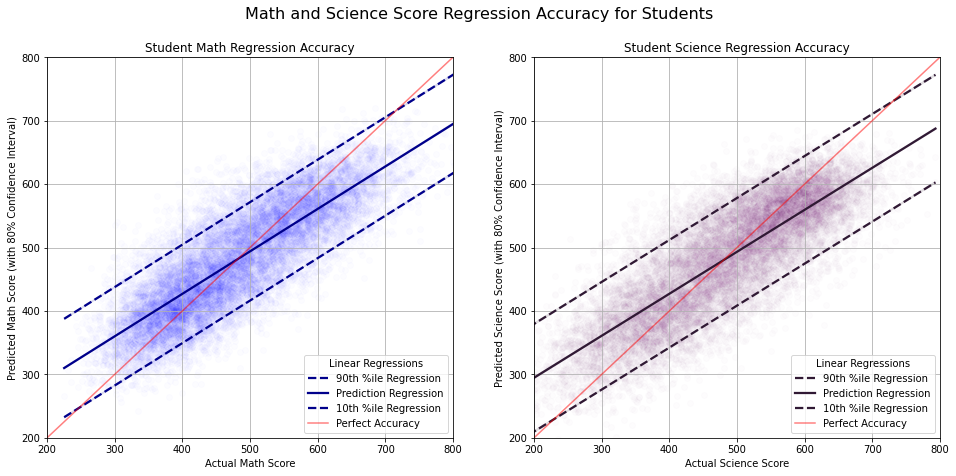

In [304]:
plt.figure(figsize=(16,7))
plt.suptitle('Math and Science Score Regression Accuracy for Students', fontsize=16)
plt.subplot(121)
sns.regplot(x=y_test_stud_math, y=pred_CI_stud_math.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
sns.regplot(x=y_test_stud_math, y=pred_stud_math, scatter_kws={'alpha':0.01, 'color':'blue'}, line_kws={'color':'#00008B'});
sns.regplot(x=y_test_stud_math, y=pred_CI_stud_math.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('Student Math Regression Accuracy')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(200,800);
plt.ylim(200,800)
plt.subplot(122)
sns.regplot(x=y_test_stud_sci, y=pred_CI_stud_sci.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
sns.regplot(x=y_test_stud_sci, y=pred_stud_sci, scatter_kws={'alpha':0.01, 'color':'purple'}, line_kws={'color':'#301934'});
sns.regplot(x=y_test_stud_sci, y=pred_CI_stud_sci.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('Student Science Regression Accuracy')
plt.xlabel('Actual Science Score')
plt.ylabel('Predicted Science Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(200,800);
plt.ylim(200,800);

In [305]:
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg',
       'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg',
       'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

In [306]:
school['IDCNTRY'] = school['IDCNTRY'].astype(str)

In [307]:
school_sub_set = school[['IDCNTRY', 'grade', 'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg']].dropna()

In [308]:
X_sch = school_sub_set[['IDCNTRY', 'grade', 'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage','socio_background']]
X_sch = pd.get_dummies(data=X_sch, drop_first=True)
X_sch.head()

grade  acad_hours  IDCNTRY_36  IDCNTRY_376  IDCNTRY_380  IDCNTRY_392  \
1      8   919.41667           1            0            0            0   
2      8  1000.00000           1            0            0            0   
3      8  1045.00000           1            0            0            0   
4      8   910.00000           1            0            0            0   
6      8  1000.00000           1            0            0            0   

   IDCNTRY_422  IDCNTRY_620  IDCNTRY_710  IDCNTRY_840  IDCNTRY_926  \
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
6            0            0            0            0            0   

   disc_prob_Minor Problems  disc_prob_Moderate to Severe Problems  \
1                         0                                      0   
2                         1                                      0   
3                         0                                      0   
4                         0                                      0   
6                         1                                      0   

   acad_emph_Medium Emphasis  acad_emph_Very High Emphasis  \
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          1                             0   
6                          1                             0   

   math_shortage_Affected A Lot  math_shortage_Not Affected  \
1                             0                           1   
2                             0                           0   
3                             0                           1   
4                             0                           1   
6                             0                           1   

   sci_shortage_Affected A Lot  sci_shortage_Not Affected  \
1                            0                          1   
2                            0                          0   
3                            0                          1   
4                            0                          1   
6                            0                          1   

   socio_background_More Disadvantaged  \
1                                    0   
2                                    0   
3                                    0   
4                                    0   
6                                    1   

   socio_background_Neither More Affluent nor More Disadvantaged  
1                                                  0              
2                                                  1              
3                                                  0              
4                                                  1              
6                                                  0

In [309]:
Y_sch_math = school_sub_set['mmat_avg']
Y_sch_sci = school_sub_set['ssci_avg']

In [310]:
X_train_sch_math, X_test_sch_math, y_train_sch_math, y_test_sch_math = train_test_split(X_sch, Y_sch_math, test_size=0.4, random_state=101)
X_train_sch_sci, X_test_sch_sci, y_train_sch_sci, y_test_sch_sci = train_test_split(X_sch, Y_sch_sci, test_size=0.4, random_state=101)

print(X_train_sch_math.shape)
print(X_test_sch_math.shape)
print(y_train_sch_math.shape)
print(y_test_sch_math.shape)

(1009, 21)
(674, 21)
(1009,)
(674,)


In [311]:
X_train_sch_math = sm.add_constant(X_train_sch_math)
X_train_sch_sci = sm.add_constant(X_train_sch_sci)

ls_sch_math = sm.OLS(y_train_sch_math, X_train_sch_math).fit()
ls_sch_sci = sm.OLS(y_train_sch_sci, X_train_sch_sci).fit()

print(ls_sch_math.summary())
print(ls_sch_sci.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     86.91
Date:                Tue, 30 Mar 2021   Prob (F-statistic):          1.62e-201
Time:                        21:07:56   Log-Likelihood:                -5292.5
No. Observations:                1009   AIC:                         1.063e+04
Df Residuals:                     988   BIC:                         1.073e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [312]:
x_matrix_sch_math = sm.add_constant(X_test_sch_math)
pred_sch_math = ls_sch_math.predict(x_matrix_sch_math)
pred_CI_sch_math = ls_sch_math.get_prediction(x_matrix_sch_math)
pred_CI_sch_math = pred_CI_sch_math.summary_frame(alpha=0.20)

x_matrix_sch_sci = sm.add_constant(X_test_sch_sci)
pred_sch_sci = ls_sch_sci.predict(x_matrix_sch_sci)
pred_CI_sch_sci = ls_sch_sci.get_prediction(x_matrix_sch_sci)
pred_CI_sch_sci = pred_CI_sch_sci.summary_frame(alpha=0.20)

In [313]:
results_sch_math = pd.merge(school[['mmat_avg']],pred_CI_sch_math[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_sch_math['capture'] = ((results_sch_math['mmat_avg'] >= results_sch_math['obs_ci_lower']).astype(int)\
                                *(results_sch_math['mmat_avg'] <= results_sch_math['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_sch_math = results_sch_math['capture'].sum()/results_sch_math.shape[0]
results_sch_sci = pd.merge(school[['ssci_avg']],pred_CI_sch_sci[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_sch_sci['capture'] = ((results_sch_sci['ssci_avg'] >= results_sch_sci['obs_ci_lower']).astype(int)\
                                *(results_sch_sci['ssci_avg'] <= results_sch_sci['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_sch_sci = results_sch_sci['capture'].sum()/results_sch_sci.shape[0]
print('School Math Regression\nConfidence Interval Capture Rate = {}\n\
School Science Regression\nConfidence Interval Capture Rate = {}'.format(cap_rate_stud_math, cap_rate_stud_sci))

School Math Regression
Confidence Interval Capture Rate = 0.8001431127012523
School Science Regression
Confidence Interval Capture Rate = 0.8045796064400715


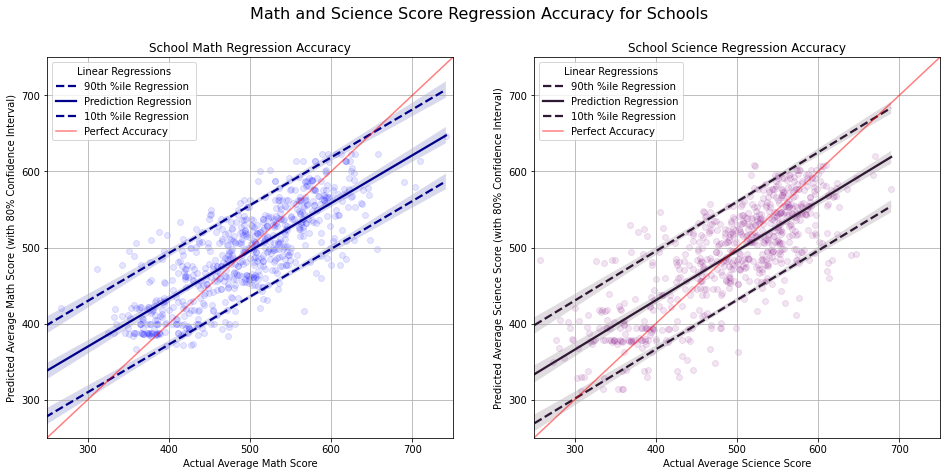

In [314]:
plt.figure(figsize=(16,7))
plt.suptitle('Math and Science Score Regression Accuracy for Schools', fontsize=16)
plt.subplot(121)
sns.regplot(x=y_test_sch_math, y=pred_CI_sch_math.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
sns.regplot(x=y_test_sch_math, y=pred_sch_math, scatter_kws={'alpha':0.1, 'color':'blue'}, line_kws={'color':'#00008B'});
sns.regplot(x=y_test_sch_math, y=pred_CI_sch_math.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('School Math Regression Accuracy')
plt.xlabel('Actual Average Math Score')
plt.ylabel('Predicted Average Math Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(250,750);
plt.ylim(250,750)
plt.subplot(122)
sns.regplot(x=y_test_sch_sci, y=pred_CI_sch_sci.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
sns.regplot(x=y_test_sch_sci, y=pred_sch_sci, scatter_kws={'alpha':0.1, 'color':'purple'}, line_kws={'color':'#301934'});
sns.regplot(x=y_test_sch_sci, y=pred_CI_sch_sci.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('School Science Regression Accuracy')
plt.xlabel('Actual Average Science Score')
plt.ylabel('Predicted Average Science Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(250,750);
plt.ylim(250,750);

In [315]:
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [316]:
math_teach['IDCNTRY'] = math_teach['IDCNTRY'].astype(str)

In [317]:
math_teach_sub_set = math_teach[['IDCNTRY','experience','style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level','mmat_avg']].dropna()

In [318]:
X_math_teach = math_teach_sub_set[['IDCNTRY','experience','style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level']]
X_math_teach = pd.get_dummies(data=X_math_teach, drop_first=True)
X_math_teach.head()

experience  style_daily_lives  style_explain_work  style_challenge  \
0        16.0                1.0                 3.0              2.0   
2        22.0                1.0                 2.0              3.0   
3         3.0                1.0                 3.0              2.0   
5        16.0                2.0                 2.0              3.0   
7         1.0                2.0                 1.0              1.0   

   style_discussion  style_link_previous  style_procedures  \
0               3.0                  2.0               2.0   
2               2.0                  3.0               2.0   
3               2.0                  3.0               2.0   
5               2.0                  3.0               3.0   
7               2.0                  2.0               2.0   

   style_express_ideas  class_time  stud_explain_new  stud_explain_solve  \
0                  3.0       210.0               3.0                 1.0   
2                  2.0       200.0               3.0                 3.0   
3                  2.0       228.0               3.0                 3.0   
5                  3.0       240.0               2.0                 2.0   
7                  2.0       250.0               3.0                 3.0   

   stud_memorize  stud_practice  stud_apply  stud_class_work  \
0            1.0            2.0         2.0              1.0   
2            3.0            3.0         3.0              3.0   
3            1.0            3.0         2.0              2.0   
5            1.0            2.0         3.0              2.0   
7            2.0            2.0         2.0              3.0   

   stud_heterogeneous  stud_homogenous  computer_class  hw_freq  hw_time  \
0                 2.0              1.0             0.0      2.0     60.0   
2                 0.0              1.0             1.0      2.0     30.0   
3                 2.0              1.0             0.0      1.0     30.0   
5                 2.0              2.0             0.0      2.0     30.0   
7                 1.0              1.0             1.0      2.0     30.0   

   hw_self_correct  hw_graded  assess_observe  assess_ask  assess_short  \
0              0.0        0.0             1.0         1.0           1.0   
2              1.0        2.0             2.0         2.0           2.0   
3              1.0        0.0             2.0         2.0           0.0   
5              1.0        1.0             1.0         1.0           2.0   
7              1.0        0.0             2.0         2.0           2.0   

   assess_long  assess_projects  school_acad_focus_score  \
0          2.0              0.0                 13.12465   
2          2.0              0.0                 10.35236   
3          1.0              1.0                 10.65284   
5          2.0              1.0                 13.86227   
7          0.0              0.0                 10.95225   

   limited_by_needs_score  school_safe_score  job_satisfaction_score  \
0                12.67245           10.58171                10.25874   
2                11.28828           12.56459                11.74559   
3                 9.11668            9.18523                10.82008   
5                 9.11668           11.78998                11.74559   
7                 8.15603           10.58171                10.25874   

   study_stem  study_edu  IDCNTRY_36  IDCNTRY_376  IDCNTRY_380  IDCNTRY_392  \
0           1          1           1            0            0            0   
2           1          0           1            0            0            0   
3           1          1           1            0            0            0   
5           1          1           1            0            0            0   
7           0          1           1            0            0            0   

   IDCNTRY_422  IDCNTRY_620  IDCNTRY_710  IDCNTRY_840  IDCNTRY_926  \
0            0            0            0            0            0   
2            0            0     

In [319]:
Y_math_teach = math_teach_sub_set['mmat_avg']

In [320]:
X_train_math_teach, X_test_math_teach, y_train_math_teach, y_test_math_teach = train_test_split(X_math_teach, Y_math_teach, test_size=0.4, random_state=101)

print(X_train_math_teach.shape)
print(X_test_math_teach.shape)
print(y_train_math_teach.shape)
print(y_test_math_teach.shape)

(577, 51)
(385, 51)
(577,)
(385,)


In [321]:
import statsmodels.api as sm

X_train_math_teach = sm.add_constant(X_train_math_teach)
ls_math_teach = sm.OLS(y_train_math_teach, X_train_math_teach).fit()
print(ls_math_teach.summary())

                            OLS Regression Results                            
Dep. Variable:               mmat_avg   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     11.33
Date:                Tue, 30 Mar 2021   Prob (F-statistic):           6.41e-57
Time:                        21:07:59   Log-Likelihood:                -3129.8
No. Observations:                 577   AIC:                             6364.
Df Residuals:                     525   BIC:                             6590.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [322]:
x_matrix_math_teach = sm.add_constant(X_test_math_teach)
pred_math_teach = ls_math_teach.predict(x_matrix_math_teach)
pred_CI_math_teach = ls_math_teach.get_prediction(x_matrix_math_teach)
pred_CI_math_teach = pred_CI_math_teach.summary_frame(alpha=0.20)

In [323]:
results_math_teach = pd.merge(math_teach[['mmat_avg']],pred_CI_math_teach[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_math_teach['capture'] = ((results_math_teach['mmat_avg'] >= results_math_teach['obs_ci_lower']).astype(int)\
                                *(results_math_teach['mmat_avg'] <= results_math_teach['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_math_teach = results_math_teach['capture'].sum()/results_math_teach.shape[0]
print('Math Teacher Regression\nConfidence Interval Capture Rate = {}'.format(cap_rate_math_teach))

Math Teacher Regression
Confidence Interval Capture Rate = 0.8


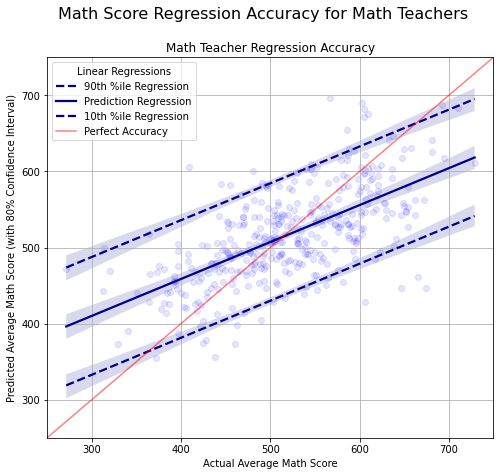

In [324]:
plt.figure(figsize=(8,7))
plt.suptitle('Math Score Regression Accuracy for Math Teachers', fontsize=16)
sns.regplot(x=y_test_math_teach, y=pred_CI_math_teach.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
sns.regplot(x=y_test_math_teach, y=pred_math_teach, scatter_kws={'alpha':0.1, 'color':'blue'}, line_kws={'color':'#00008B'});
sns.regplot(x=y_test_math_teach, y=pred_CI_math_teach.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#00008B'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('Math Teacher Regression Accuracy')
plt.xlabel('Actual Average Math Score')
plt.ylabel('Predicted Average Math Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(250,750);
plt.ylim(250,750);

In [325]:
sci_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'ITCOURSE',
       'experience', 'sex', 'age', 'prob_class_size', 'prob_much_material',
       'prob_much_time', 'prob_need_prep', 'prob_need_class_time',
       'prob_much_pressure', 'prob_change_material', 'prob_admin_tasks',
       'class_size', 'stud_lang_diff', 'style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas',
       'class_time', 'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous',
       'computer_sci', 'computer_stud', 'computer_class', 'computer_school',
       'computer_class_freq', 'computer_low_freq', 'computer_high_freq',
       'computer_spec_freq', 'hw_freq', 'hw_time', 'hw_correc

In [326]:
sci_teach['IDCNTRY'] = sci_teach['IDCNTRY'].astype(str)

In [327]:
sci_teach_sub_set = sci_teach[['IDCNTRY','experience','style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level','ssci_avg']].dropna()

In [328]:
X_sci_teach = sci_teach_sub_set[['IDCNTRY','experience','style_daily_lives',
       'style_explain_work', 'style_challenge', 'style_discussion',
       'style_link_previous', 'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_observe_phenom',
       'stud_demo_exp', 'stud_plan_exp', 'stud_conduct_exp', 'stud_present',
       'stud_interpret', 'stud_use_evid', 'stud_read_text', 'stud_memorize',
       'stud_formulas', 'stud_field', 'stud_heterogeneous', 'stud_homogenous', 'computer_class', 'hw_freq', 'hw_time',
       'hw_self_correct', 'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
       'assess_long', 'assess_projects', 'pd_hours',
       'school_acad_focus_score', 'limited_by_needs_score',
       'school_safe_score', 'job_satisfaction_score','study_stem', 'study_edu','edu_level']]
X_sci_teach = pd.get_dummies(data=X_sci_teach, drop_first=True)
X_sci_teach.head()

experience  style_daily_lives  style_explain_work  style_challenge  \
0        16.0                2.0                 3.0              2.0   
2         4.0                1.0                 1.0              1.0   
3        15.0                3.0                 3.0              1.0   
4        14.0                2.0                 2.0              1.0   
5         6.0                1.0                 3.0              1.0   

   style_discussion  style_link_previous  style_procedures  \
0               3.0                  2.0               3.0   
2               2.0                  2.0               0.0   
3               2.0                  3.0               1.0   
4               1.0                  1.0               0.0   
5               3.0                  3.0               2.0   

   style_express_ideas  class_time  stud_explain_new  stud_observe_phenom  \
0                  3.0       140.0               2.0                  2.0   
2                  2.0       250.0               3.0                  0.0   
3                  3.0       200.0               3.0                  2.0   
4                  3.0       200.0               3.0                  2.0   
5                  2.0       200.0               2.0                  2.0   

   stud_demo_exp  stud_plan_exp  stud_conduct_exp  stud_present  \
0            2.0            1.0               1.0           1.0   
2            2.0            2.0               2.0           2.0   
3            3.0            2.0               2.0           2.0   
4            1.0            2.0               1.0           2.0   
5            1.0            1.0               2.0           1.0   

   stud_interpret  stud_use_evid  stud_read_text  stud_memorize  \
0             2.0            1.0             3.0            2.0   
2             2.0            2.0             2.0            3.0   
3             2.0            2.0             3.0            3.0   
4             2.0            2.0             1.0            0.0   
5             2.0            2.0             2.0            3.0   

   stud_formulas  stud_field  stud_heterogeneous  stud_homogenous  \
0            1.0         1.0                 2.0              1.0   
2            2.0         1.0                 1.0              2.0   
3            1.0         1.0                 3.0              1.0   
4            3.0         1.0                 1.0              3.0   
5            3.0         1.0                 2.0              2.0   

   computer_class  hw_freq  hw_time  hw_self_correct  hw_graded  \
0             0.0      2.0     30.0              2.0        1.0   
2             0.0      1.0     60.0              1.0        0.0   
3             1.0      1.0     30.0              0.0        1.0   
4             1.0      1.0     30.0              0.0        0.0   
5             1.0      2.0     15.0              0.0        0.0   

   assess_observe  assess_ask  assess_short  assess_long  assess_projects  \
0             2.0         2.0           1.0          1.0              1.0   
2             2.0         2.0           2.0          2.0              0.0   
3             2.0         2.0           2.0          2.0              2.0   
4             2.0         2.0           1.0          1.0              1.0   
5             1.0         2.0           1.0          1.0              1.0   

   school_acad_focus_score  limited_by_needs_score  school_safe_score  \
0                  8.84690                10.14509            9.18523   
2                  8.54651                 9.11668            8.39631   
3                 12.15607                 7.67828           11.14932   
4                 10.95225                 9.61910            9.18523   
5                  7.30893                 9.61910            9.18523   

   job_satisfaction_score  study_stem  study_edu  IDCNTRY_36  IDCNTRY_376  \
0                 6.74486           1          1           1            0   
2                 7.21969           1          1

In [329]:
Y_sci_teach = sci_teach_sub_set['ssci_avg']

In [330]:
X_train_sci_teach, X_test_sci_teach, y_train_sci_teach, y_test_sci_teach = train_test_split(X_sci_teach, Y_sci_teach, test_size=0.4, random_state=101)

print(X_train_sci_teach.shape)
print(X_test_sci_teach.shape)
print(y_train_sci_teach.shape)
print(y_test_sci_teach.shape)

(683, 57)
(456, 57)
(683,)
(456,)


In [331]:
X_train_sci_teach = sm.add_constant(X_train_sci_teach)
ls_sci_teach = sm.OLS(y_train_sci_teach, X_train_sci_teach).fit()
print(ls_sci_teach.summary())

                            OLS Regression Results                            
Dep. Variable:               ssci_avg   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     9.587
Date:                Tue, 30 Mar 2021   Prob (F-statistic):           1.12e-54
Time:                        21:08:00   Log-Likelihood:                -3696.4
No. Observations:                 683   AIC:                             7509.
Df Residuals:                     625   BIC:                             7771.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [332]:
x_matrix_sci_teach = sm.add_constant(X_test_sci_teach)
pred_sci_teach = ls_sci_teach.predict(x_matrix_sci_teach)
pred_CI_sci_teach = ls_sci_teach.get_prediction(x_matrix_sci_teach)
pred_CI_sci_teach = pred_CI_sci_teach.summary_frame(alpha=0.20)

In [333]:
results_sci_teach = pd.merge(sci_teach[['ssci_avg']],pred_CI_sci_teach[['obs_ci_lower','mean','obs_ci_upper']], left_index=True, right_index=True)
results_sci_teach['capture'] = ((results_sci_teach['ssci_avg'] >= results_sci_teach['obs_ci_lower']).astype(int)\
                                *(results_sci_teach['ssci_avg'] <= results_sci_teach['obs_ci_upper']).astype(int)).astype(bool)
cap_rate_sci_teach = results_sci_teach['capture'].sum()/results_sci_teach.shape[0]
print('Science Teacher Regression\nConfidence Interval Capture Rate = {}'.format(cap_rate_sci_teach))

Science Teacher Regression
Confidence Interval Capture Rate = 0.8442982456140351


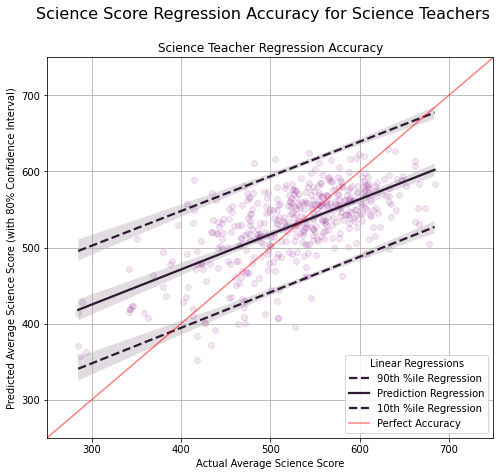

In [334]:
plt.figure(figsize=(8,7))
plt.suptitle('Science Score Regression Accuracy for Science Teachers', fontsize=16)
sns.regplot(x=y_test_sci_teach, y=pred_CI_sci_teach.obs_ci_upper.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
sns.regplot(x=y_test_sci_teach, y=pred_sci_teach, scatter_kws={'alpha':0.1, 'color':'purple'}, line_kws={'color':'#301934'});
sns.regplot(x=y_test_sci_teach, y=pred_CI_sci_teach.obs_ci_lower.values, scatter_kws={'alpha':0.0}, line_kws={'linestyle':'--','color':'#301934'});
x=np.arange(200,810,10)
plt.plot(x,x,color='#FF0000',alpha=0.5);
plt.legend(['90th %ile Regression','Prediction Regression','10th %ile Regression','Perfect Accuracy'], title="Linear Regressions")
plt.title('Science Teacher Regression Accuracy')
plt.xlabel('Actual Average Science Score')
plt.ylabel('Predicted Average Science Score (with 80% Confidence Interval)')
plt.grid(True)
plt.xlim(250,750);
plt.ylim(250,750);

[Return to Top of Data Modeling](#data_modeling)

<div id='classification_models'></div>

## Classification Models

In [335]:
def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)

In [336]:
school['socio_background'].value_counts()

More Disadvantaged                              921
Neither More Affluent nor More Disadvantaged    508
More Affluent                                   498
Name: socio_background, dtype: int64

In [337]:
school.columns

Index(['IDCNTRY', 'IDSCHOOL', 'grade', 'language', 'disc_prob_score',
       'acad_emph_score', 'math_shortage_score', 'sci_shortage_score',
       'acad_hours', 'disc_prob', 'acad_emph', 'math_shortage', 'sci_shortage',
       'socio_background', 'mmat_avg', 'ssci_avg', 'malg_avg', 'mapp_avg',
       'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg', 'sapp_avg',
       'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg'],
      dtype='object')

In [338]:
math_teach.columns

Index(['IDCNTRY', 'IDSCHOOL', 'IDTEALIN', 'IDTEACH', 'IDLINK', 'experience',
       'sex', 'age', 'prob_class_size', 'prob_much_material', 'prob_much_time',
       'prob_need_prep', 'prob_need_class_time', 'prob_much_pressure',
       'prob_change_material', 'prob_admin_tasks', 'class_size',
       'stud_lang_diff', 'style_daily_lives', 'style_explain_work',
       'style_challenge', 'style_discussion', 'style_link_previous',
       'style_procedures', 'style_express_ideas', 'class_time',
       'stud_explain_new', 'stud_explain_solve', 'stud_memorize',
       'stud_practice', 'stud_apply', 'stud_class_work', 'stud_heterogeneous',
       'stud_homogenous', 'computer_math', 'computer_stud', 'computer_class',
       'computer_school', 'computer_class_freq', 'computer_low_freq',
       'computer_high_freq', 'computer_spec_freq', 'hw_freq', 'hw_time',
       'hw_correct', 'hw_self_correct', 'hw_discuss', 'hw_complete',
       'hw_graded', 'assess_observe', 'assess_ask', 'assess_short',
   

In [339]:
new_set = school.set_index(['IDCNTRY','IDSCHOOL']).join(math_teach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,['class_size','experience','job_satisfaction_score','class_time']]
                                                        .join(sci_teach.groupby(['IDCNTRY','IDSCHOOL']).mean().loc[:,['class_size','experience','job_satisfaction_score','class_time']], 
                                                              lsuffix="_math", rsuffix="_sci")).dropna()

In [340]:
new_set.reset_index(inplace=True)
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(str)

In [341]:
X_socio = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
y_socio = new_set.socio_background
print(X_socio.shape)
print(y_socio.shape)

(1182, 10)
(1182,)


In [342]:
# Split into training and test sets
X_train_socio, X_test_socio, y_train_socio, y_test_socio = train_test_split(X_socio, y_socio, test_size=0.2, random_state=42)

In [343]:
clf_socio = RandomForestClassifier(random_state=0, n_jobs=-1)
clf_socio.get_params().keys()
# specify parameters for grid search
parameters_socio = {
    'bootstrap':[True, False],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [30, 50, 75]
}

# create grid search object
cv_socio = GridSearchCV(clf_socio, param_grid=parameters_socio)
cv_socio.fit(X_train_socio, y_train_socio)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [30, 50, 75]})

In [344]:
y_pred_socio = cv_socio.predict(X_test_socio)
    
display_results(cv_socio, y_test_socio, y_pred_socio)

Labels: ['More Affluent' 'More Disadvantaged'
 'Neither More Affluent nor More Disadvantaged']
Confusion Matrix:
 [[46 10 14]
 [17 53 11]
 [34 28 24]]
Accuracy: 0.5189873417721519

Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 30}


In [345]:
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(int)
X = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
y = new_set.socio_background
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [346]:
# Create a classifier
xgb = XGBClassifier(booster='gbtree', random_state=42, eval_metric="rmse", num_class=3, n_estimators=500)
# Fit the classifier with the training data
xgb.fit(X_train,y_train)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [347]:
predictions_xgb = xgb.predict(X_test)

In [348]:
(y_test == predictions_xgb).mean()

0.47257383966244726

In [349]:
new_set['IDCNTRY'] = new_set['IDCNTRY'].astype(str)
X = new_set[['IDCNTRY','disc_prob_score','acad_emph_score','acad_hours','class_size_math','class_time_math','experience_math','class_size_sci','class_time_sci','experience_sci']]
y = new_set.socio_background
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [350]:
knn = KNeighborsClassifier(n_neighbors=13, weights = 'distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13, weights='distance')

In [351]:
predictions_knn = knn.predict(X_test)

In [352]:
(y_test == predictions_knn).mean()

0.3924050632911392

In [353]:
(y_pred_socio == predictions_xgb).mean()

0.6624472573839663

In [354]:
(predictions_knn == predictions_xgb).mean()

0.4936708860759494

In [355]:
(predictions_knn == y_pred_socio).mean()

0.4641350210970464

In [356]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{'More Affluent': 70,
 'More Disadvantaged': 81,
 'Neither More Affluent nor More Disadvantaged': 86}

In [357]:
unique, counts = np.unique(y_pred_socio, return_counts=True)
dict(zip(unique, counts))

{'More Affluent': 97,
 'More Disadvantaged': 91,
 'Neither More Affluent nor More Disadvantaged': 49}

In [358]:
unique, counts = np.unique(predictions_xgb, return_counts=True)
dict(zip(unique, counts))

{'More Affluent': 81,
 'More Disadvantaged': 77,
 'Neither More Affluent nor More Disadvantaged': 79}

In [359]:
output = pd.DataFrame()
output['Expected Output'] = y_test
output['RF Output'] = y_pred_socio
output['XGB Output'] = predictions_xgb
output['KNN Output'] = predictions_knn
output.head(20)

Expected Output  \
802                             More Disadvantaged   
1001  Neither More Affluent nor More Disadvantaged   
1047  Neither More Affluent nor More Disadvantaged   
86                                   More Affluent   
933                                  More Affluent   
479                             More Disadvantaged   
966                             More Disadvantaged   
970   Neither More Affluent nor More Disadvantaged   
493                             More Disadvantaged   
344                             More Disadvantaged   
220                                  More Affluent   
679                                  More Affluent   
953                             More Disadvantaged   
711                                  More Affluent   
243                             More Disadvantaged   
170                             More Disadvantaged   
274                             More Disadvantaged   
411   Neither More Affluent nor More Disadvantaged   
1159                            More Disadvantaged   
927                             More Disadvantaged   

                                         RF Output  \
802                             More Disadvantaged   
1001  Neither More Affluent nor More Disadvantaged   
1047  Neither More Affluent nor More Disadvantaged   
86                                   More Affluent   
933                             More Disadvantaged   
479   Neither More Affluent nor More Disadvantaged   
966                             More Disadvantaged   
970   Neither More Affluent nor More Disadvantaged   
493                             More Disadvantaged   
344                                  More Affluent   
220                                  More Affluent   
679   Neither More Affluent nor More Disadvantaged   
953                             More Disadvantaged   
711   Neither More Affluent nor More Disadvantaged   
243                             More Disadvantaged   
170                             More Disadvantaged   
274                             More Disadvantaged   
411   Neither More Affluent nor More Disadvantaged   
1159                            More Disadvantaged   
927   Neither More Affluent nor More Disadvantaged   

                                        XGB Output  \
802                             More Disadvantaged   
1001  Neither More Affluent nor More Disadvantaged   
1047                                 More Affluent   
86                                   More Affluent   
933                             More Disadvantaged   
479   Neither More Affluent nor More Disadvantaged   
966                             More Disadvantaged   
970   Neither More Affluent nor More Disadvantaged   
493                             More Disadvantaged   
344                                  More Affluent   
220                                  More Affluent   
679   Neither More Affluent nor More Disadvantaged   
953   Neither More Affluent nor More Disadvantaged   
711                                  More Affluent   
243                             More Disadvantaged   
170   Neither More Affluent nor More Disadvantaged   
274                             More Disadvantaged   
411                             More Disadvantaged   
1159                            More Disadvantaged   
927   Neither More Affluent nor More Disadvantaged   

                                        KNN Output  
802                             More Disadvantaged  
1001  Neither More Affluent nor More Disadvantaged  
1047                            More Disadvantaged  
86                                   More Affluent  
933                             More Disadvantaged  
479                                  More Affluent  
966                             More Disadvantaged  
970                             More Disadvantaged  
493                                  More Affluent  
344                                  More Affluent  
220                             More Disadvanta

[Return to Top of Data Modeling](#data_modeling)

<div id='recommendation_engine'></div>

## Recommendation Engine

In [360]:
stud_ach

IDCNTRY  test_book  IDSCHOOL  IDCLASS    IDSTUD  grade   language  \
0           36          1      5001   500101  50010101      8    English   
1           36          2      5001   500101  50010102      8    English   
2           36          4      5001   500101  50010104      8    English   
3           36          5      5001   500101  50010105      8    English   
4           36          7      5001   500101  50010107      8    English   
...        ...        ...       ...      ...       ...    ...        ...   
65965      710          3      5520   552004  55200422      9  Afrikaans   
65966      710          4      5520   552004  55200423      9  Afrikaans   
65967      710          5      5520   552004  55200424      9  Afrikaans   
65968      710          6      5520   552004  55200425      9  Afrikaans   
65969      710          7      5520   552004  55200426      9  Afrikaans   

          sex    age  MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
0      Female  13.50          1.0          1.0          0.0          NaN   
1        Male  14.33          NaN          NaN          NaN          NaN   
2        Male  13.83          NaN          NaN          NaN          NaN   
3      Female  14.08          NaN          NaN          NaN          NaN   
4      Female  13.83          NaN          NaN          NaN          NaN   
...       ...    ...          ...          ...          ...          ...   
65965  Female  14.75          NaN          NaN          NaN          NaN   
65966    Male  15.17          NaN          NaN          NaN          NaN   
65967    Male  15.42          NaN          NaN          NaN          NaN   
65968    Male  15.33          NaN          NaN          NaN          NaN   
65969    Male  15.58          NaN          NaN          NaN          NaN   

       MP52063_val  MP52072_val  MP52146_val  MP52092_val  MP52046_val  \
0              0.0          0.0          0.0          0.0          1.0   
1              NaN          NaN          NaN          NaN          NaN   
2              NaN          NaN          NaN          NaN          NaN   
3              NaN          NaN          NaN          NaN          NaN   
4              NaN          NaN          NaN          NaN          NaN   
...            ...          ...          ...          ...          ...   
65965          NaN          NaN          NaN          NaN          NaN   
65966          NaN          NaN          NaN          NaN          NaN   
65967          NaN          NaN          NaN          NaN          NaN   
65968          NaN          NaN          NaN          NaN          NaN   
65969          NaN          NaN          NaN          NaN          NaN   

       MP52083_val  MP52082_val  MP52161_val  MP52418_val  MP72007_val  \
0              0.0          1.0          1.0          0.0          0.0   
1              NaN          NaN          NaN          NaN          0.0   
2              NaN          NaN          NaN          NaN          NaN   
3              NaN          NaN          NaN          NaN          NaN   
4              NaN          NaN          NaN          NaN          NaN   
...            ...          ...          ...          ...          ...   
65965          NaN          NaN          NaN          NaN          NaN   
65966          NaN          NaN          NaN          NaN          NaN   
65967          NaN          NaN          NaN          NaN          NaN   
65968          NaN          NaN          NaN          NaN          NaN   
65969          NaN          NaN          NaN          NaN          NaN   

       MP72025_val  MP72017_val  MP72190_val  MP72068_val  MP72076_val  \
0              1.0          NaN          0.0          1.0          0.0   
1              1.0          1.0          1.0          1.0          1.0   
2              NaN          NaN          NaN          NaN          NaN   
3              NaN          NaN          NaN          NaN          NaN   
4              NaN          NaN  

In [361]:
item_values = pd.concat([stud_ach.loc[:,[col for col in stud_ach.columns if '_val' in col]].mean(),stud_ach.loc[:,[col for col in stud_ach.columns if '_val' in col]].count()], axis=1).rename(columns={0:'val',1:'count'})

In [362]:
item_values.index = item_values.reset_index()['index'].apply(lambda x: x[:-4])
item_values

val  count
index                   
MP52024  0.442166   9121
MP52058  0.227532   8957
MP52125  0.419820   9223
MP52229  0.432032   8710
MP52063  0.380291   9143
...           ...    ...
SP72210  0.503631   9088
SP72249  0.440454   8993
SP72323  0.541312   8823
SP72368  0.603168   9029
SP72303  0.371301   8279

[386 rows x 2 columns]

In [363]:
file_name = 'T19_G8_Item Information/T19_G8_Item Information.xlsx'
math_items = pd.read_excel(file_name, sheet_name='MAT').set_index('Item ID').iloc[:,[7,8,9,10,12,15]]
sci_items = pd.read_excel(file_name, sheet_name='SCI').set_index('Item ID').iloc[:,[7,8,9,10,12,15]]

In [364]:
user_item = stud_ach.set_index(['IDCNTRY','IDSTUD']).loc[:,[col for col in stud_ach.columns if '_val' in col]]

In [365]:
user_item

MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
36      50010101          1.0          1.0          0.0          NaN   
        50010102          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
        50010107          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
36      50010101          0.0          0.0          0.0          0.0   
        50010102          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
        50010107          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
36      50010101          1.0          0.0          1.0          1.0   
        50010102          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
        50010107          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
36      50010101          0.0          0.0          1.0          NaN   
        50010102          NaN          0.0          1.0          1.0   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
        50010107          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
36      50010101          0.0          1.0          0.0          1.0   
        50010102          1.0          1.0          1.

In [366]:
user_item = user_item[pd.DataFrame(user_item.index)[0].apply(lambda x: x[0]<1000).values]

In [367]:
user_item

MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
36      50010101          1.0          1.0          0.0          NaN   
        50010102          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
        50010107          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
36      50010101          0.0          0.0          0.0          0.0   
        50010102          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
        50010107          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
36      50010101          1.0          0.0          1.0          1.0   
        50010102          NaN          NaN          NaN          NaN   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
        50010107          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
36      50010101          0.0          0.0          1.0          NaN   
        50010102          NaN          0.0          1.0          1.0   
        50010104          NaN          NaN          NaN          NaN   
        50010105          NaN          NaN          NaN          NaN   
        50010107          NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
710     55200422          NaN          NaN          NaN          NaN   
        55200423          NaN          NaN          NaN          NaN   
        55200424          NaN          NaN          NaN          NaN   
        55200425          NaN          NaN          NaN          NaN   
        55200426          NaN          NaN          NaN          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
36      50010101          0.0          1.0          0.0          1.0   
        50010102          1.0          1.0          1.

In [368]:
user_id = (710, 55200422)
user_item.loc[user_id,:]

MP52024_val   NaN
MP52058_val   NaN
MP52125_val   NaN
MP52229_val   NaN
MP52063_val   NaN
               ..
SP72210_val   NaN
SP72249_val   NaN
SP72323_val   NaN
SP72368_val   NaN
SP72303_val   NaN
Name: (710, 55200422), Length: 386, dtype: float64

In [369]:
%%time
similar_users = user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna().sort_values(ascending=False).head(10).index
user_item.loc[similar_users,:]

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Wall time: 7.98 s


MP52024_val  MP52058_val  MP52125_val  MP52229_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          NaN          NaN          NaN          NaN   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          NaN          NaN          NaN          NaN   
36      50450216          NaN          NaN          NaN          NaN   
376     51400536          NaN          NaN          NaN          NaN   
926     50630926          NaN          NaN          NaN          NaN   
36      52310222          NaN          NaN          NaN          NaN   
840     52050401          NaN          NaN          NaN          NaN   
36      51170611          NaN          NaN          NaN          NaN   

                  MP52063_val  MP52072_val  MP52146_val  MP52092_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          NaN          NaN          NaN          NaN   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          NaN          NaN          NaN          NaN   
36      50450216          NaN          NaN          NaN          NaN   
376     51400536          NaN          NaN          NaN          NaN   
926     50630926          NaN          NaN          NaN          NaN   
36      52310222          NaN          NaN          NaN          NaN   
840     52050401          NaN          NaN          NaN          NaN   
36      51170611          NaN          NaN          NaN          NaN   

                  MP52046_val  MP52083_val  MP52082_val  MP52161_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          NaN          NaN          NaN          NaN   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          NaN          NaN          NaN          NaN   
36      50450216          NaN          NaN          NaN          NaN   
376     51400536          NaN          NaN          NaN          NaN   
926     50630926          NaN          NaN          NaN          NaN   
36      52310222          NaN          NaN          NaN          NaN   
840     52050401          NaN          NaN          NaN          NaN   
36      51170611          NaN          NaN          NaN          NaN   

                  MP52418_val  MP72007_val  MP72025_val  MP72017_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          NaN          0.0          0.0          0.0   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          NaN          1.0          0.0          0.0   
36      50450216          NaN          0.0          1.0          NaN   
376     51400536          NaN          1.0          0.0          0.0   
926     50630926          NaN          0.0          1.0          NaN   
36      52310222          NaN          NaN          NaN          NaN   
840     52050401          NaN          NaN          NaN          NaN   
36      51170611          NaN          0.0          0.0          NaN   

                  MP72190_val  MP72068_val  MP72076_val  MP72056_val  \
IDCNTRY IDSTUD                                                         
36      50370711          NaN          NaN          NaN          NaN   
840     52090207          1.0          1.0          0.0          NaN   
36      50720409          NaN          NaN          NaN          NaN   
422     51590122          0.0          1.0          1.0          1.0   
36      50450216          0.0          0.0          0.0          NaN   
376     51400536          1.0          1.0          0.

In [370]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of most similar users
    
    '''
    # compute similarity of each user to the provided user
    similar_users = user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna()
    # sort by similarity
    similar_users.sort_values(ascending=False, inplace=True)
    # create list of just the ids
    most_similar_users = list(similar_users.index)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [371]:
def get_item_info(item_ids, math_items=math_items, sci_items=sci_items):
    '''
    gathers the info of the test items with given ids
    
    INPUT:
    item_ids - (list) a list of item ids
    math_items - (pandas dataframe) dataframe containing all math item information
    sci_items - (pandas dataframe) dataframe containing all science item information
    
    OUTPUT:
    item_info - (list of lists) a list of item information associated with the list of item ids 
                    (this is identified by the title column)
    '''
    item_info = []
    
    # gathers the info for any item id that is included in the list of test ids
    for item in item_ids:
        if item[0] == 'M':
            for match in list(math_items.loc[[_ for _ in math_items.index if item[:7] in _[:7]],:].values):
                match = list(match)
                item_info.append('{}: {} ({}) --> {}'.format(match[0], match[1], match[3], match[5]))
        elif item[0] =='S':
            for match in list(sci_items.loc[[_ for _ in sci_items.index if item[:7] in _[:7]],:].values):
                match = list(match)
                item_info.append('{}: {} ({}) --> {}'.format(match[0], match[1], match[3], match[5]))

    return item_info # Return the article names associated with list of article ids

In [372]:
def get_user_items(user_id, user_item=user_item):
    '''    
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
    OUTPUT:
    item_ids - (list) a list of the items ids completed by the user
    item_info - (list) a list of test item info associated with the list of item ids 
    
    Description:
    Provides a list of the item ids and item information that have been seen by a user
    '''
    # gathers all of the article ids with which the user has already interacted
    item_ids = list(user_item.columns[np.where(user_item.loc[user_id,:].apply(lambda x: x == x))].astype(str))
    # gets the article names for those same articles
    item_info = get_item_info(item_ids)
    
    return item_ids, item_info # return the ids and information

In [373]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    # create an empty set to store the recommendations
    recs = set()
    # gather the article ids for the previous articles from our target user
    user_item_list = get_user_items(user_id)[0]
    # identify all similar users, ranked from most similar
    similar_users = find_similar_users(user_id)
    # for each user in the similarity list
    for sim_user in similar_users:
        # gather the article ides for the previous articles for this particular similar user
        sim_user_articles = get_user_items(sim_user)[0]
        # find the new articles that our target user had not read yet
        new_items = np.setdiff1d(sim_user_articles, user_item_list)
        # for each of the new items to recommend
        for item in new_items:
            # if there are already enough recommendations
            if len(recs) >= m:
                # stop looking for more recommendations
                break
            # otherwise, if there are not enough recommendations yet
            else:
                # add the item to the set of recommendations
                recs.add(item)
        # at the end of a similar user, if there are enough recommendations, stop looking at other users
        if len(recs) >= m:
                break
        
    return list(recs) # return your recommendations for this user_id

In [374]:
item_values.loc[[x[:-4] for x in user_user_recs(user_id)],:]

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


val  count
index                   
MP52407  0.581897   9225
MP52034  0.511471   9197
MP52117  0.141661   9078
MP52134  0.610000   9300
MP52036  0.371682   8553
MP52110  0.315953   8055
MP52078  0.358732   9213
MP52174  0.192010   8911
MP52105  0.180892   8635
MP52130  0.316251   9230

In [375]:
pd.DataFrame(user_item.count(axis=1),columns=['items'])

items
IDCNTRY IDSTUD         
36      50010101     49
        50010102     57
        50010104     52
        50010105     43
        50010107     55
...                 ...
710     55200422     51
        55200423     52
        55200424     51
        55200425     49
        55200426     56

[65970 rows x 1 columns]

In [376]:
def get_top_sorted_users(user_id, user_item=user_item):
    '''
    sorts users by similarity to target user and total activity so that collaborative filtering is as productive as possible
    
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when user got the question correct,
                0's when user got the question incorrect,
                NaN when user has not interacted with the question
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    index (IDCNTRY, IDSTUD) - is a neighbor user_id (information to differentiate users)
                    similarity - measure of the similarity of each user to the provided user_id
                    items - the number of items completed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create a matrix that measures similiarity
    similarity = pd.DataFrame(user_item.loc[user_item.index != user_id, :].corrwith(user_item.loc[user_id,:], axis=1).dropna(), columns=['similarity'])
    # count the total interactions for each user (measure of level of activity)
    interactions = pd.DataFrame(user_item.count(axis=1),columns=['items'])
    # join the similarity ratings with the user interaction cout
    neighbors_df = similarity.join(interactions) 
    # sort the values by similarity and then by the number of user_interactions
    neighbors_df.sort_values(by=['similarity','items'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [377]:
get_top_sorted_users(user_id)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


similarity  items
IDCNTRY IDSTUD                     
36      50370711    0.846114     52
840     52090207    0.755929     36
36      50720409    0.657129     53
422     51590122    0.650000     40
36      50450216    0.632456     35
...                      ...    ...
710     51660202   -0.690066     42
        53950320   -0.690066     30
380     50590313   -0.690849     51
840     51010627   -0.836660     45
710     50010110   -0.844097     51

[13976 rows x 2 columns]

In [378]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (tuple of two ints) a tuple containing an integer for country and an integer for student
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by item id
    rec_names - (list) a list of recommendations for the user by item information
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds items the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total item interactions 
    before choosing those with fewer item interactions.

    * Choose articles with the items with the lowest average performance (most difficult questions) 
    before choosing those with higher average performance (easier questions). 
   
    '''
    # create an empty set for the recommendations
    recs = []
    # sort all test items by difficulty for use ranking
    top_items = item_values.sort_values(by=['count'], ascending=False).sort_values(by=['val']).index.tolist()
    # gets the items already assessed by the target user
    user_item_list = get_user_items(user_id)[0]
    # gathers a list of users similar to the target user (sorted by similarity and level of activity)
    similar_users = get_top_sorted_users(user_id).index.tolist()
    # go through each individual user
    for sim_user in similar_users:
        if len(recs) >= m:
            break
        else:
            # get the similar user's items
            sim_user_items = get_user_items(sim_user)[0]
            # gather only items new to the target user
            new_items = [x[:-4] for x in np.setdiff1d(sim_user_items, user_item_list)]
            # create a list of the new items
            new_list = [x for x in top_items if x in new_items]
            # keep adding items to the recommendations until we reach the recommendation limit
            for item in new_list:
                if len(recs) >= m:
                    break
                else:
                    recs.append(item)
                    user_item_list.append(item)
            
    
    # find all of the names of the articles
    rec_info  = get_item_info(recs)
    
    return recs, rec_info

In [379]:
%%time
recs, recs_info = user_user_recs_part2(user_id)

C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sjhal\Anaconda3\envs\capstone\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Wall time: 8.59 s


In [380]:
def FunkSVD(assess_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    assess_mat - (numpy array) a matrix with users as rows, assessment items as columns, and scores as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    item_mat - (numpy array) a latent feature by assessment item matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = assess_mat.shape[0] # number of users in the matrix
    n_items = assess_mat.shape[1] # number of assessment items in the matrix
    num_scores = n_users * n_items # total number of scores in the matrix
    
    # initialize the user and assessment item matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users,latent_features) # user matrix filled with random values of shape user x latent 
    item_mat = np.random.rand(latent_features,n_items) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_items):
                # if the rating exists
                if assess_mat[i, j] >= 0:
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    err = assess_mat[i, j] - user_mat[i,:].dot(item_mat[:,j])
                    # Keep track of the total sum of squared errors for the matrix
                    sse_accum += err**2
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i,k] += learning_rate * (2*err*item_mat[k,j])
                        item_mat[k,j] += learning_rate * (2*err*user_mat[i,k])
        # print results for iteration
        if (iteration+1)%(int(iters/10)) == 0:
            print("%d \t\t %f" % (iteration+1, sse_accum / num_scores))
        if iteration > 0 and old_sse < sse_accum:
            print("%d \t\t %f" % (iteration+1, sse_accum / num_scores))
            break
    return user_mat, item_mat 

In [381]:
def user_item_predict(user_id, item_titles):
    '''
    uses FunkSVD to estimate user performance on a previously unassessed assessment items
    
    INPUT:
    user_id - (tuple of integers) a tuple containing an integer for country and an integer for student
    item_titles - (list of strings) a list of the assessment item titles on which to estimate performance
    
    OUTPUT:
    prediction - (list of floats) predicted scores for the user on the requested assessment items within item_titles
    '''
    # try to complete the prediction
    try:
        print("Searching the assessment items...")
        # create a list of the item indexes
        item_ids = [list(user_item.columns).index(item_title+"_val") for item_title in item_titles]
        print("Generating prediction matrix...")
        # create a dataframe of the desired user and 99 random other students with their respective assessment records
        user_item_subset = pd.concat([user_item[user_item.index == user_id],user_item[user_item.index != user_id].sample(99)])
        # convert the dataframe into a numpy matrix for analysis
        assess_mat = np.matrix(user_item_subset)
        print("Optimizing predicrion matrix...")
        # run FunkSVD with the assessment matrix to estimate performance on remaining assessment items
        user_mat, item_mat = FunkSVD(assess_mat, latent_features=9, learning_rate = 0.001, iters = 1000)
        # dot multiply the two resultant matrices to calculate predictions
        preds = user_mat.dot(item_mat)
        # create an empty list with which to store and return the predictions
        item_preds = []
        print("Gathering predictions...")
        # go through each index for desired prediction
        for item_id in item_ids:
            # grab the predicted performance from the matrix
            value = preds[0,item_id]
            # append the prediction to the list
            item_preds.append(value)
        # return only the relevant predictions for the requested item_titles
        return item_preds
    # if the prediction fails for any reason, display an error and return a null value from the function
    except:
        print("---Error---")
        return None

In [382]:
item_titles = recs

In [383]:
item_preds = user_item_predict(user_id, item_titles=item_titles)

Searching the assessment items...
Generating prediction matrix...
Optimizing predicrion matrix...
Optimization Statistics
Iterations | Mean Squared Error 
100 		 0.020501
200 		 0.015600
300 		 0.012367
400 		 0.010178
500 		 0.008670
600 		 0.007583
700 		 0.006770
800 		 0.006148
900 		 0.005667
1000 		 0.005290
Gathering predictions...


In [384]:
print("Predictions:\n1 = Expected Correct\n0 = Expected Incorrect\n\nUser ID: {}".format(user_id))
for i, item_pred in enumerate(item_preds):
    print("\nItem: {} \t\t{:.2f}".format(item_titles[i], item_pred))
    print("\n\tTest Item Information:")
    for item_info in get_item_info([item_titles[i]]):
        print("\t"+item_info)

Predictions:
1 = Expected Correct
0 = Expected Incorrect

User ID: (710, 55200422)

Item: MP52117 		0.37

	Test Item Information:
	Data and Probability: Data (Applying) --> Is Jesse's bar graph correct

Item: MP52105 		0.27

	Test Item Information:
	Algebra: Relationships and Functions (Applying) --> Which slope has a greater value

Item: MP52174 		0.32

	Test Item Information:
	Number: Integers (Applying) --> How many kilocalories used
	Number: Integers (Applying) --> How many minutes of soccer played

Item: SP52085 		0.59

	Test Item Information:
	Biology: Diversity, Adaptation, and Natural Selection (Reasoning) --> Crocodile facts: Advantage vision
	Biology: Diversity, Adaptation, and Natural Selection (Reasoning) --> Crocodile facts: Why well suited

Item: MP52110 		0.65

	Test Item Information:
	Algebra: Expressions, Operations, and Equations (Knowing) --> Convert Celsius into Fahrenheit

Item: MP52130 		0.58

	Test Item Information:
	Algebra: Expressions, Operations, and Equation

[Return to Top](#top)

<div id='evaluate_results'></div>

# Evaluate Results

[Return to Top](#top)

<div id='deploy_model'></div>

# Deploy Model